# Testing Regularization on MNIST with LeNet

## Imports and data loading

In [1]:
import torch
import pickle
import jupyter_black
from torchsummary import summary

from data_generators import data_loader_MNIST
from model_classes import LeNet
from tools import train
from plotting_tools import (
    plot_results,
    plot_reg_results,
    plot_weight_distributions,
    plot_activation_maps,
    plot_predicted_probabilities,
    plot_activations_pca,
    plot_activations_tsne,
    plot_saliency_maps,
    plot_occlusion_sensitivity,
)

jupyter_black.load()

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Loading MNIST dataset
in_channels = 1
train_loader, test_loader = data_loader_MNIST()
summary_model = LeNet(lr=0.01, momentum=0.9, in_channels=in_channels).to(device)
summary(summary_model, (in_channels, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
           Dropout-6                  [-1, 120]               0
            Linear-7                   [-1, 84]          10,164
           Dropout-8                   [-1, 84]               0
            Linear-9                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
---------------------------------------------

## Hyperparameters

In [4]:
lr = 0.01
momentum = 0.9

## No regularization

### Training

In [5]:
# model = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
# n_epochs = 10
# losses, reg_losses, epochs, weights, train_accuracies, test_accuracies = train(
#    train_loader, test_loader, model, n_epochs
# )
model = torch.load("./Trained_models/model_no_reg.pt", map_location=torch.device("cpu"))
with open("./Trained_models/model_no_reg_data.pkl", "rb") as f:
    data = pickle.load(f)
    losses = data["losses"]
    reg_losses = data["reg_losses"]
    epochs = data["epochs"]
    weights = data["weights"]
    train_accuracies = data["train_accuracies"]
    test_accuracies = data["test_accuracies"]

### Visualization

#### Plot of Losses and Accuracies

The most straightforward way to visualize the effect of regularization is by plotting the training and validation loss over time. If regularization is working correctly, we should observe a decrease in the gap between training and validation loss, indicating a reduction in overfitting.

ValueError: x and y must have same first dimension, but have shapes (4690,) and (0,)

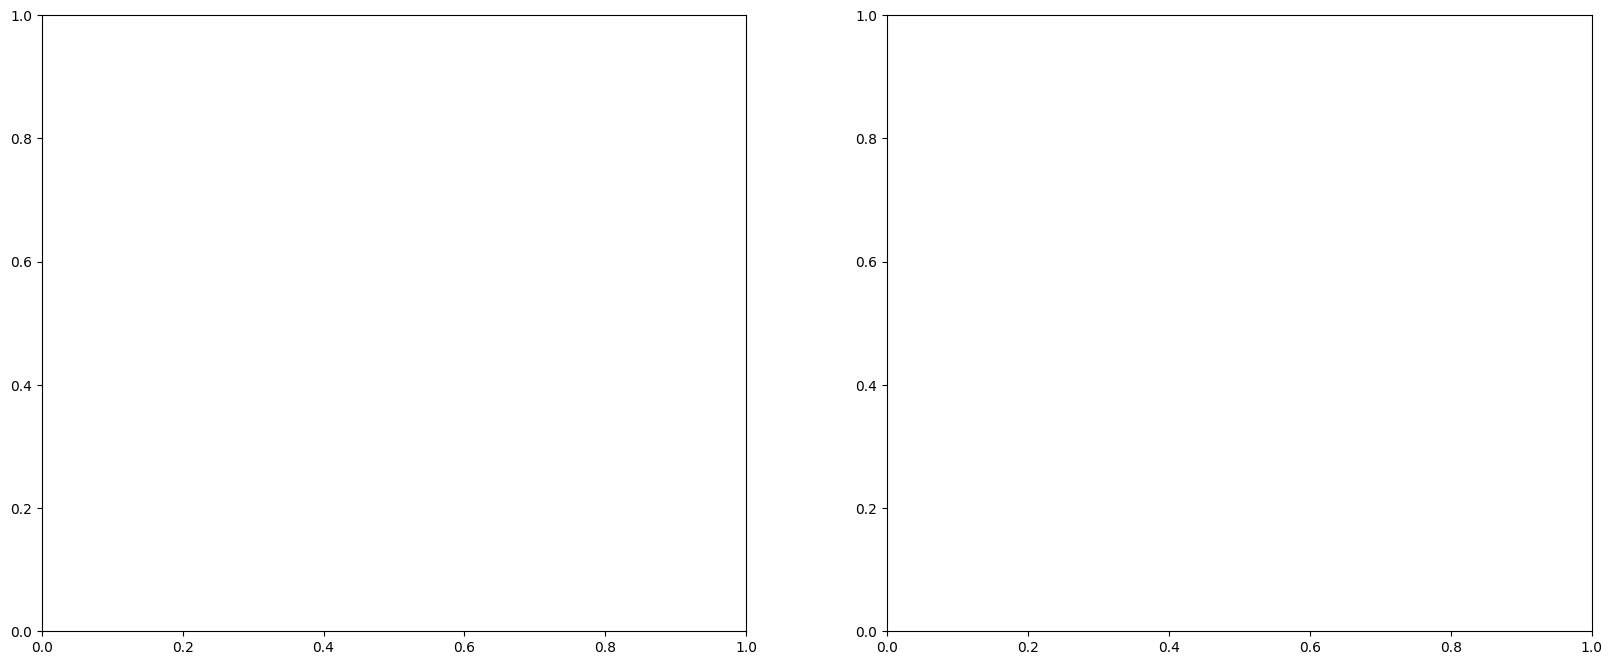

In [6]:
plot_results(
    epochs, losses, train_accuracies, test_accuracies, title="No regularization"
)

#### Plot of Weight Distributions

For L1, L2, and Elastic Net regularization, it is useful to visualize the distribution of the weights in the model. L1 regularization should result in many weights being exactly zero, while L2 regularization will typically result in a distribution with smaller magnitudes.

In [ ]:
plot_weight_distributions(model, title="Weight Distributions with No Regularization")

AttributeError: 'collections.OrderedDict' object has no attribute 'named_modules'

#### Plots of Activation Maps

Plots activation maps for each filter in each convolutional layer for a random image taken from the loader sent into the function. To see whether the model builds good representations/picks up on interesting features with the filters - look at train_loader. To see how well it generalizes look at test_loader. We see that images in the first conv layer look almost identical to the input image, while in the second layer they start learning some more clear features. Especially in the context of convolutional neural networks (CNNs), visualizing the feature maps - the activations of the convolutional layers - can provide insight into what features the network is learning. This can give a sense of how regularization is affecting the types of features learned. For instance, too much L1/L2 regularization might result in overly simplistic feature maps, while too little might result in feature maps that are overly complex or noisy.

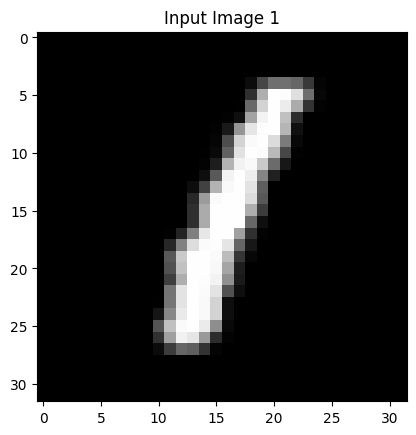

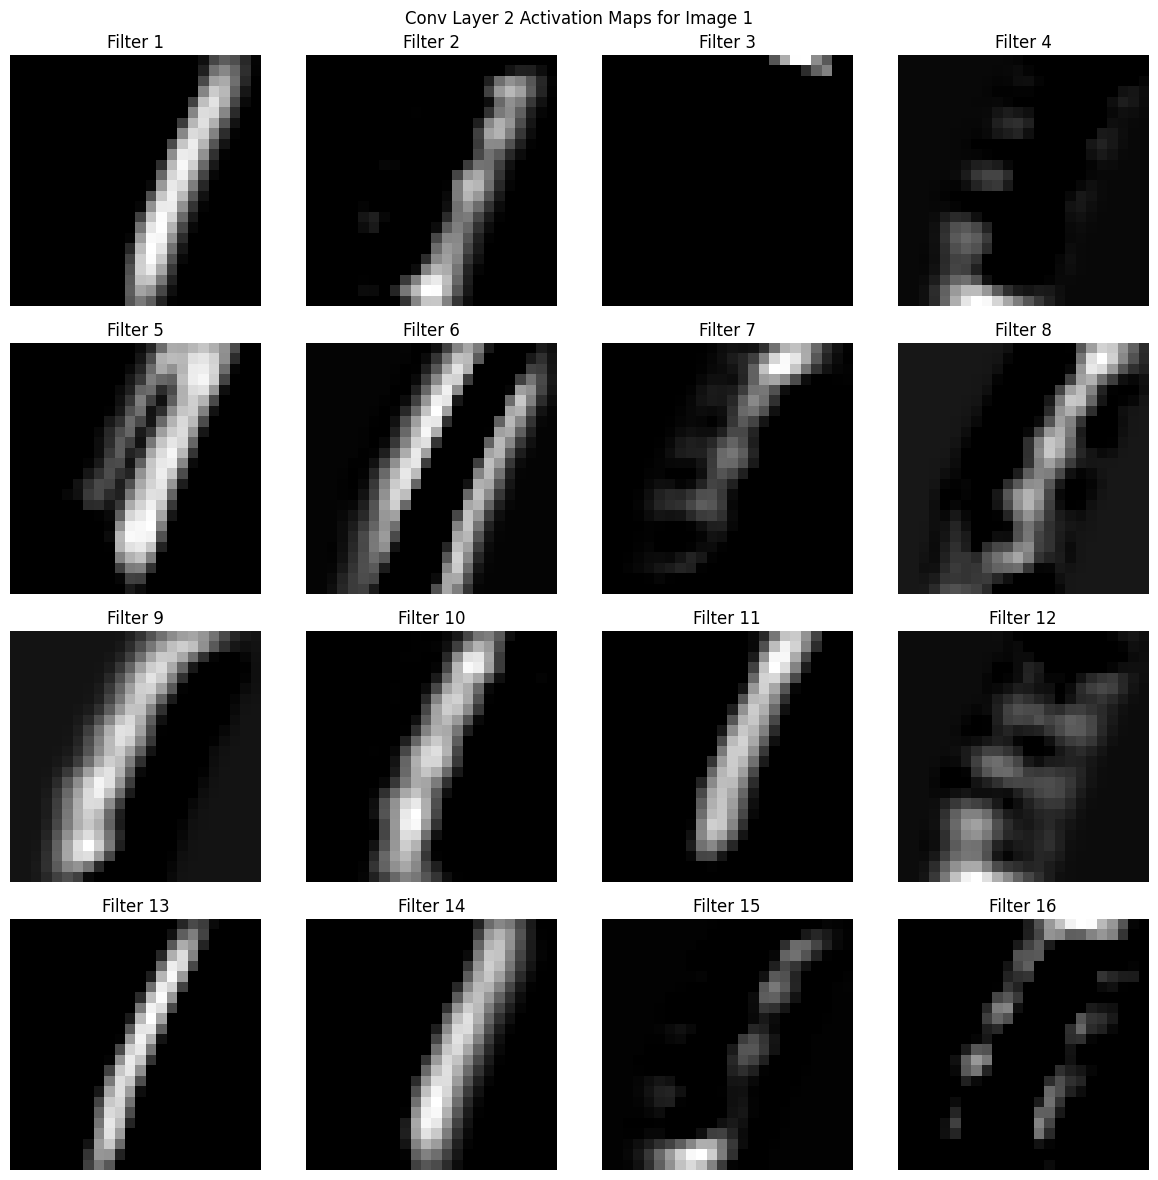

In [ ]:
plot_activation_maps(model, train_loader, num_images=1)

#### Plot of Predicted Probabilities

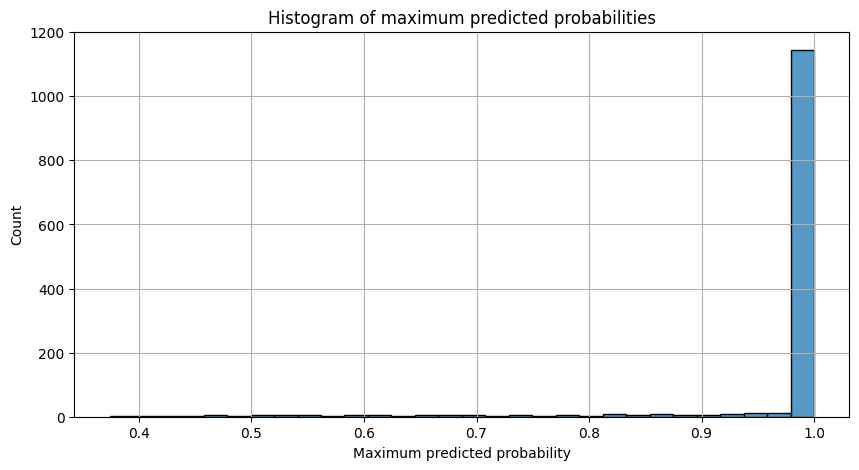

In [ ]:
plot_predicted_probabilities(model, train_loader, num_batches=10)

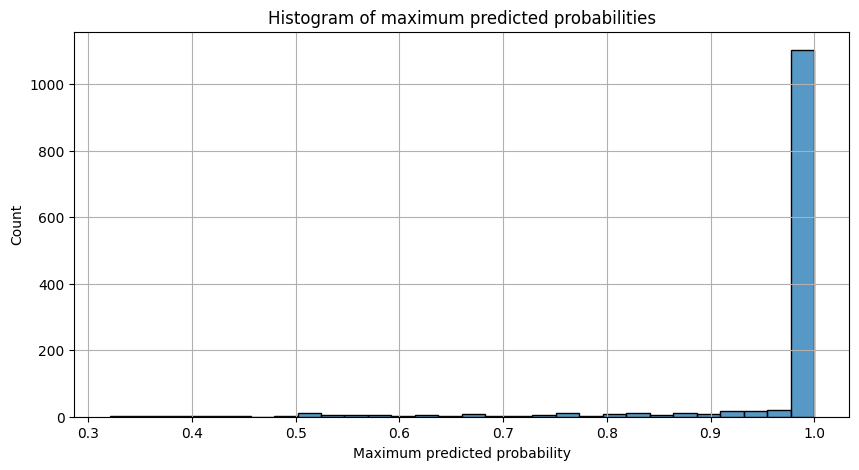

In [ ]:
plot_predicted_probabilities(model, test_loader, num_batches=10)

#### Plot of PCA of Activations

We are taking PCA of the activations (outputs) of each layer, to see how they are distributed. They are distributed in high dimensional space, but we project them down on two principal components. One can use dimensionality reduction techniques like t-SNE or PCA to visualize the activations of the network. This involves taking the activation values of a particular layer and reducing them to 2 or 3 dimensions for plotting. Different classes should ideally form distinct clusters, and overfitting may manifest as overly complex boundaries between classes.

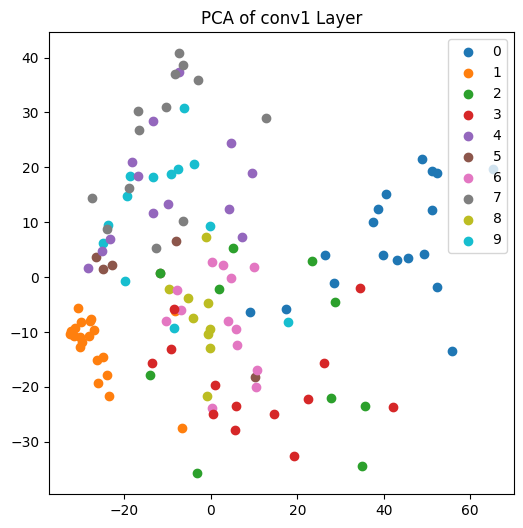

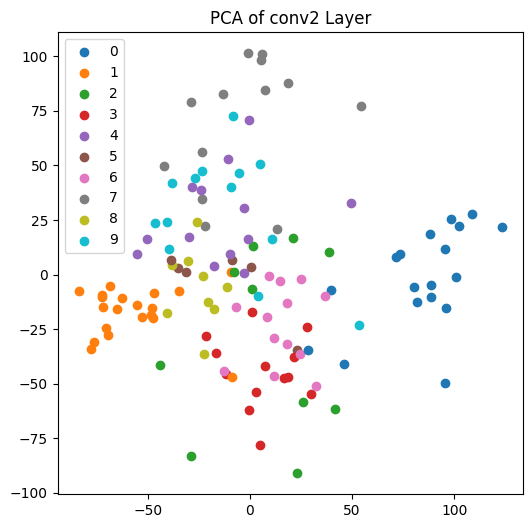

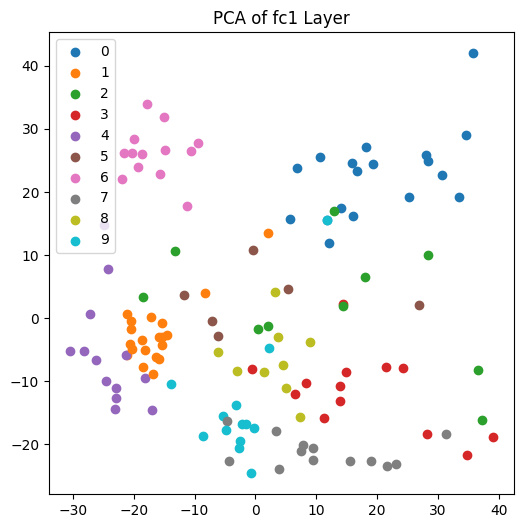

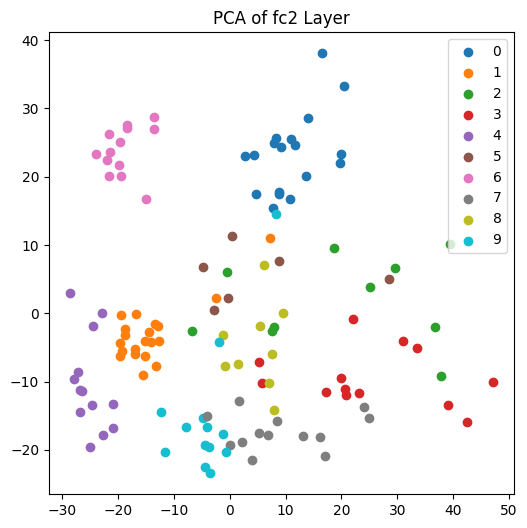

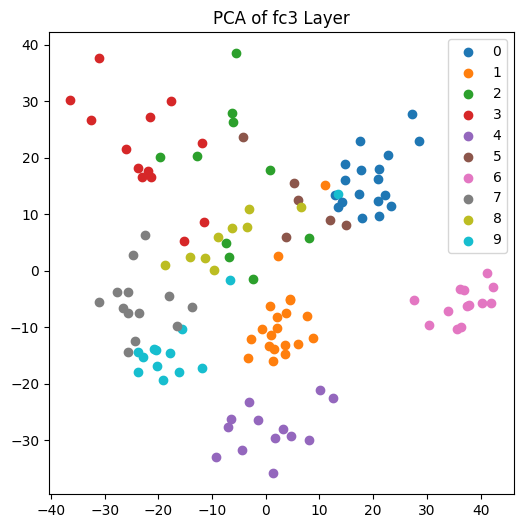

In [ ]:
plot_activations_pca(model, train_loader, device)

#### Plot of t-SNE of Activations

One can use dimensionality reduction techniques like t-SNE or PCA to visualize the activations of the network. This involves taking the activation values of a particular layer and reducing them to 2 or 3 dimensions for plotting. Different classes should ideally form distinct clusters, and overfitting may manifest as overly complex boundaries between classes.

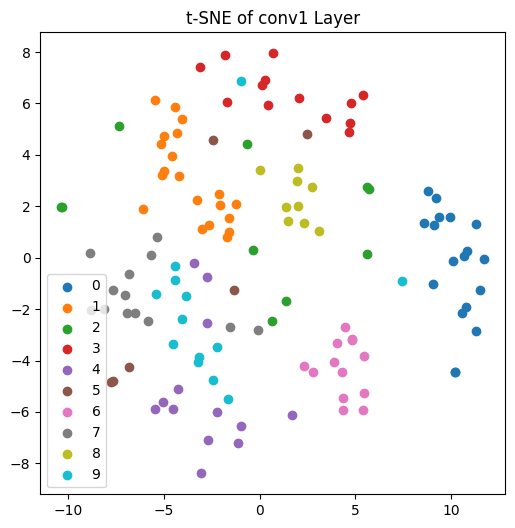

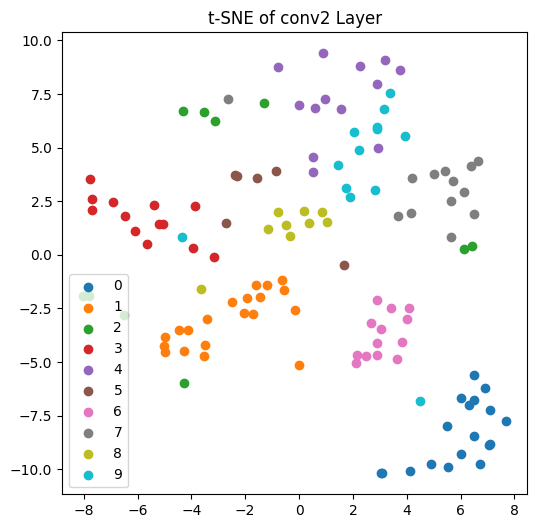

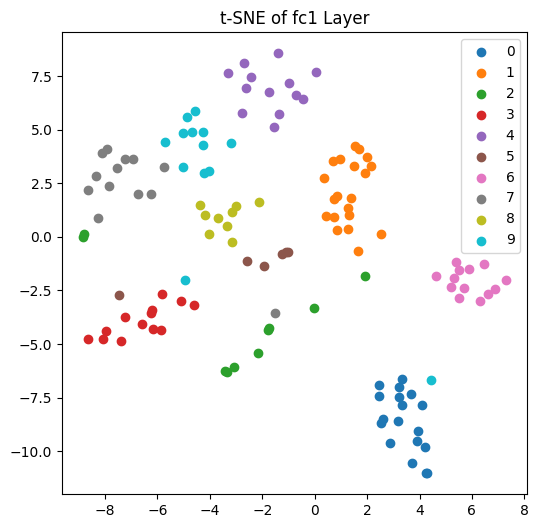

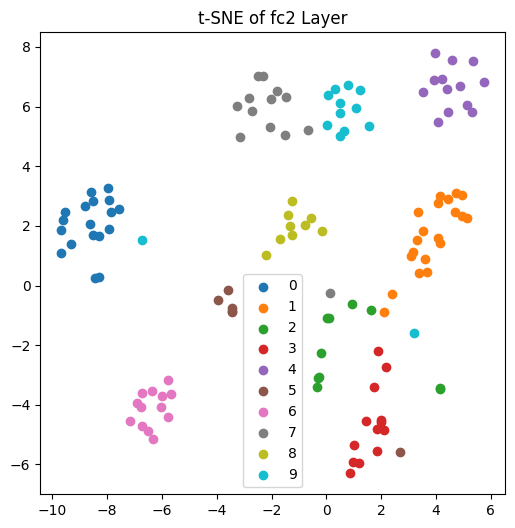

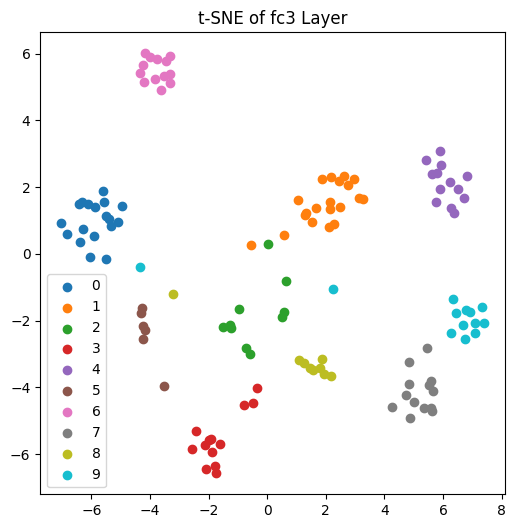

In [ ]:
plot_activations_tsne(model, train_loader, device)

#### Plots of Saliency Maps

A saliency map is a simple, yet effective method for understanding which parts of the image contribute most significantly to a neural network's decision. It is created by calculating the gradient of the output category with respect to the input image. This gradient is then visualized as a heatmap overlaying the original image, with high-gradient regions indicating important areas for the model's decision. The intuition behind this is that the gradient measures how much a small change in each pixel's intensity would affect the final prediction. So, large gradient values suggest important pixels.

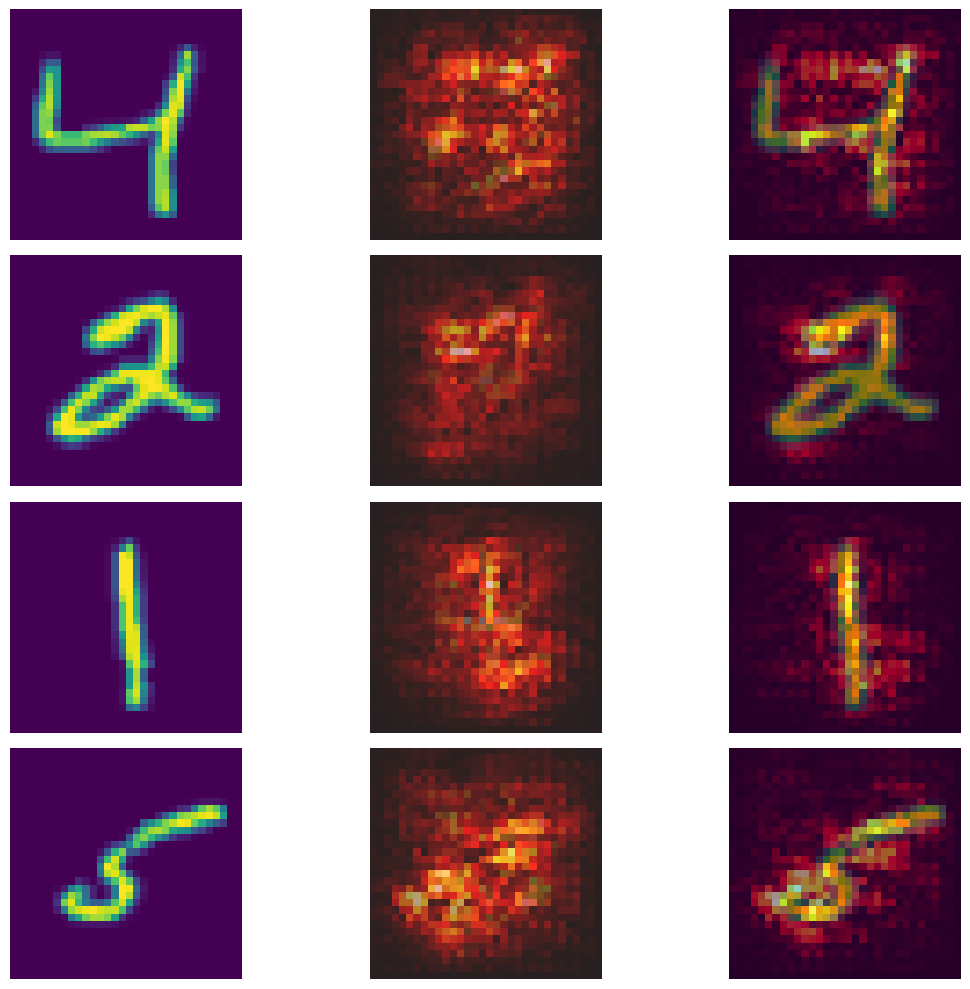

In [ ]:
plot_saliency_maps(model, train_loader, num_images=12)

#### Plots of Occlusion Sensitivity

Occlusion sensitivity is a method that involves systematically occluding different parts of the input image with a grey square (or other "occluder"), and monitoring the effect on the classifier's output. The output is then visualized as a heatmap showing how much the classifier's confidence decreased when each region was occluded, highlighting important regions in the input image for the model's decision. Here, the warmer colour the more important for the classification. A score of 1 means that blocking the area did not change the classification, while 0 means it occluded the prediction.

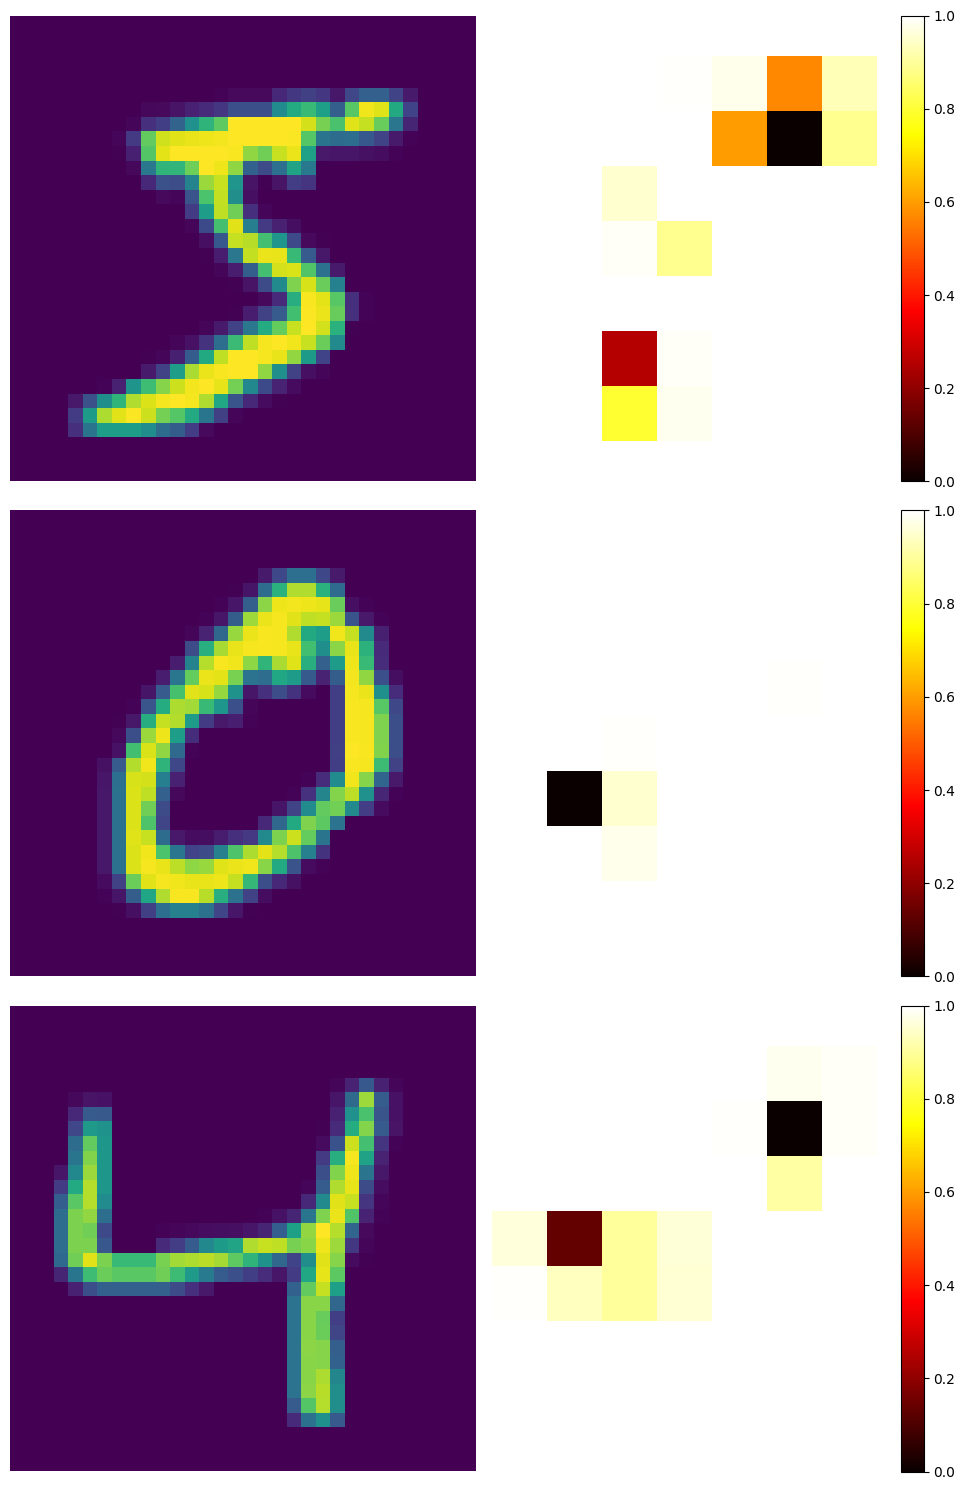

In [ ]:
plot_occlusion_sensitivity(model, train_loader, num_images=3, occluder_size=8, stride=4)

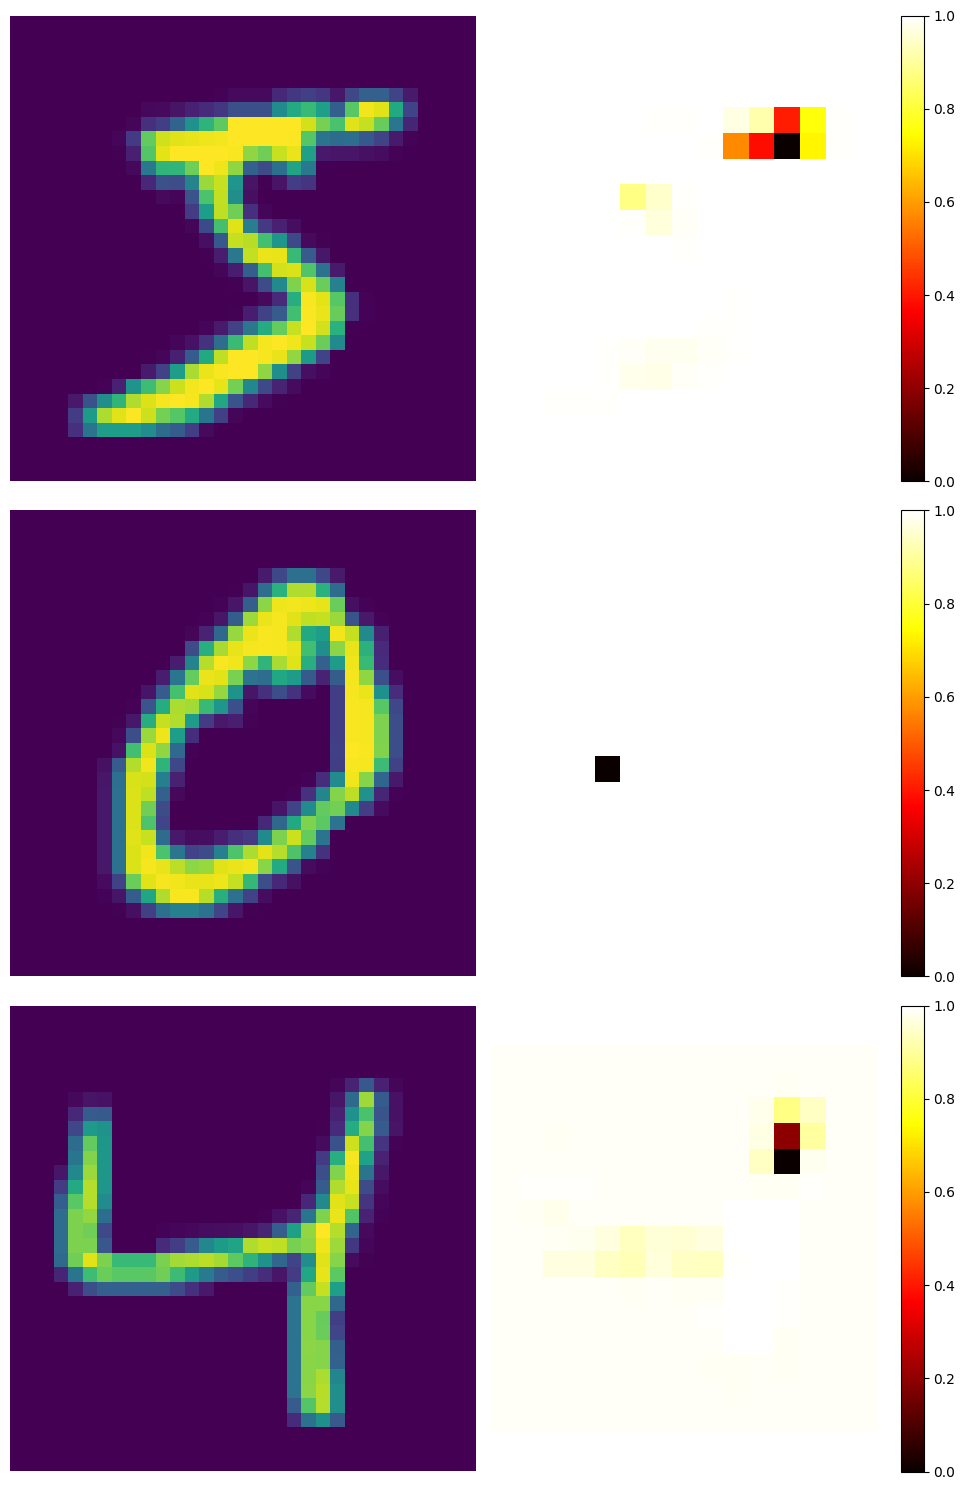

In [ ]:
plot_occlusion_sensitivity(model, train_loader, num_images=3, occluder_size=4, stride=2)

## L1 Regularization

### Training

In [ ]:
model = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
n_epochs = 5
losses, reg_losses, epochs, weights, train_accuracies, test_accuracies = train(
    train_loader, test_loader, model, n_epochs, l1=True, l1_lmbd=0.001
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0


 20%|██        | 1/5 [00:27<01:48, 27.24s/it]

Accuracy of the network on the test images: 51 %
Epoch: 1


 40%|████      | 2/5 [00:54<01:21, 27.32s/it]

Accuracy of the network on the test images: 78 %
Epoch: 2


 60%|██████    | 3/5 [01:23<00:56, 28.16s/it]

Accuracy of the network on the test images: 81 %
Epoch: 3


 80%|████████  | 4/5 [01:51<00:27, 27.93s/it]

Accuracy of the network on the test images: 83 %
Epoch: 4


100%|██████████| 5/5 [02:20<00:00, 28.18s/it]

Accuracy of the network on the test images: 84 %


### Visualization

#### Plot of Losses and Accuracies

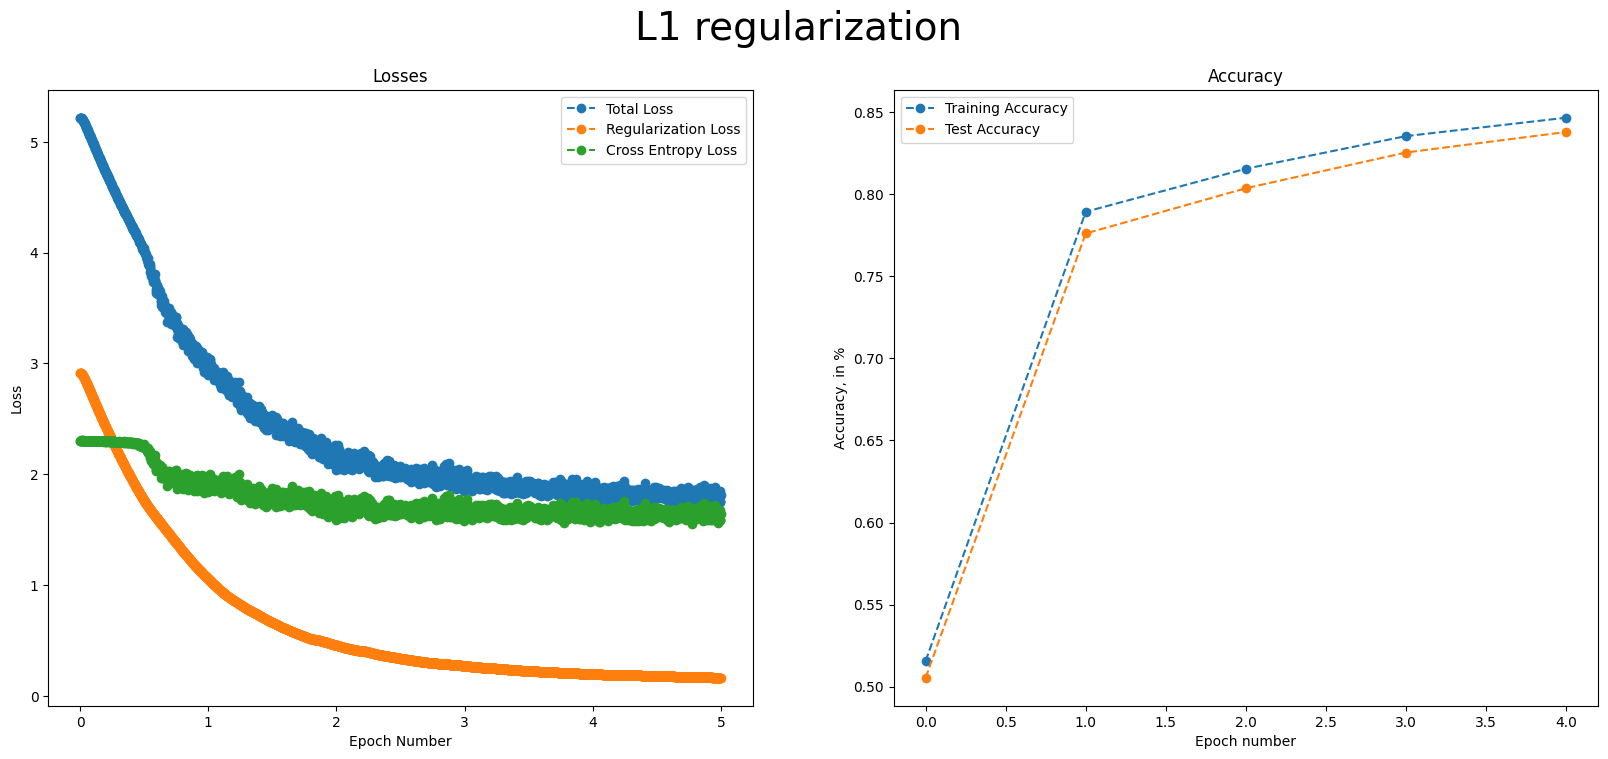

In [ ]:
plot_reg_results(
    epochs,
    losses,
    reg_losses,
    train_accuracies,
    test_accuracies,
    title="L1 regularization",
)

#### Plot of Weight Distributions

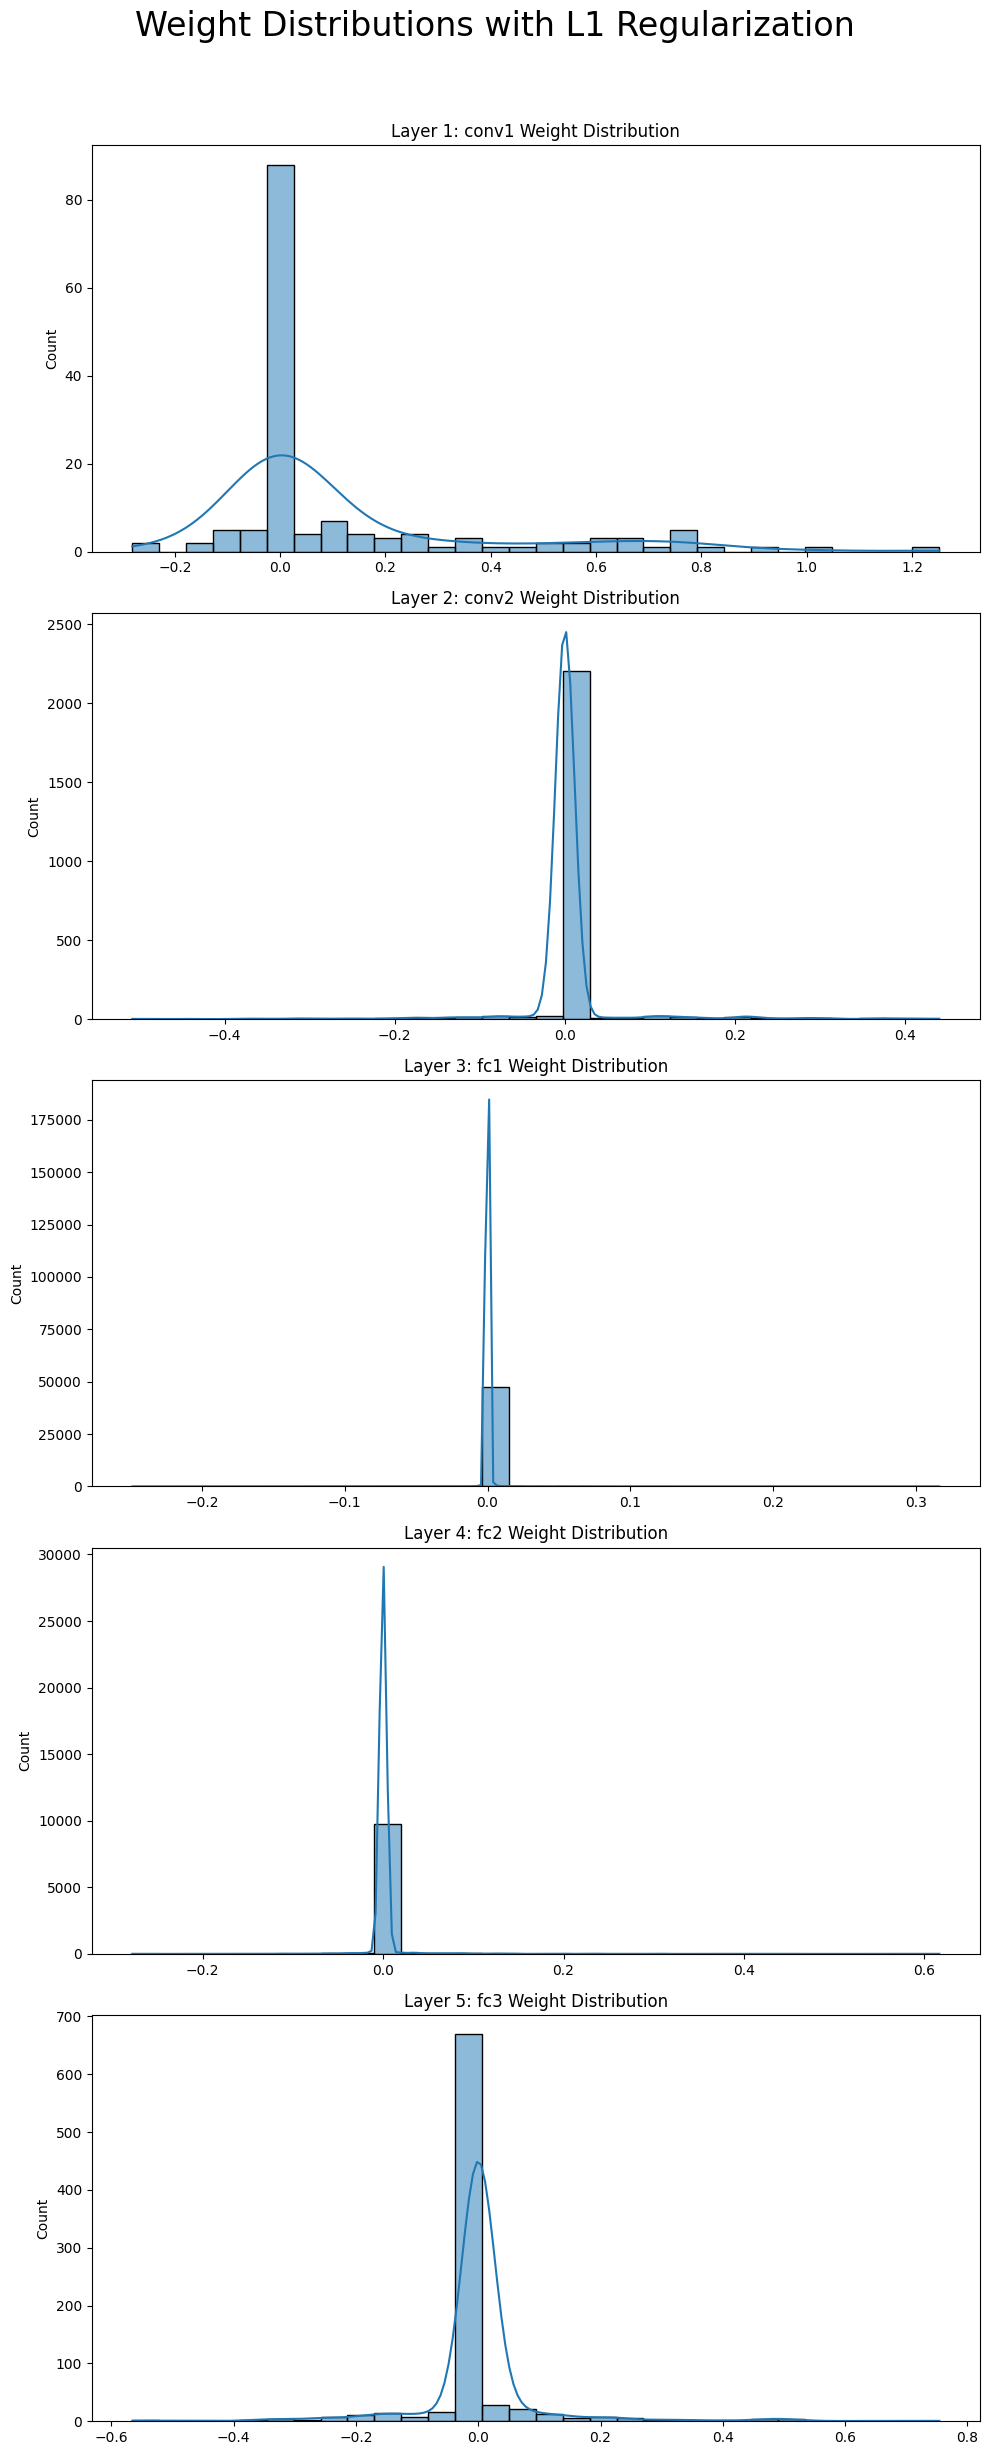

In [ ]:
plot_weight_distributions(model, title="Weight Distributions with L1 Regularization")

#### Plots of Activation Maps

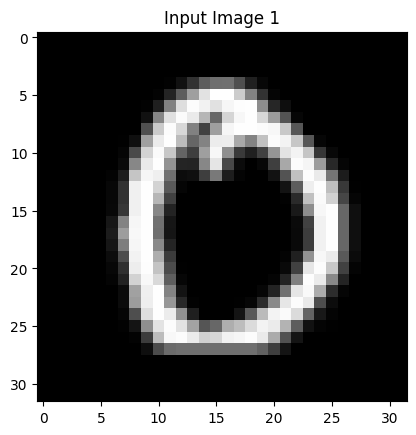

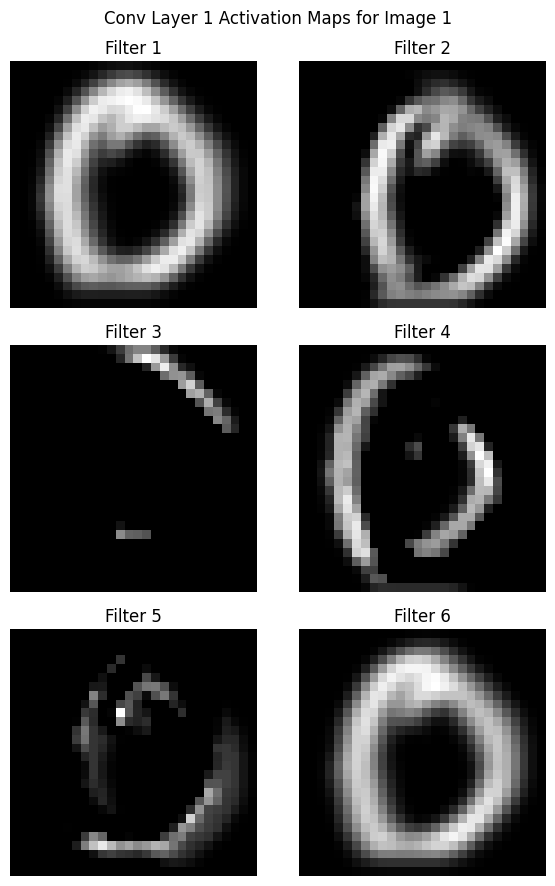

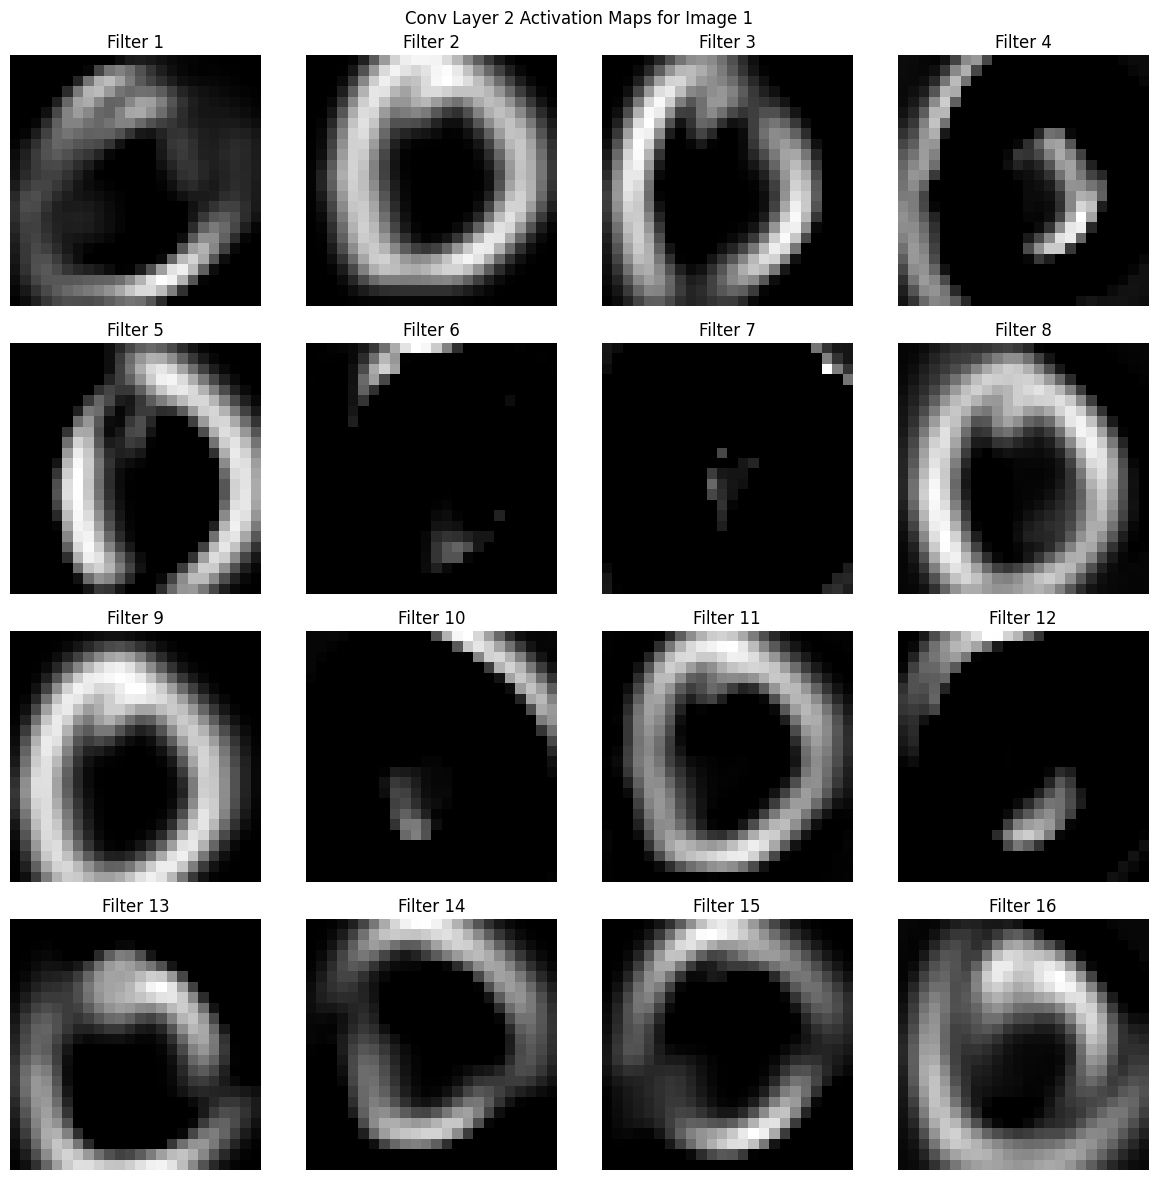

In [ ]:
plot_activation_maps(model, train_loader, num_images=1)

#### Plot of Predicted Probabilities

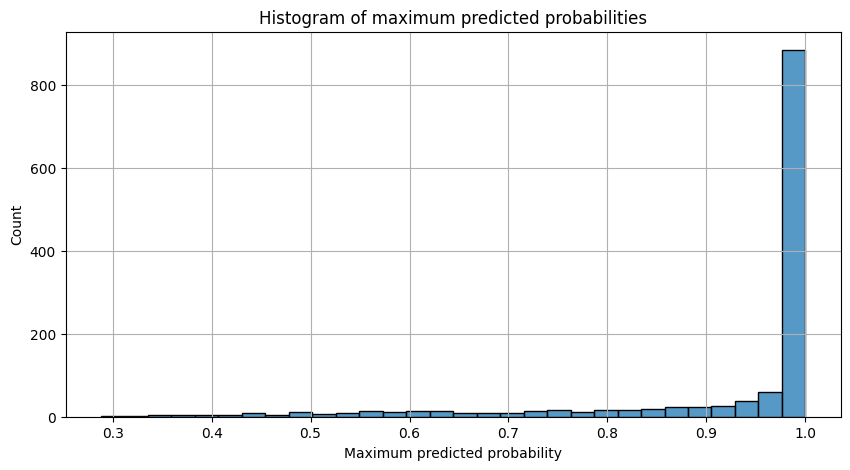

In [ ]:
plot_predicted_probabilities(model, train_loader, num_batches=10)

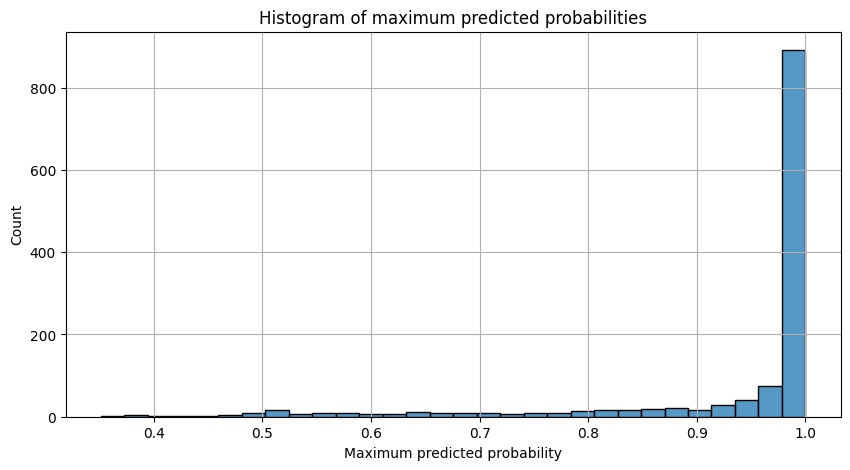

In [ ]:
plot_predicted_probabilities(model, test_loader, num_batches=10)

#### Plot of PCA of Activations

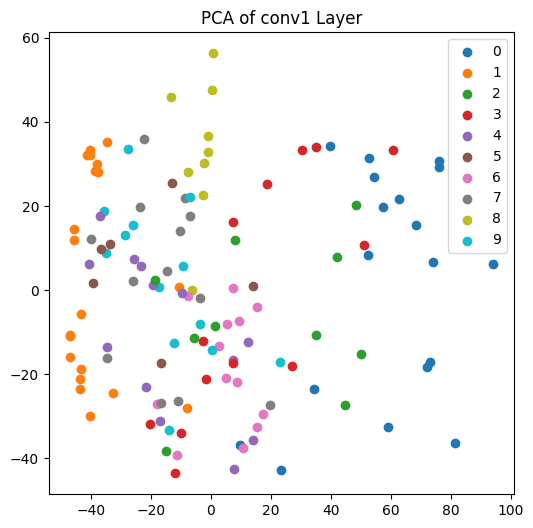

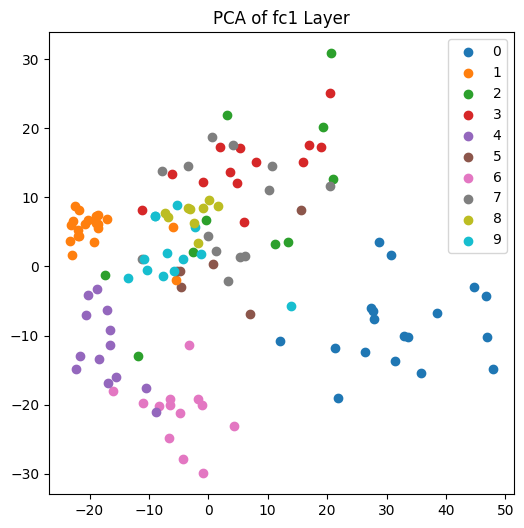

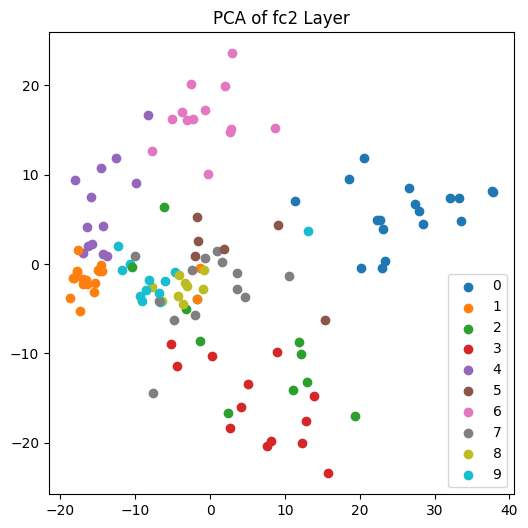

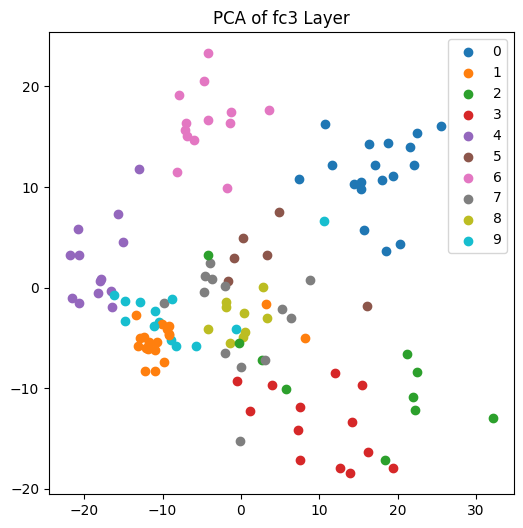

In [ ]:
plot_activations_pca(model, train_loader, device)

#### Plot of t-SNE of Activations

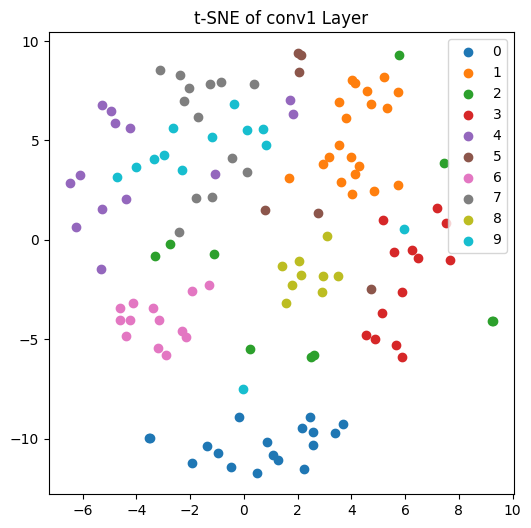

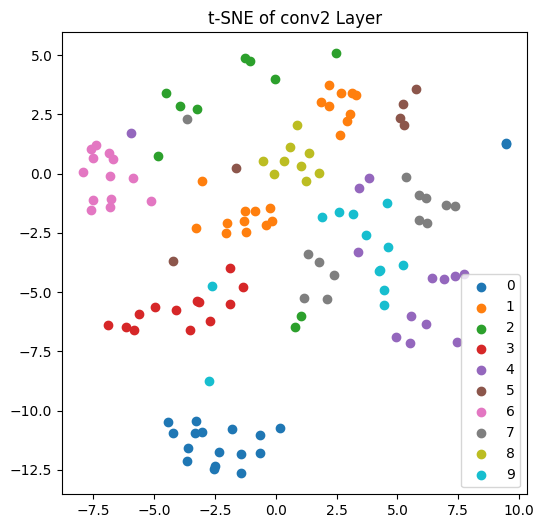

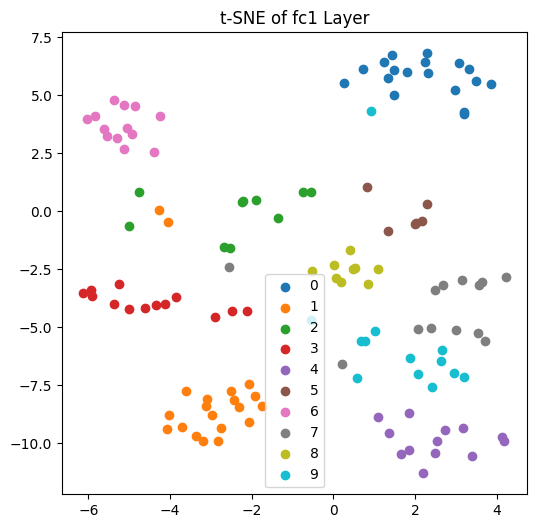

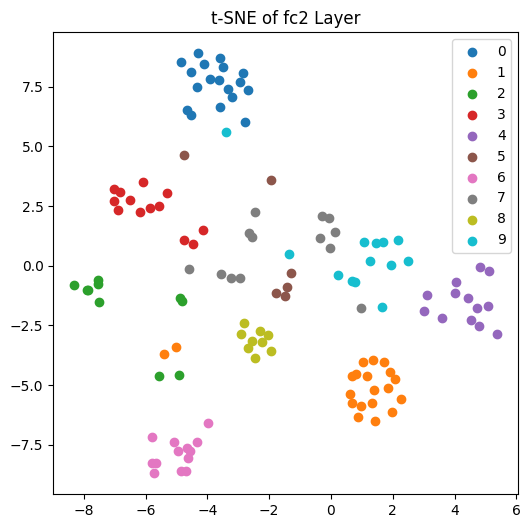

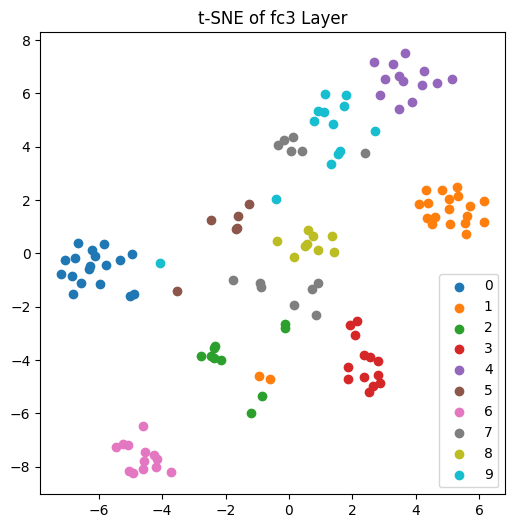

In [ ]:
plot_activations_tsne(model, train_loader, device)

#### Plots of Saliency Maps

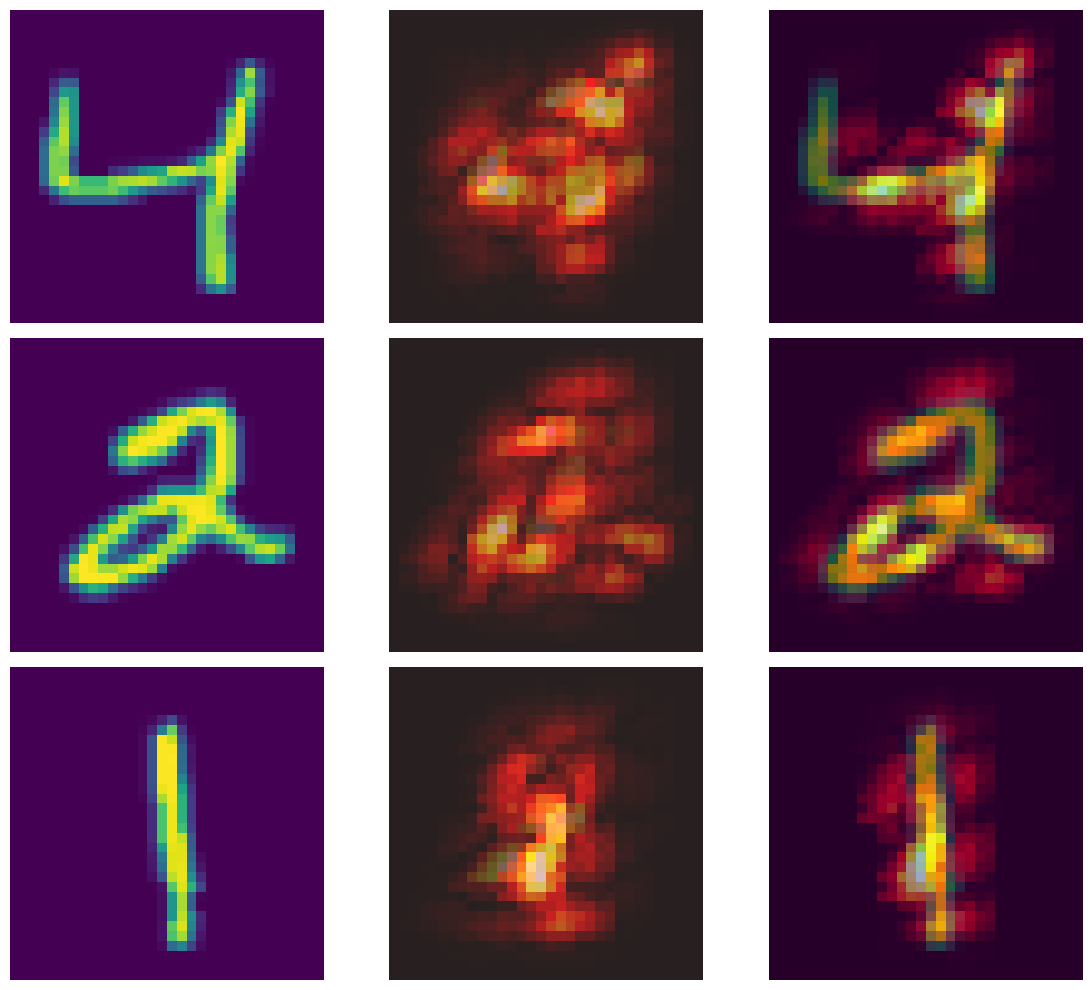

In [ ]:
plot_saliency_maps(model, train_loader, num_images=9)

#### Plots of Occlusion Sensitivity

In [ ]:
plot_occlusion_sensitivity(model, train_loader, num_images=3, occluder_size=8, stride=4)

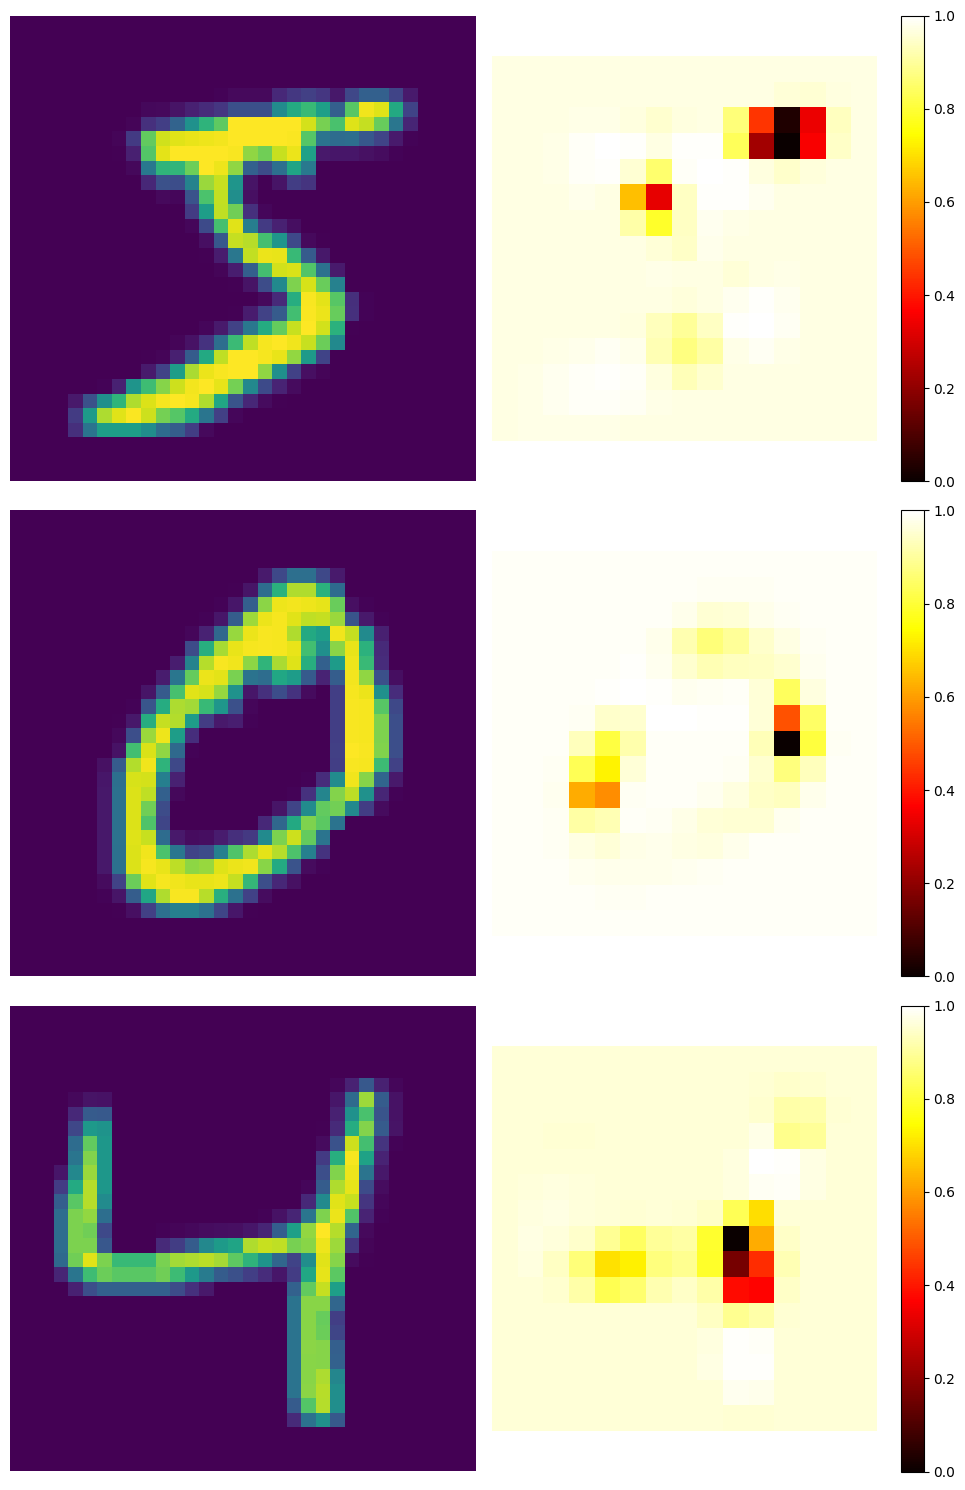

In [ ]:
plot_occlusion_sensitivity(model, train_loader, num_images=3, occluder_size=4, stride=2)

## L2 Regularization

### Training

In [ ]:
model = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
n_epochs = 5
losses, reg_losses, epochs, weights, train_accuracies, test_accuracies = train(
    train_loader, test_loader, model, n_epochs, l2=True, l2_lmbd=0.01
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0


 20%|██        | 1/5 [00:27<01:48, 27.18s/it]

Accuracy of the network on the test images: 79 %
Epoch: 1


 40%|████      | 2/5 [00:52<01:18, 26.27s/it]

Accuracy of the network on the test images: 90 %
Epoch: 2


 60%|██████    | 3/5 [01:18<00:52, 26.19s/it]

Accuracy of the network on the test images: 91 %
Epoch: 3


 80%|████████  | 4/5 [01:46<00:26, 26.68s/it]

Accuracy of the network on the test images: 92 %
Epoch: 4


100%|██████████| 5/5 [02:14<00:00, 26.81s/it]

Accuracy of the network on the test images: 93 %


### Visualization

#### Plot of Losses and Accuracies

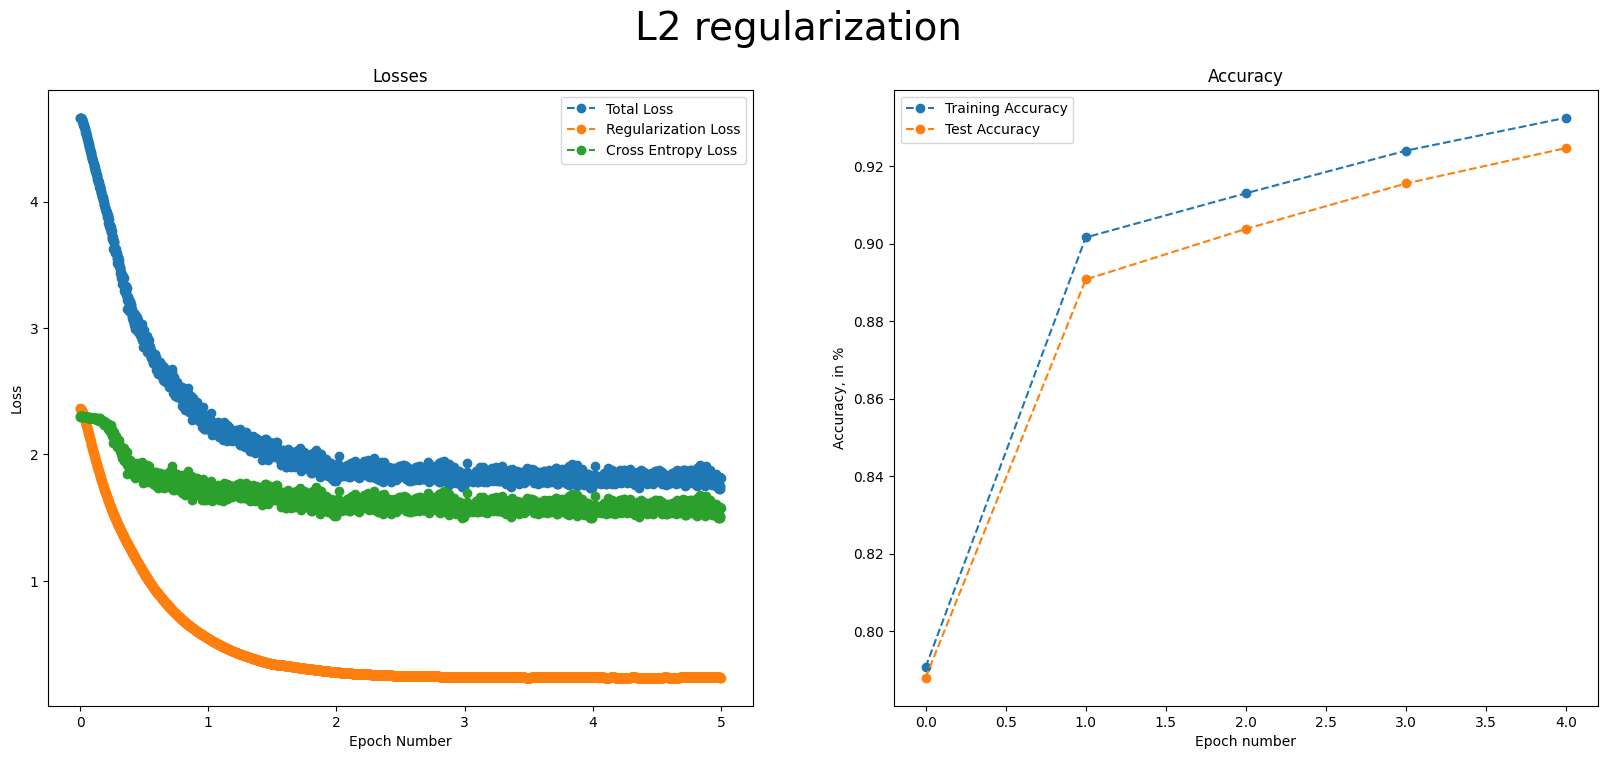

In [ ]:
plot_reg_results(
    epochs,
    losses,
    reg_losses,
    train_accuracies,
    test_accuracies,
    title="L2 regularization",
)

#### Plot of Weight Distributions

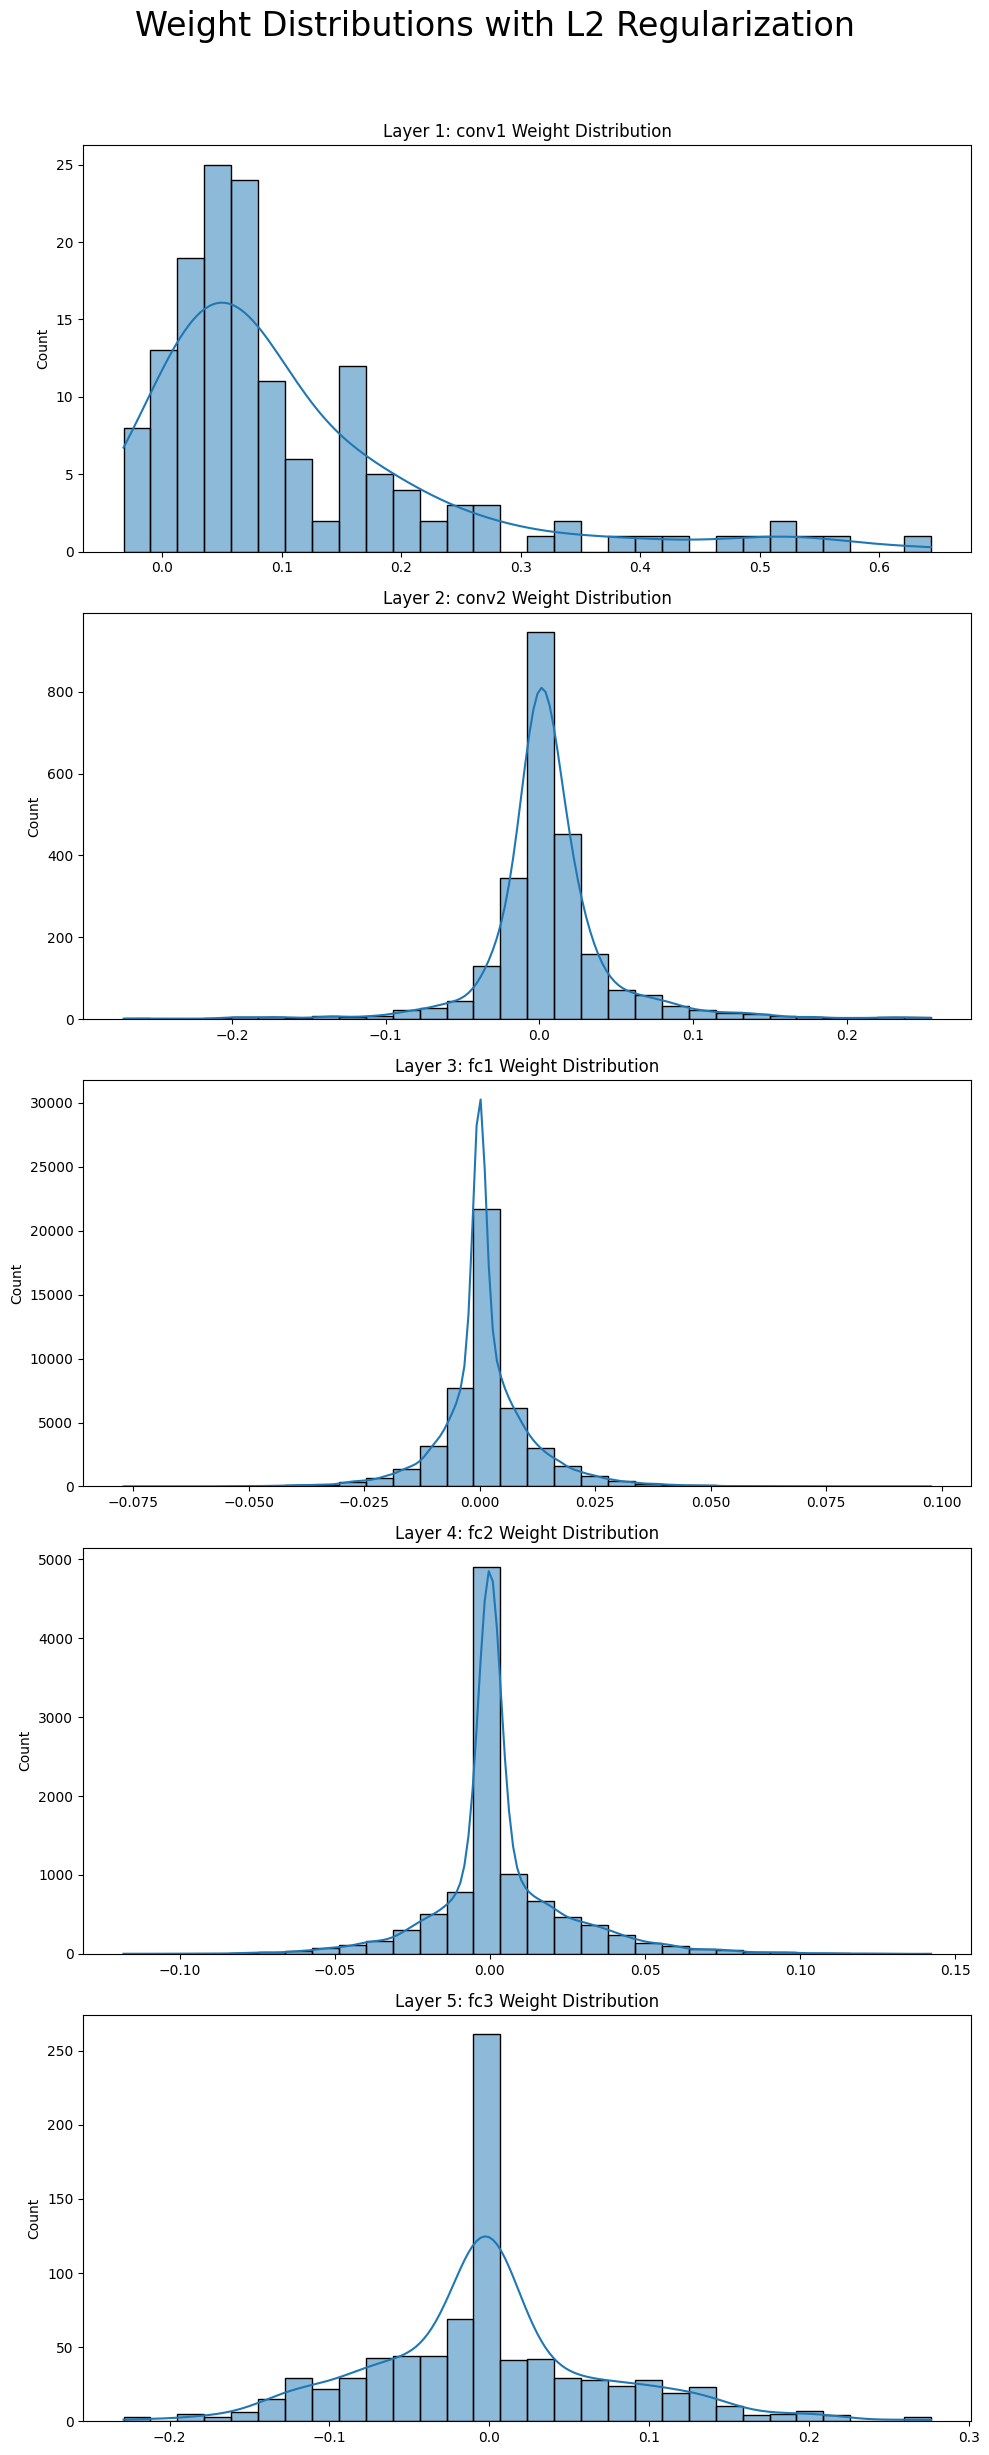

In [ ]:
plot_weight_distributions(model, title="Weight Distributions with L2 Regularization")

#### Plots of Activation Maps

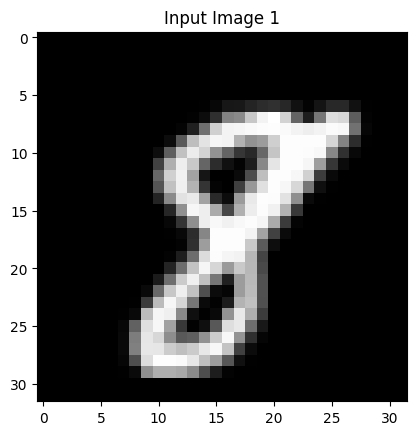

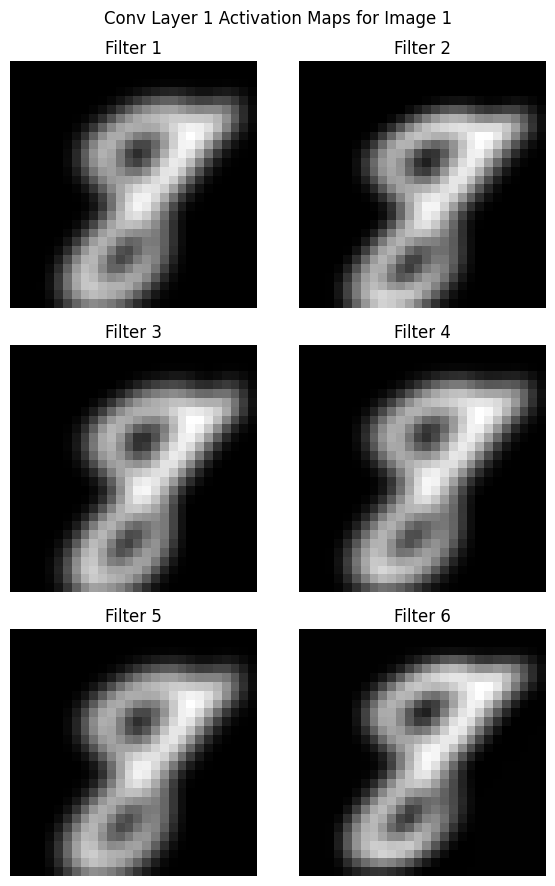

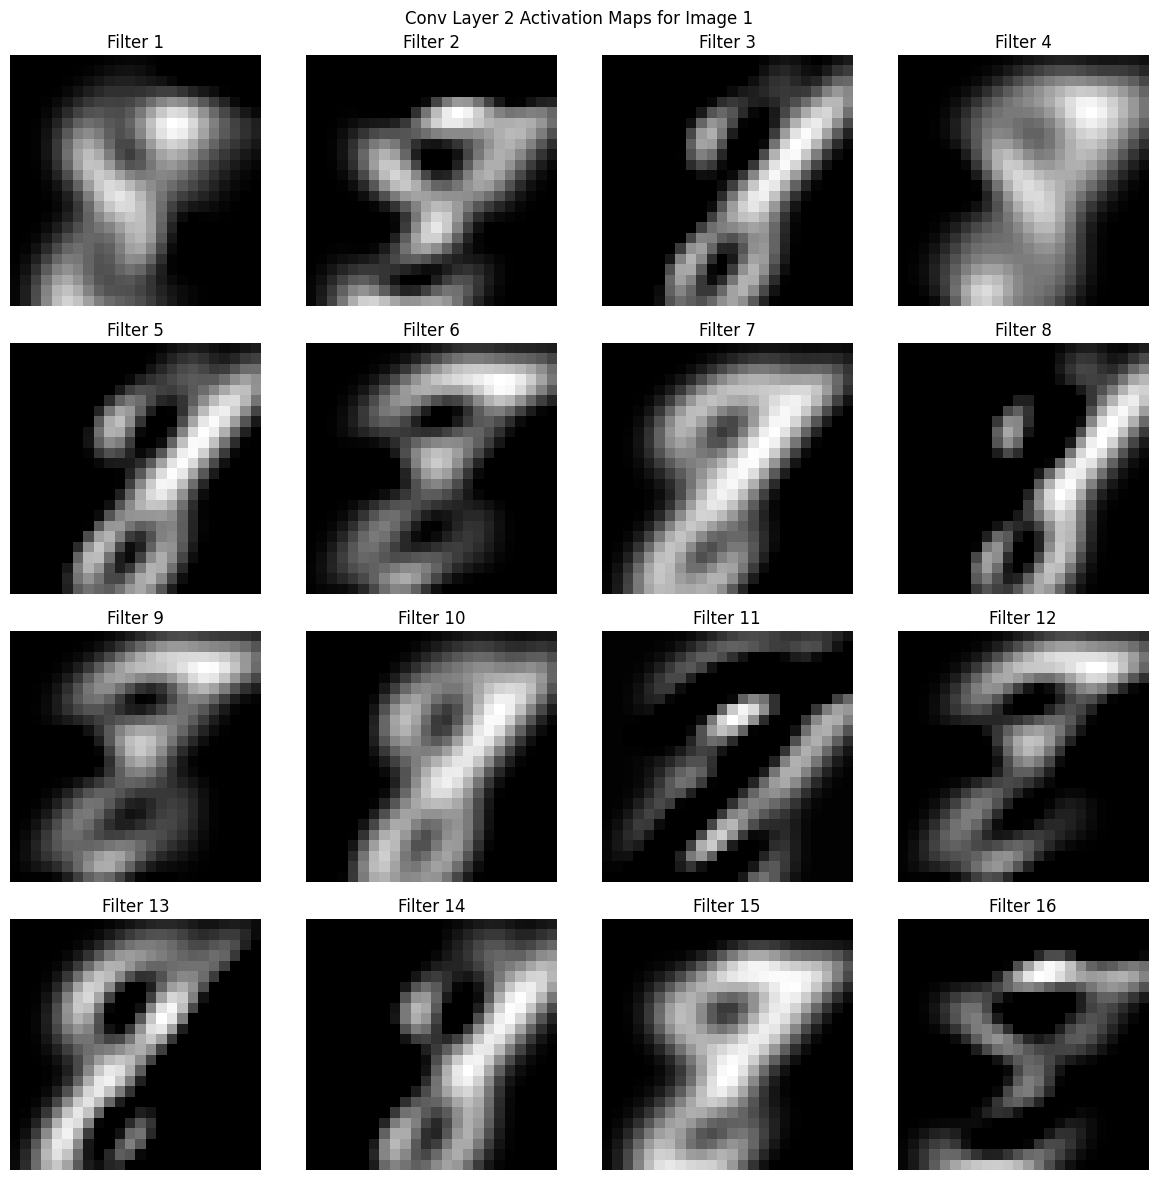

In [ ]:
plot_activation_maps(model, train_loader, num_images=1)

#### Plot of Predicted Probabilities

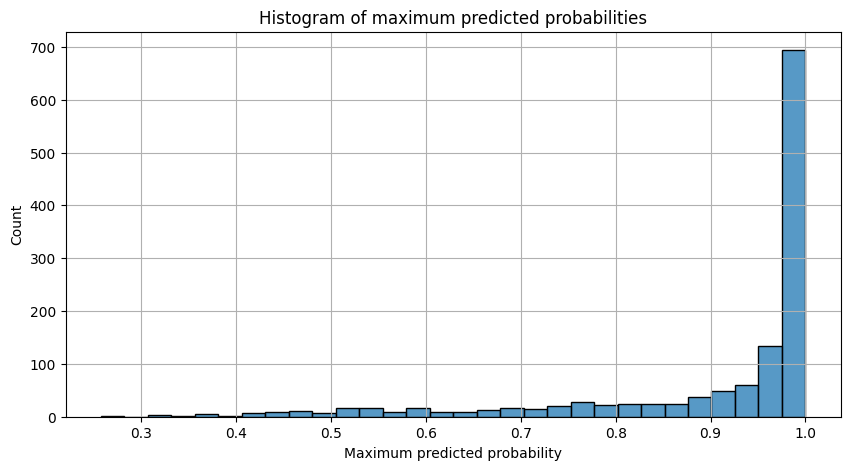

In [ ]:
plot_predicted_probabilities(model, train_loader, num_batches=10)

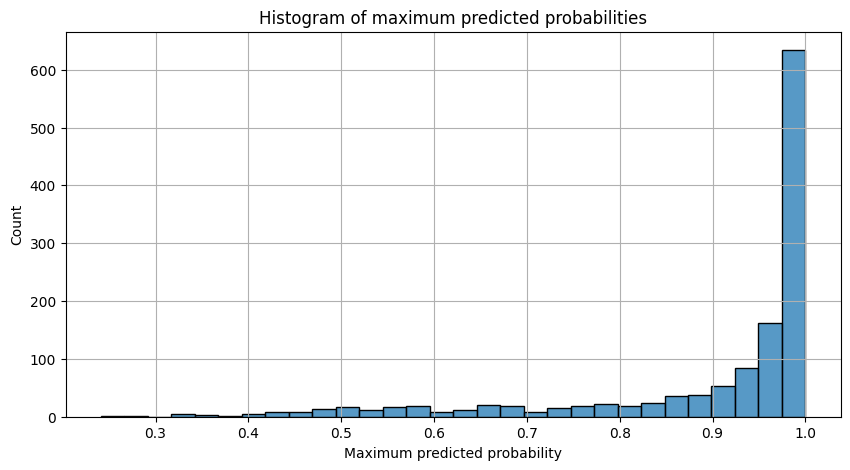

In [ ]:
plot_predicted_probabilities(model, test_loader, num_batches=10)

#### Plot of PCA of Activations

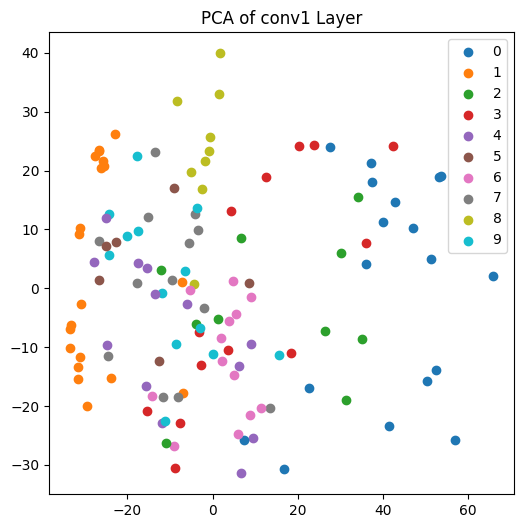

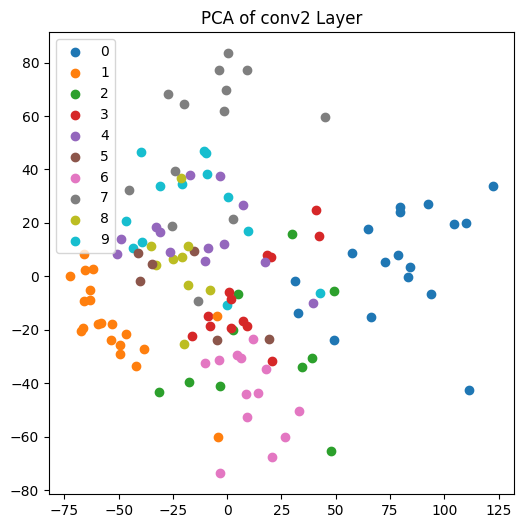

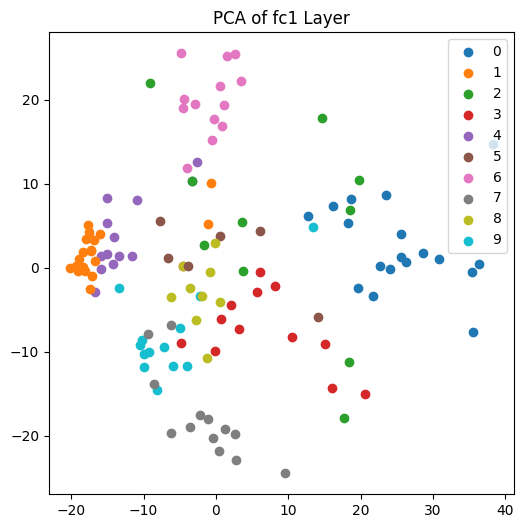

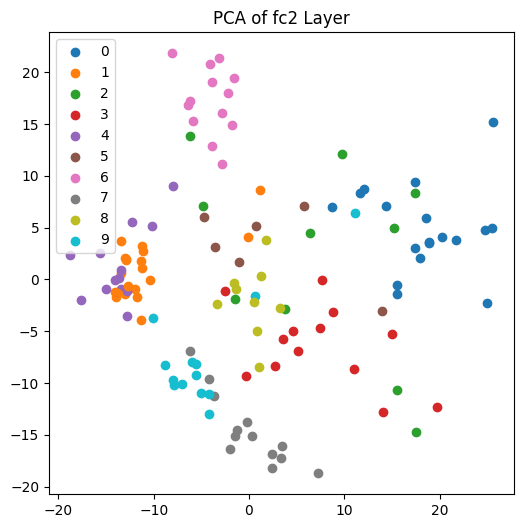

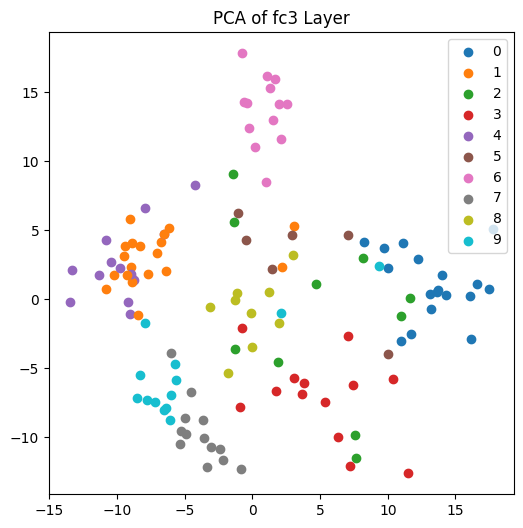

In [ ]:
plot_activations_pca(model, train_loader, device)

#### Plot t-SNE of Activations

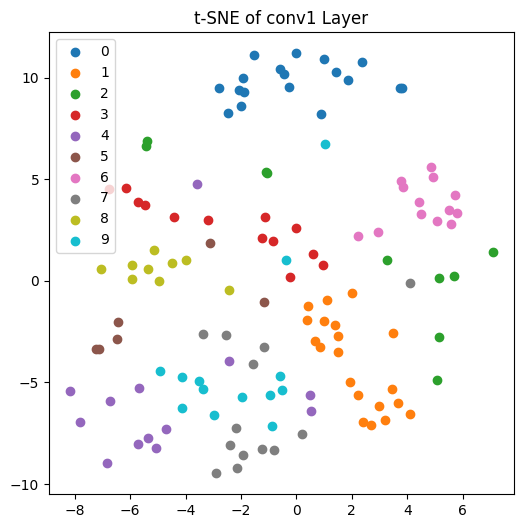

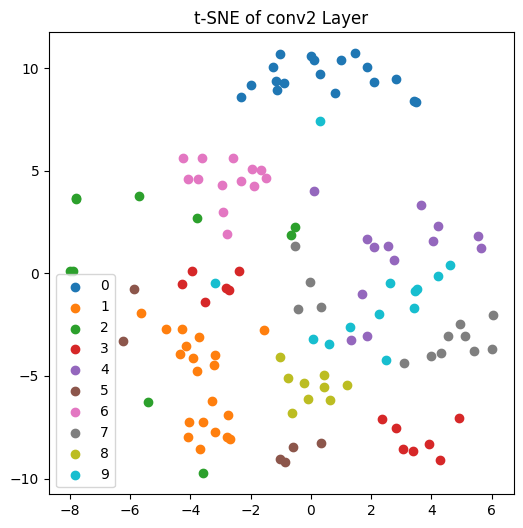

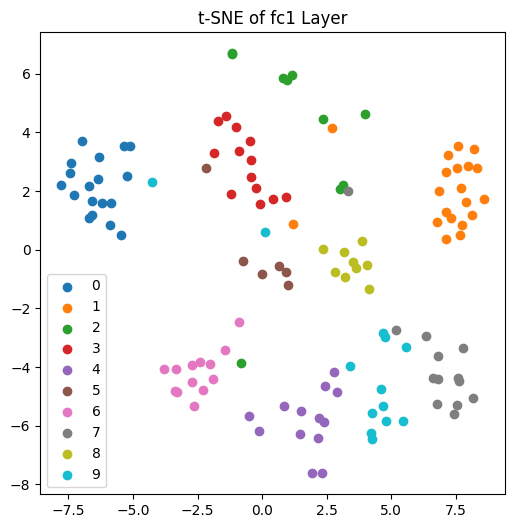

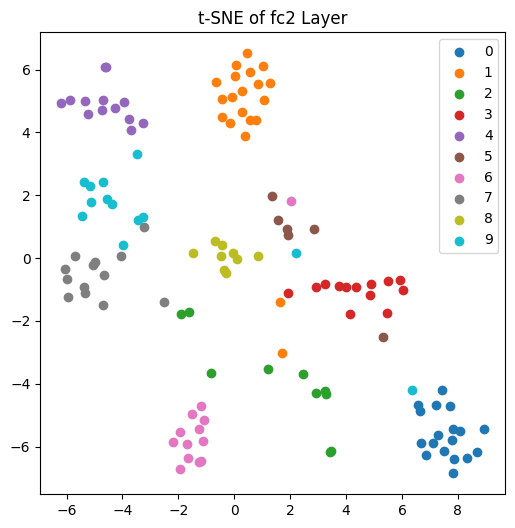

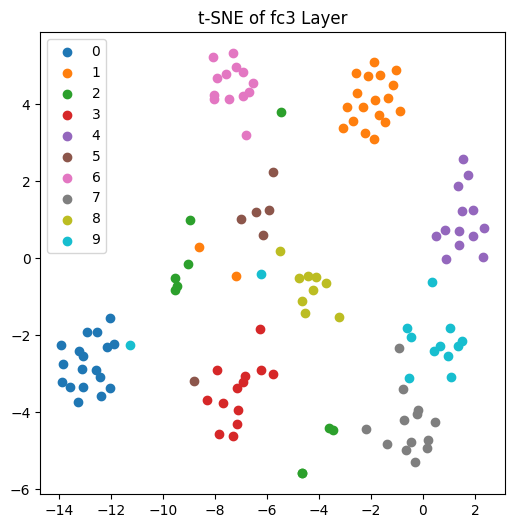

In [ ]:
plot_activations_tsne(model, train_loader, device)

#### Plots of Saliency Maps

In [ ]:
plot_saliency_maps(model, train_loader, num_images=9)

#### Plots of Occlusion Sensitivity

In [ ]:
plot_occlusion_sensitivity(model, train_loader, num_images=3, occluder_size=8, stride=4)

In [ ]:
plot_occlusion_sensitivity(model, train_loader, num_images=3, occluder_size=4, stride=2)

## Elastic Net Regularization (L1 and L2)

### Training

In [ ]:
model = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
n_epochs = 5
losses, reg_losses, epochs, weights, train_accuracies, test_accuracies = train(
    train_loader,
    test_loader,
    model,
    n_epochs,
    l1=True,
    l1_lmbd=0.001,
    l2=True,
    l2_lmbd=0.001,
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0


 20%|██        | 1/5 [00:26<01:47, 26.85s/it]

Accuracy of the network on the test images: 81 %
Epoch: 1


 40%|████      | 2/5 [00:53<01:20, 26.95s/it]

Accuracy of the network on the test images: 82 %
Epoch: 2


 60%|██████    | 3/5 [01:20<00:53, 26.95s/it]

Accuracy of the network on the test images: 89 %
Epoch: 3


 80%|████████  | 4/5 [01:47<00:26, 26.97s/it]

Accuracy of the network on the test images: 91 %
Epoch: 4


100%|██████████| 5/5 [02:15<00:00, 27.01s/it]

Accuracy of the network on the test images: 92 %


### Visualization

#### Plot of Losses and Accuracies

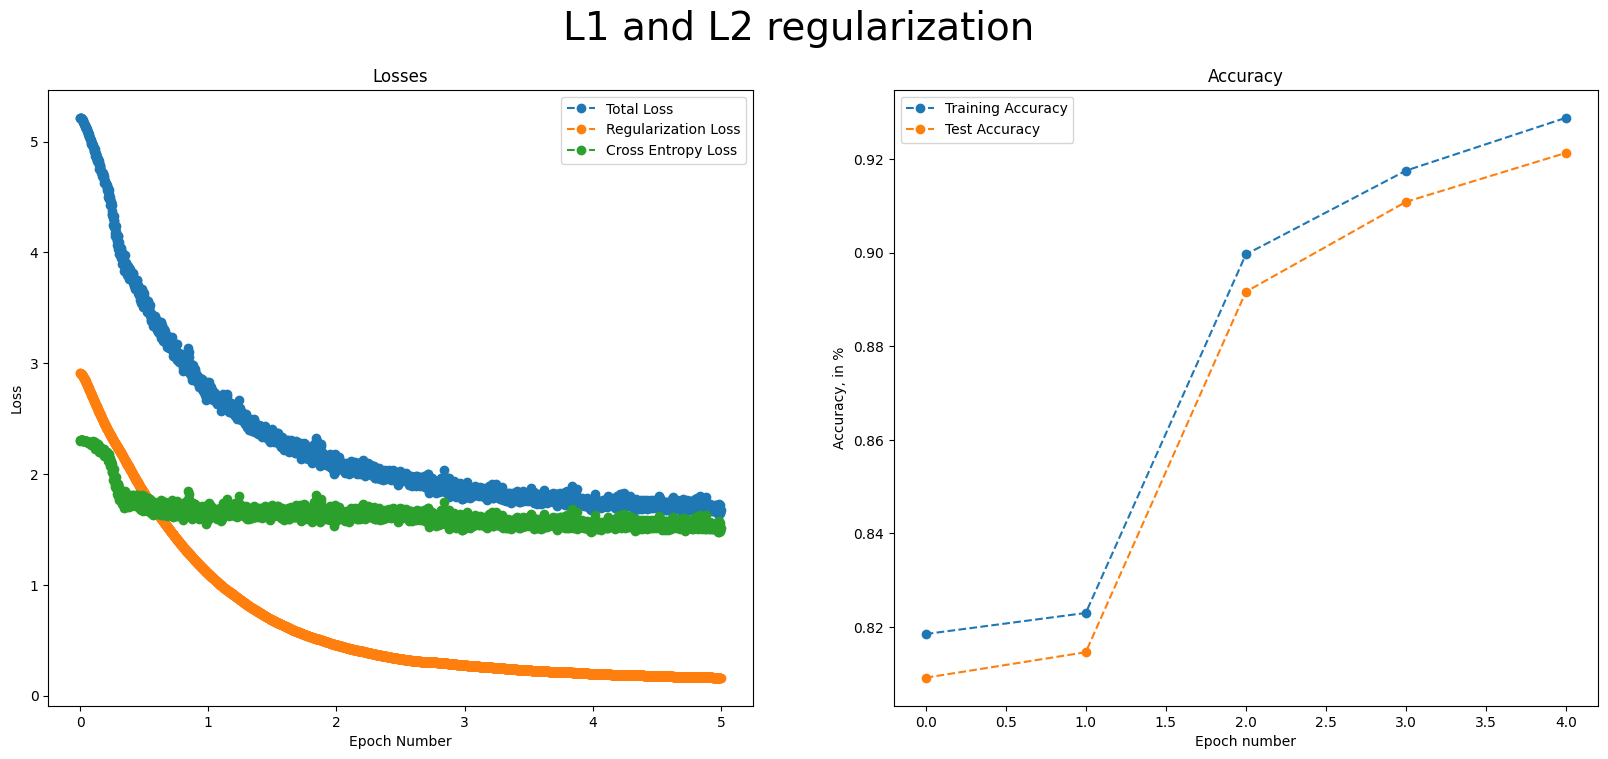

In [ ]:
plot_reg_results(
    epochs,
    losses,
    reg_losses,
    train_accuracies,
    test_accuracies,
    title="L1 and L2 regularization",
)

#### Plot of Weight Distributions

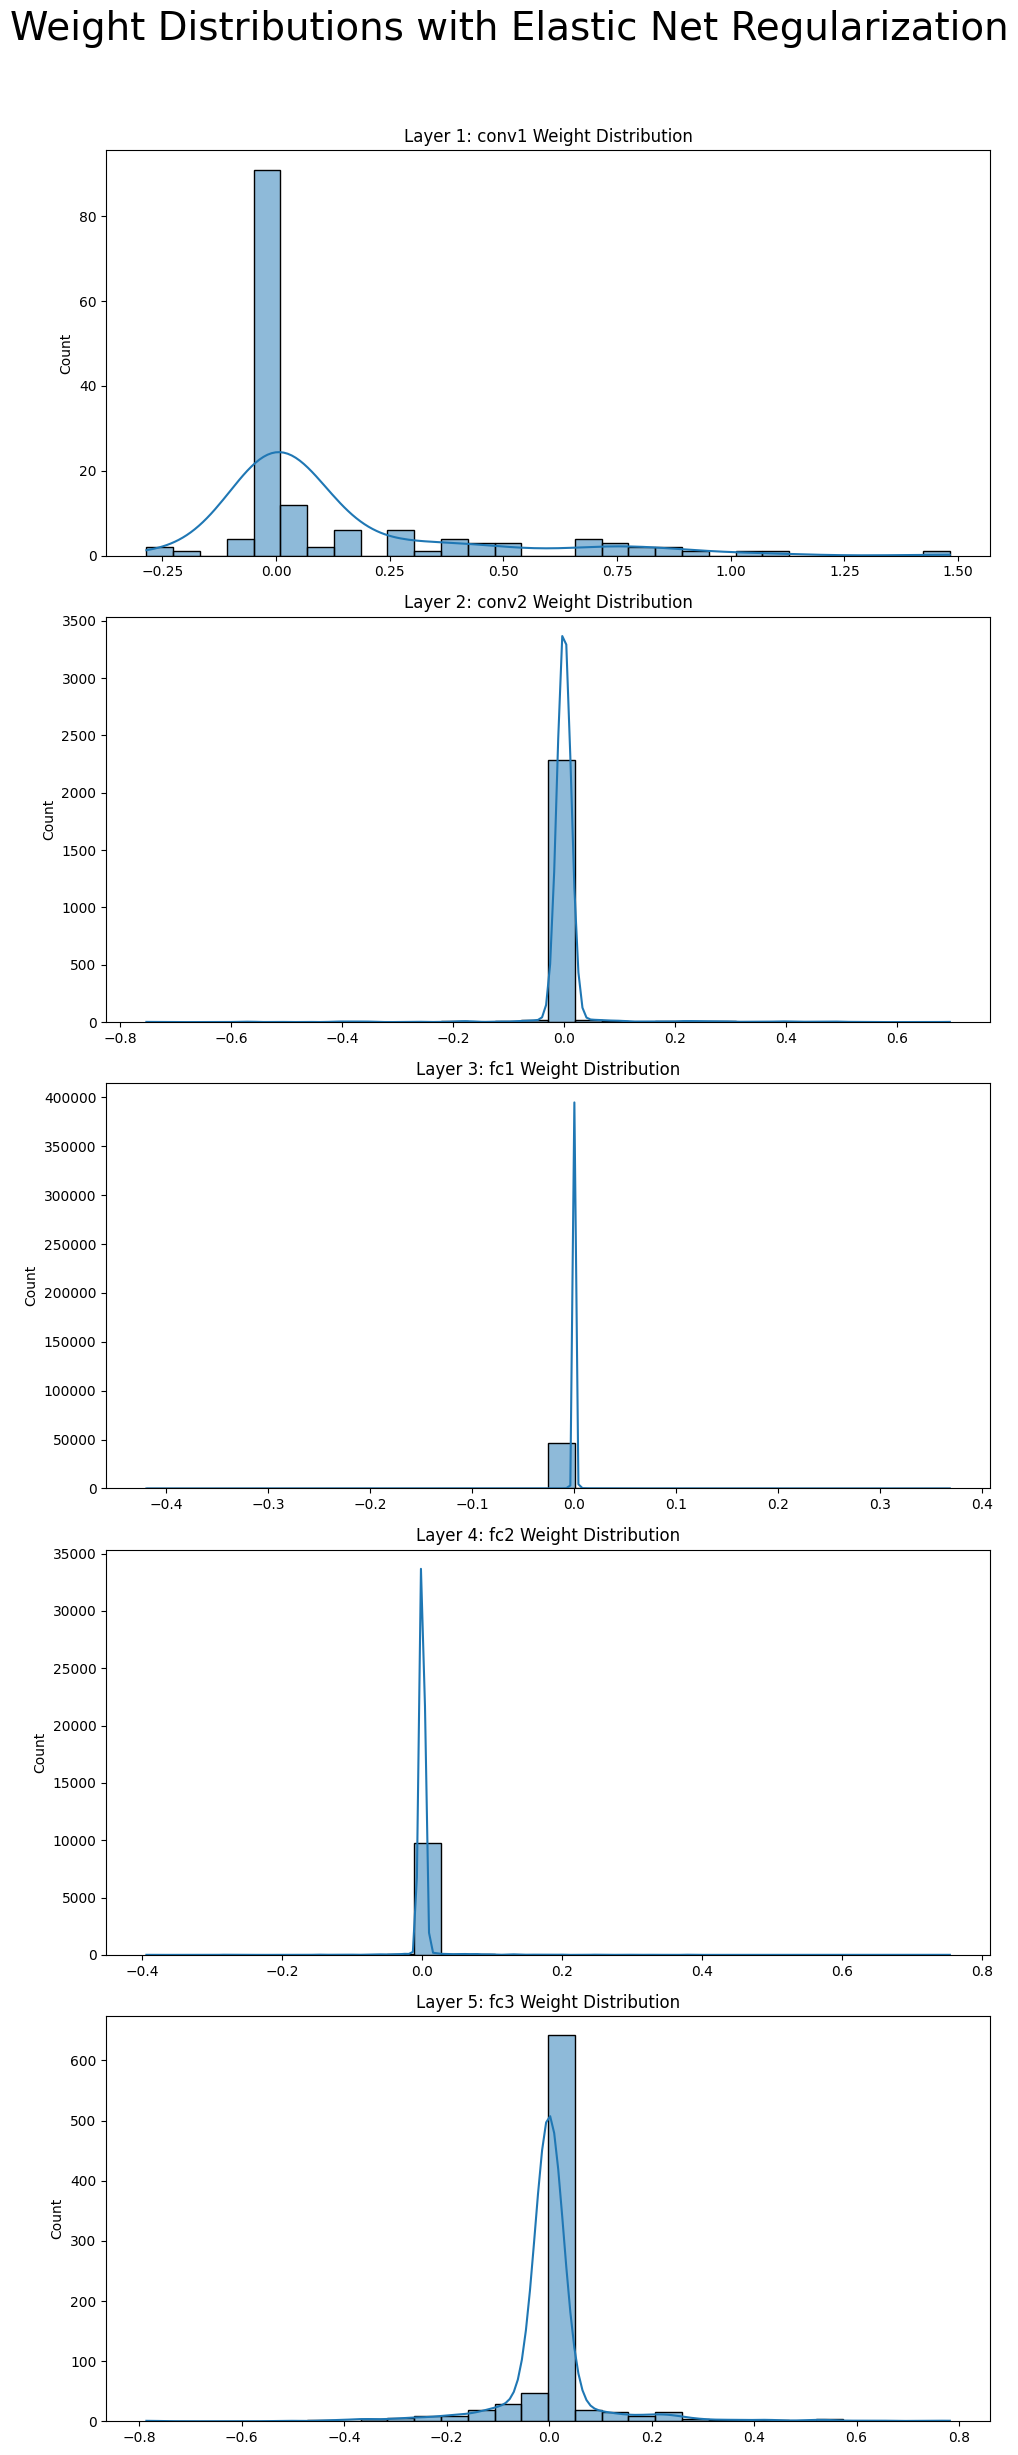

In [ ]:
plot_weight_distributions(
    model, title="Weight Distributions with Elastic Net Regularization"
)

#### Plots of Activation Maps

In [ ]:
plot_activation_maps(model, train_loader, num_images=1)

#### Plot of Predicted Probabilities

In [ ]:
plot_predicted_probabilities(model, train_loader, num_batches=10)

In [ ]:
plot_predicted_probabilities(model, test_loader, num_batches=10)

#### Plot of PCA of Activations

In [ ]:
plot_activations_pca(model, train_loader, device)

#### Plot of t-SNE of Activations

In [ ]:
plot_activations_tsne(model, train_loader, device)

#### Plots of Saliency Maps

In [ ]:
plot_saliency_maps(model, train_loader, num_images=9)

#### Plots of Occlusion Sensitivity

In [ ]:
plot_occlusion_sensitivity(model, train_loader, num_images=3, occluder_size=8, stride=4)

In [ ]:
plot_occlusion_sensitivity(model, train_loader, num_images=3, occluder_size=4, stride=2)

## Soft SVB Regularization

### Training

In [ ]:
model = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
n_epochs = 5
losses, reg_losses, epochs, weights, train_accuracies, test_accuracies = train(
    train_loader, test_loader, model, n_epochs, soft_svb=True, soft_svb_lmbd=0.01
)
print(len(epochs))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0


 20%|██        | 1/5 [00:28<01:53, 28.36s/it]

Accuracy of the network on the test images: 89 %
Epoch: 1


 40%|████      | 2/5 [01:05<01:40, 33.38s/it]

Accuracy of the network on the test images: 95 %
Epoch: 2


 60%|██████    | 3/5 [01:34<01:02, 31.37s/it]

Accuracy of the network on the test images: 96 %
Epoch: 3


 80%|████████  | 4/5 [02:06<00:31, 31.61s/it]

Accuracy of the network on the test images: 96 %
Epoch: 4


100%|██████████| 5/5 [02:34<00:00, 30.89s/it]

Accuracy of the network on the test images: 96 %
2345


### Visualization

#### Plot of Losses and Accuracies

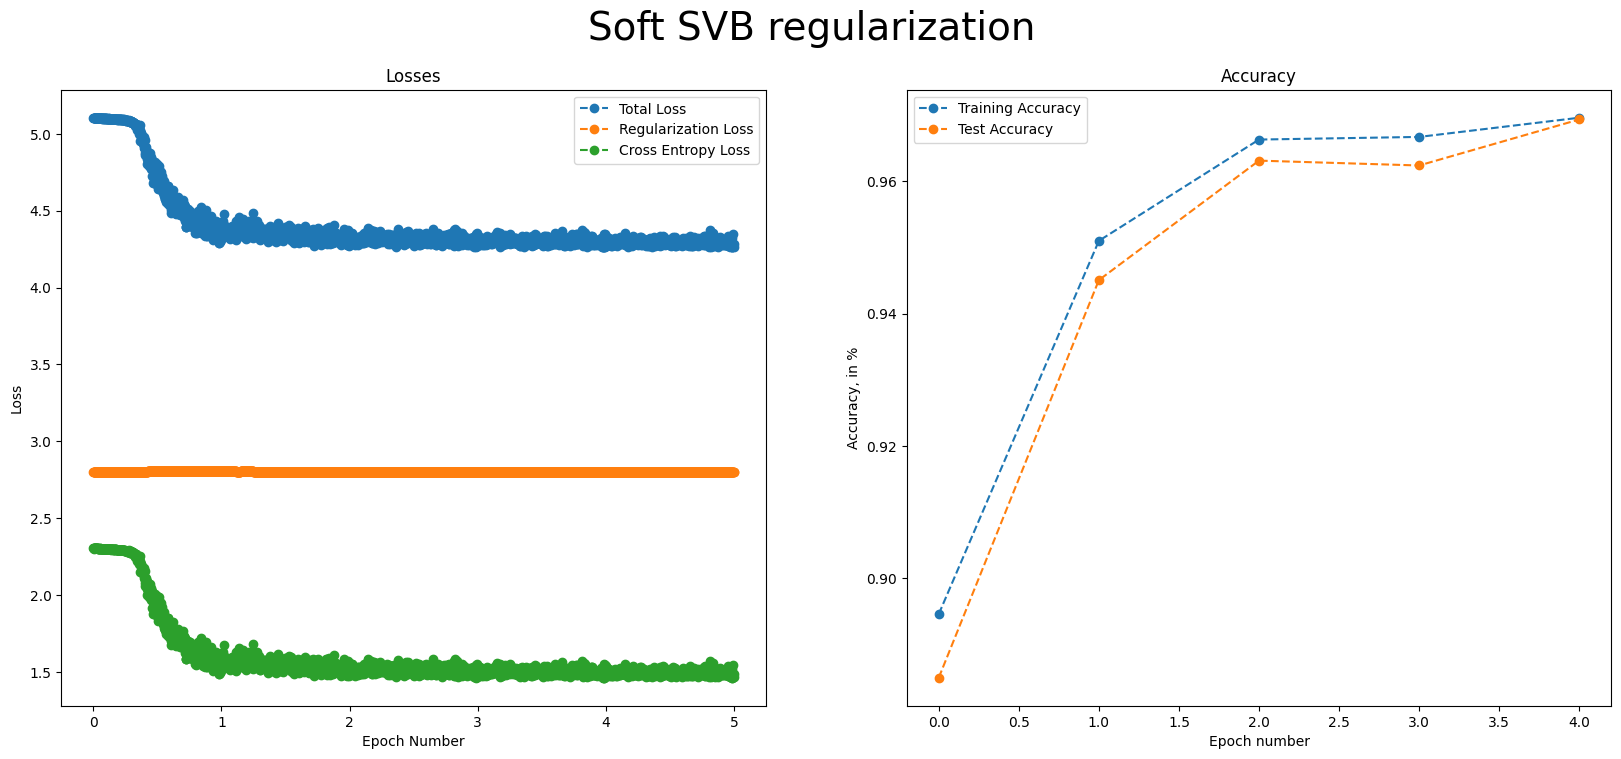

In [ ]:
plot_reg_results(
    epochs,
    losses,
    reg_losses,
    train_accuracies,
    test_accuracies,
    title="Soft SVB regularization",
)

#### Plot of Weight Distributions

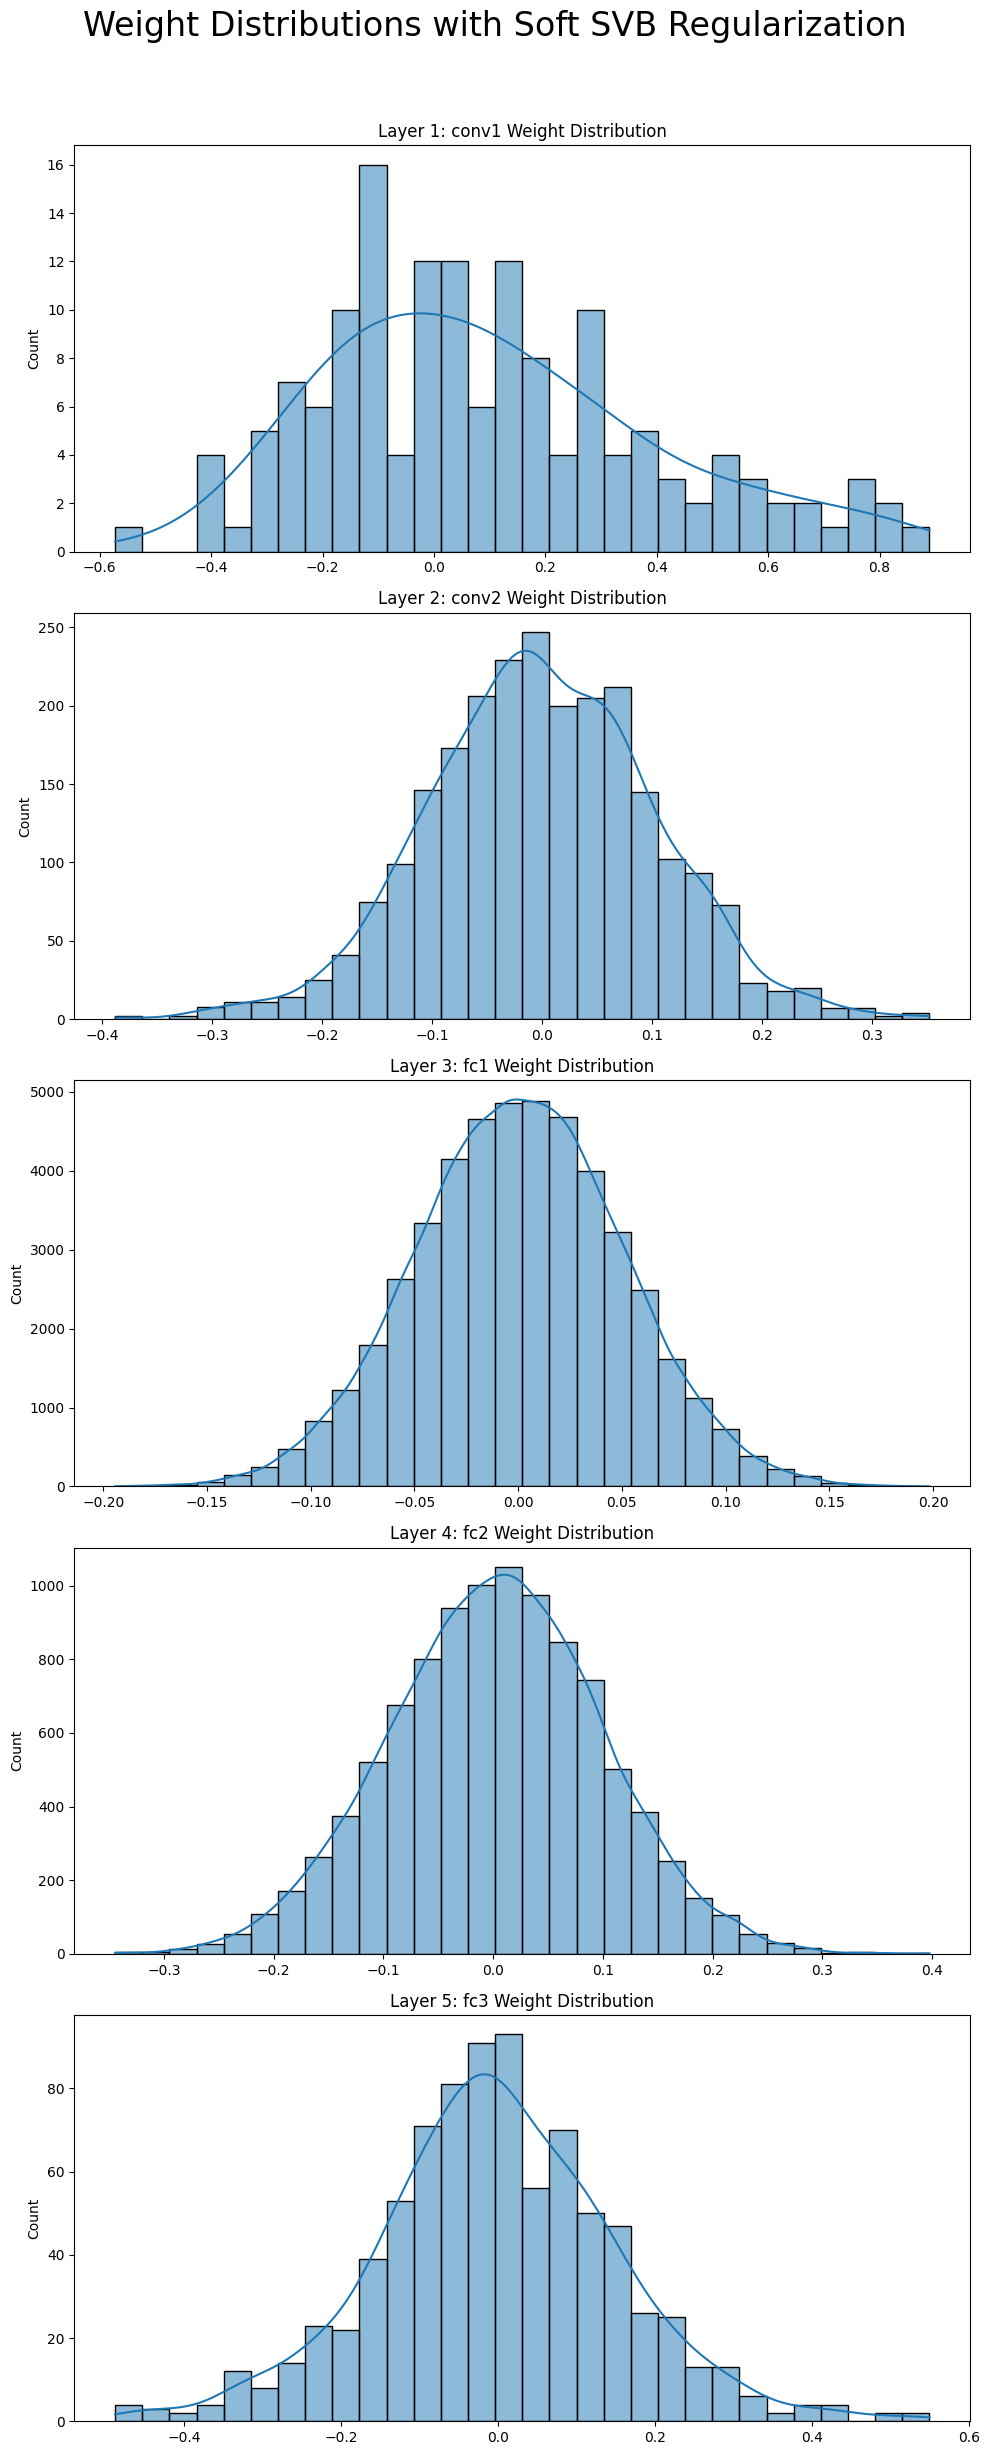

In [ ]:
plot_weight_distributions(
    model, title="Weight Distributions with Soft SVB Regularization"
)

#### Plots of Activation Maps

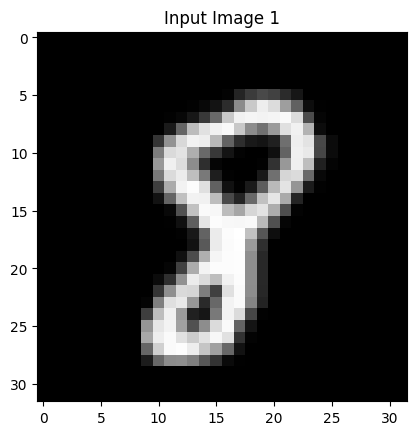

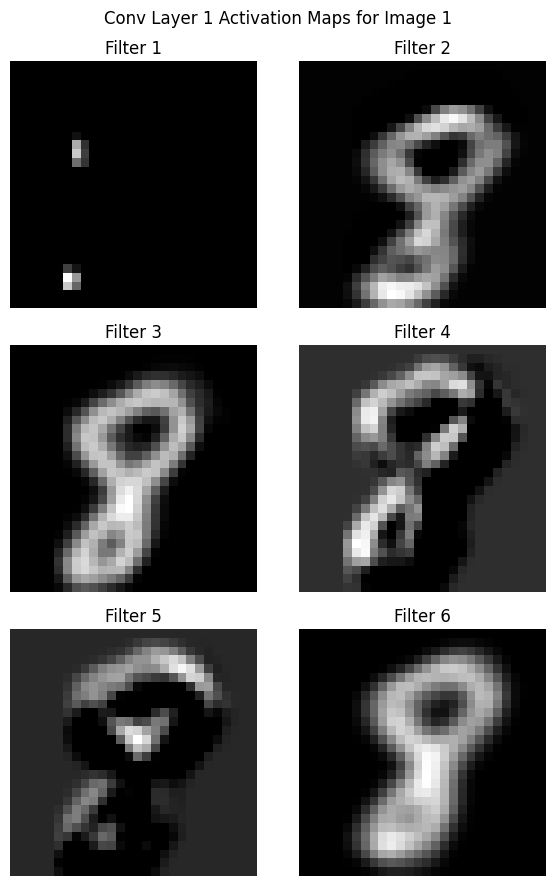

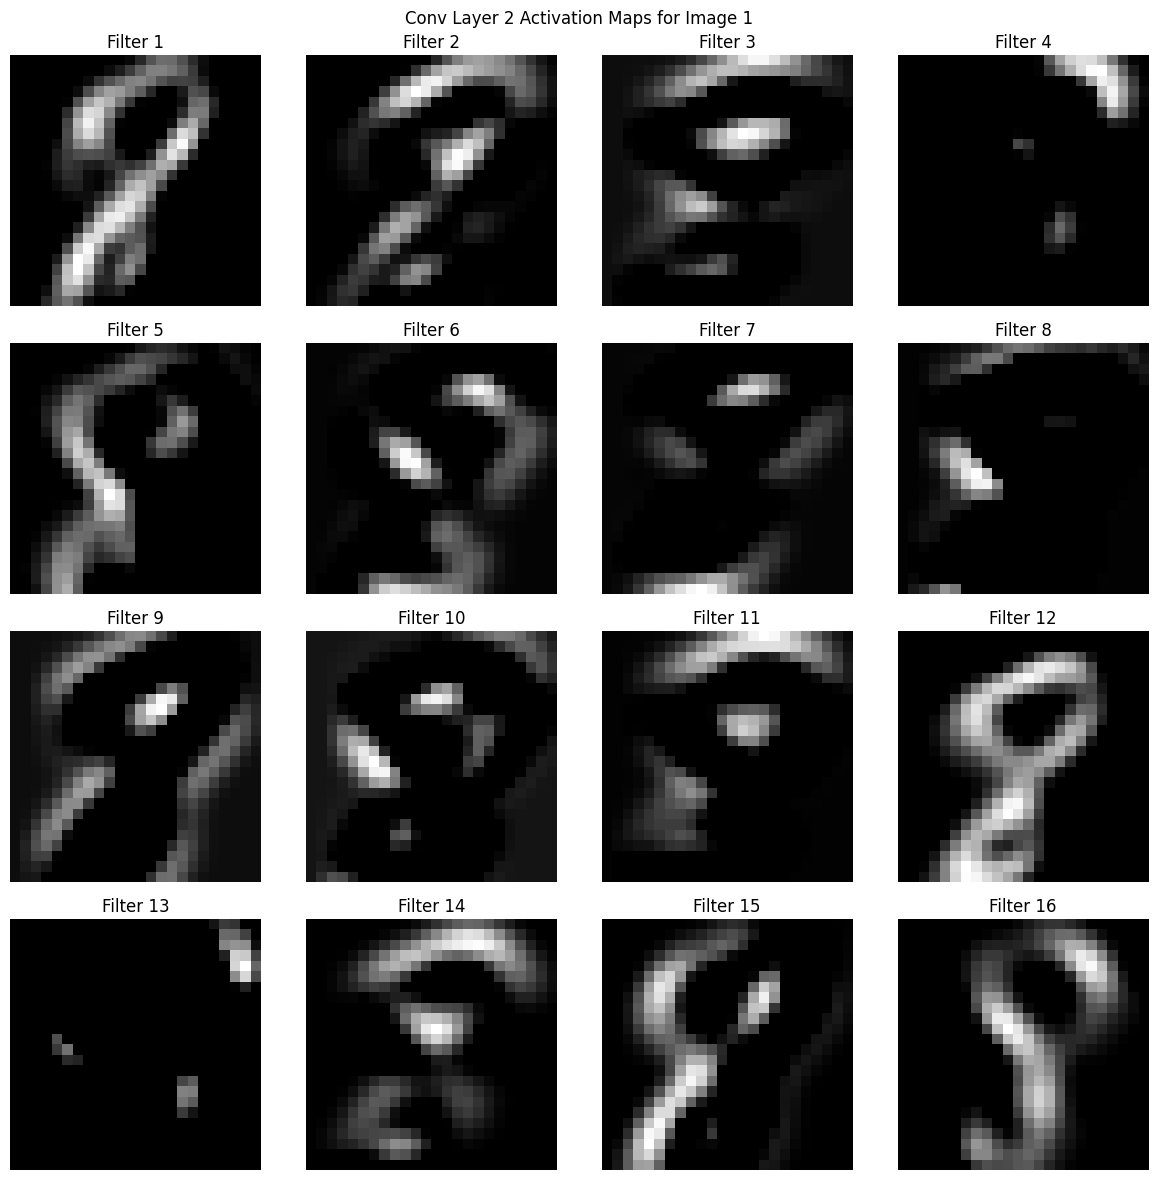

In [ ]:
plot_activation_maps(model, train_loader, num_images=1)

#### Plot of Predicted Probabilities

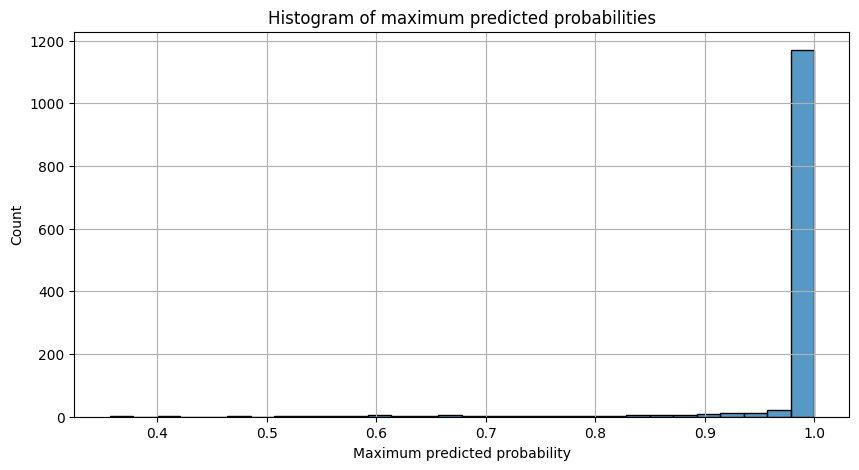

In [ ]:
plot_predicted_probabilities(model, train_loader, num_batches=10)

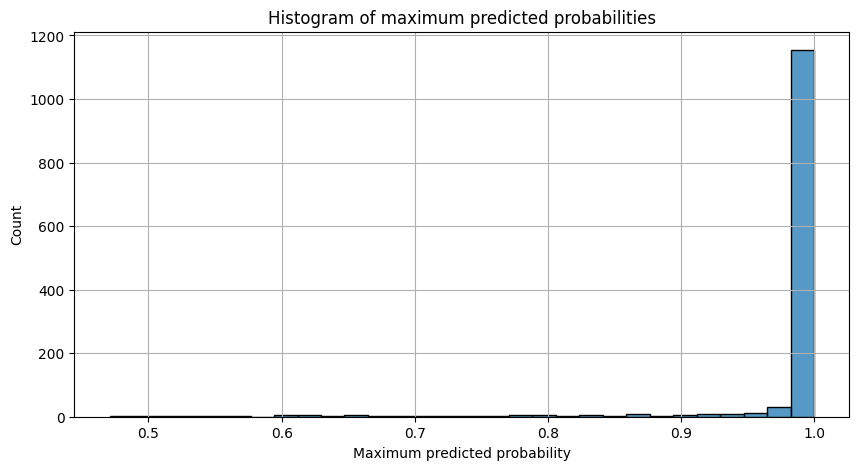

In [ ]:
plot_predicted_probabilities(model, test_loader, num_batches=10)

#### Plot of PCA of Activations

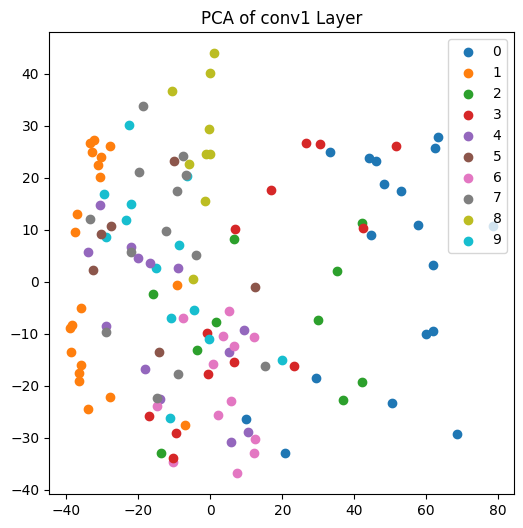

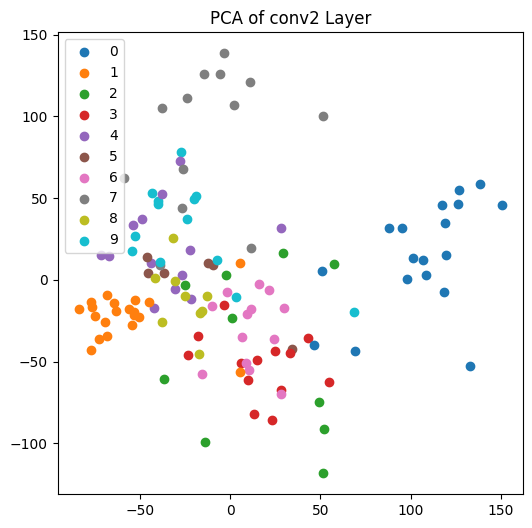

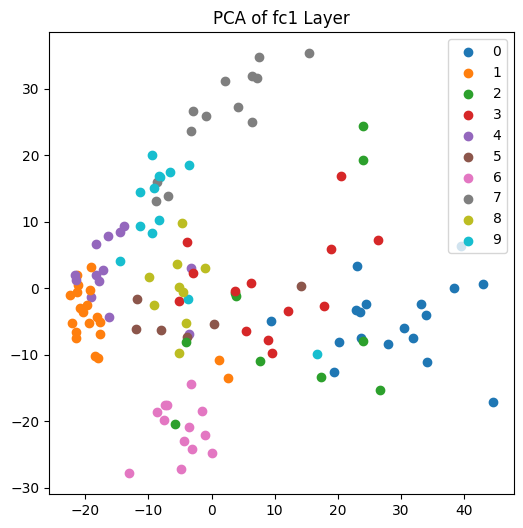

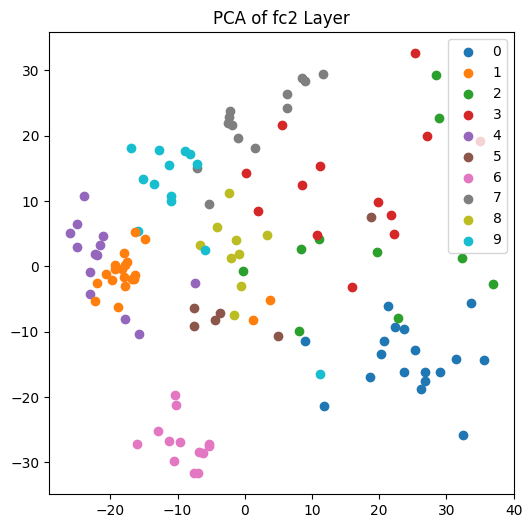

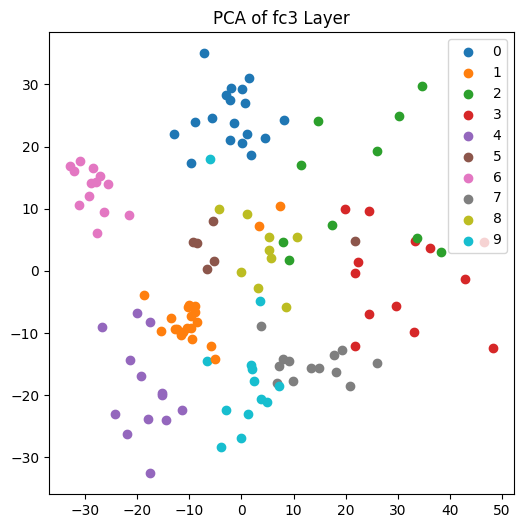

In [ ]:
plot_activations_pca(model, train_loader, device)

#### Plot of t-SNE of Activations

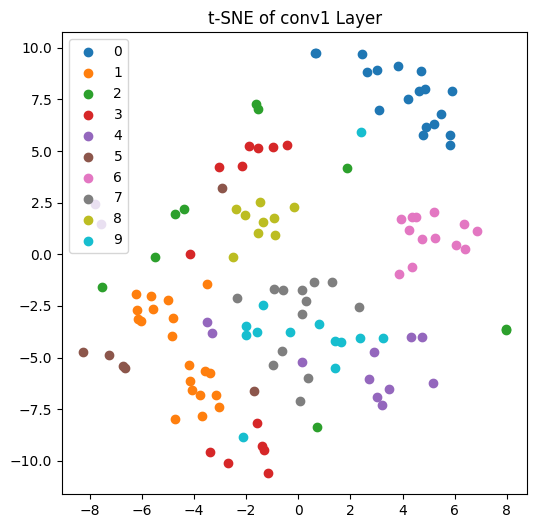

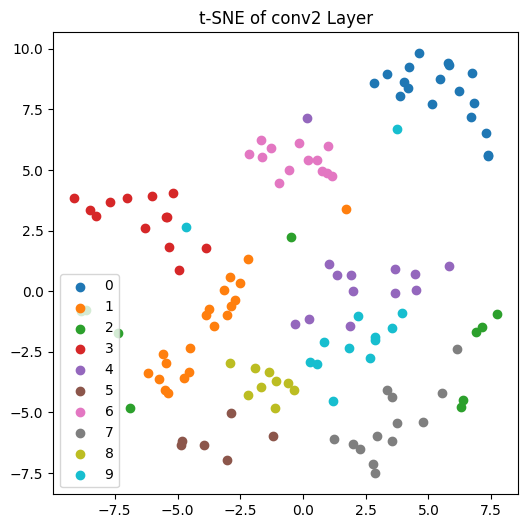

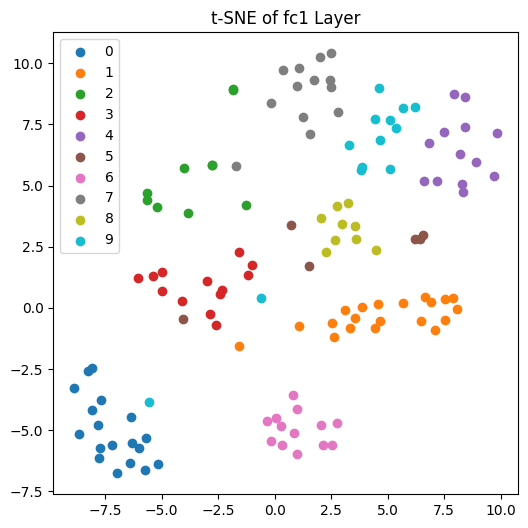

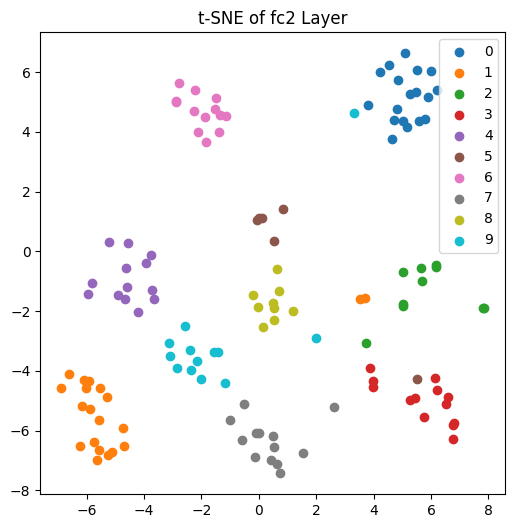

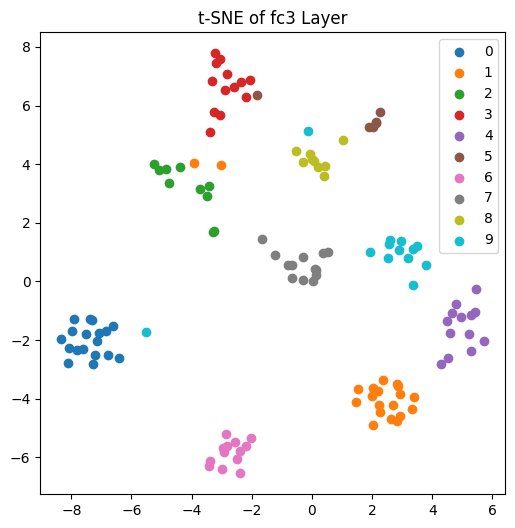

In [ ]:
plot_activations_tsne(model, train_loader, device)

#### Plots of Saliency Maps

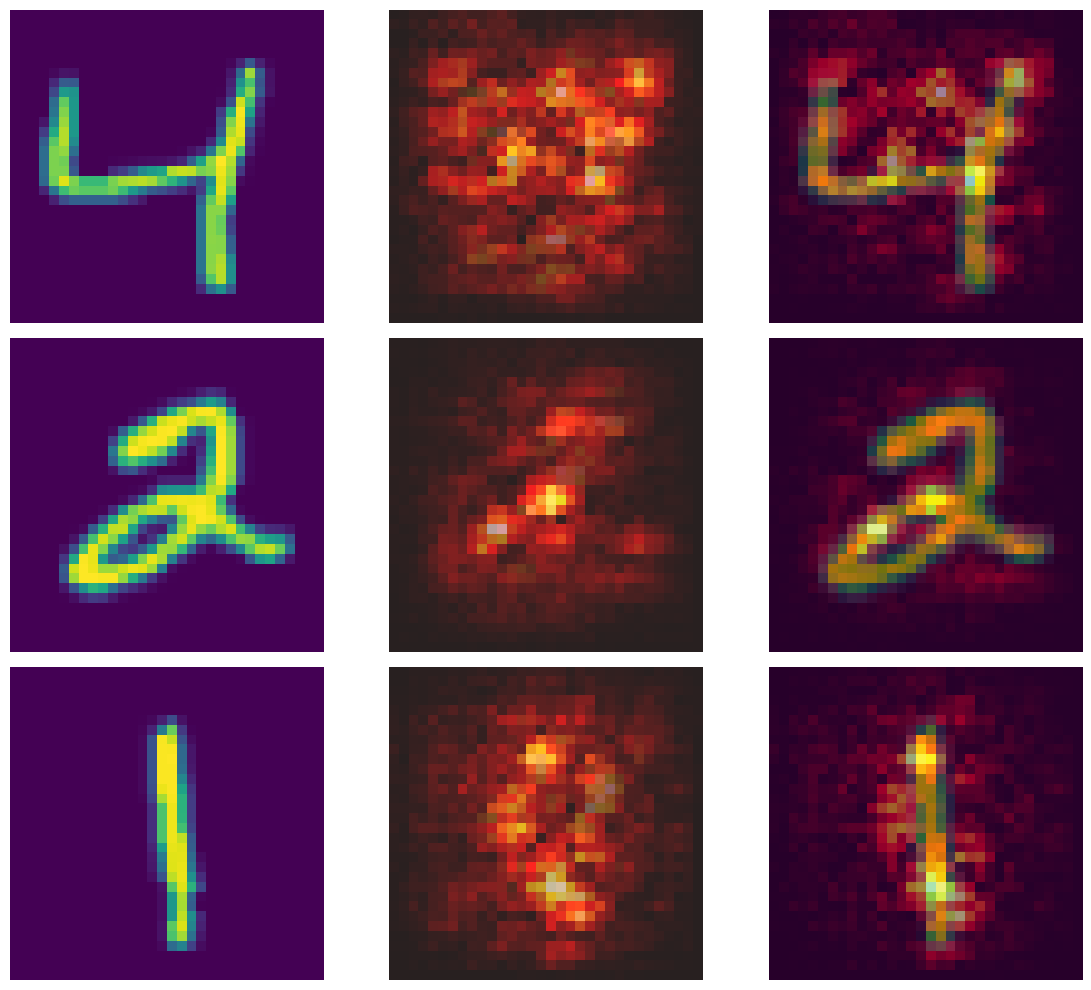

In [ ]:
plot_saliency_maps(model, train_loader, num_images=9)

#### Plots of Occlusion Sensitivity

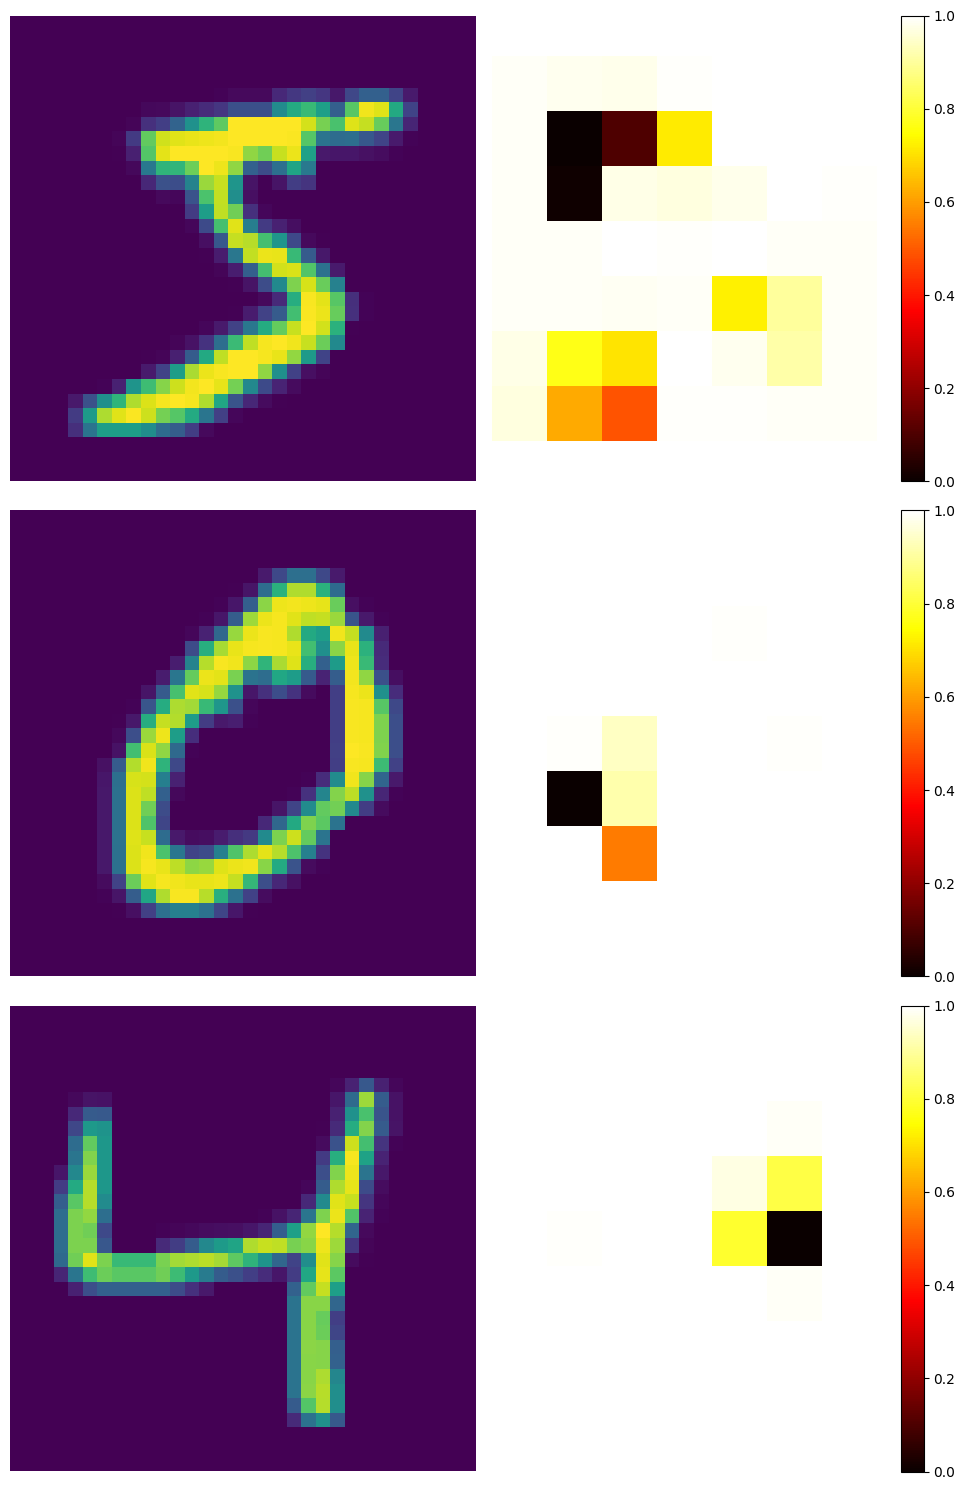

In [ ]:
plot_occlusion_sensitivity(model, train_loader, num_images=3, occluder_size=8, stride=4)

c:\Users\aslak\Desktop\Jobb\Forskningsassistent\Biologisk inspirert kunstig intelligens\regNNs\Regularization benchmarking\plotting_tools.py:445: RuntimeWarning: invalid value encountered in divide
  occlusion_scores = (occlusion_scores - occlusion_scores.min()) / (


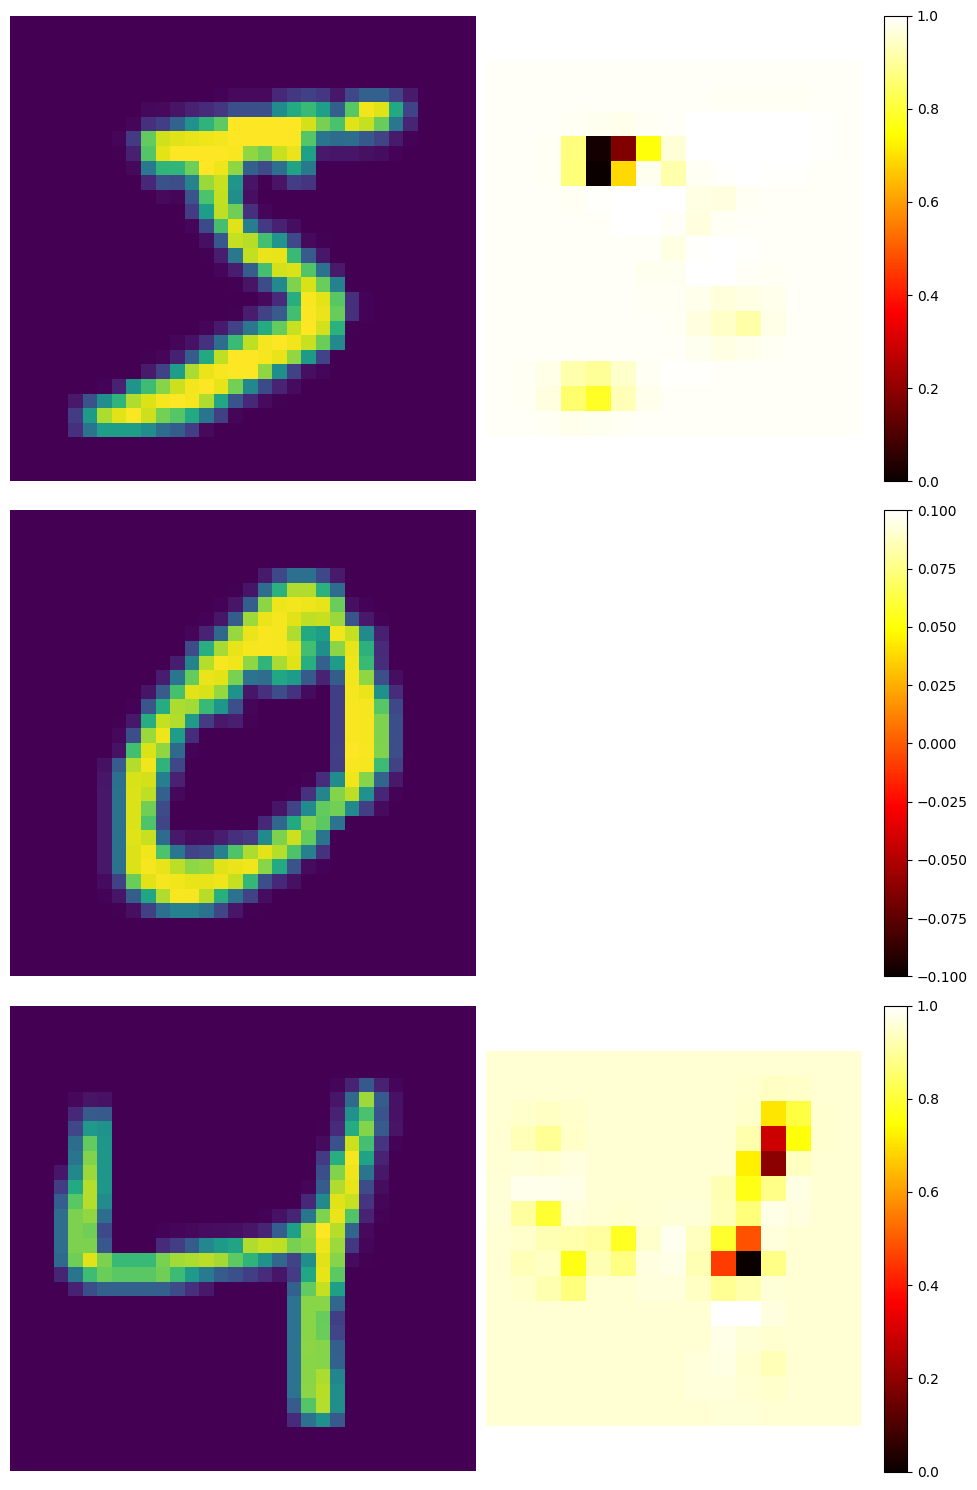

In [ ]:
plot_occlusion_sensitivity(model, train_loader, num_images=3, occluder_size=4, stride=2)

## Hard SVB Regularization

### Training

In [ ]:
model = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
n_epochs = 5
losses, reg_losses, epochs, weights, train_accuracies, test_accuracies = train(
    train_loader, test_loader, model, n_epochs, hard_svb=True, hard_svb_lmbd=0.00001
)

Epoch: 0
Accuracy of the network on the test images: 58 %
Epoch: 1
Accuracy of the network on the test images: 75 %
Epoch: 2
Accuracy of the network on the test images: 77 %
Epoch: 3
Accuracy of the network on the test images: 86 %
Epoch: 4
Accuracy of the network on the test images: 97 %


### Visualization

#### Plot of Losses and Accuracies

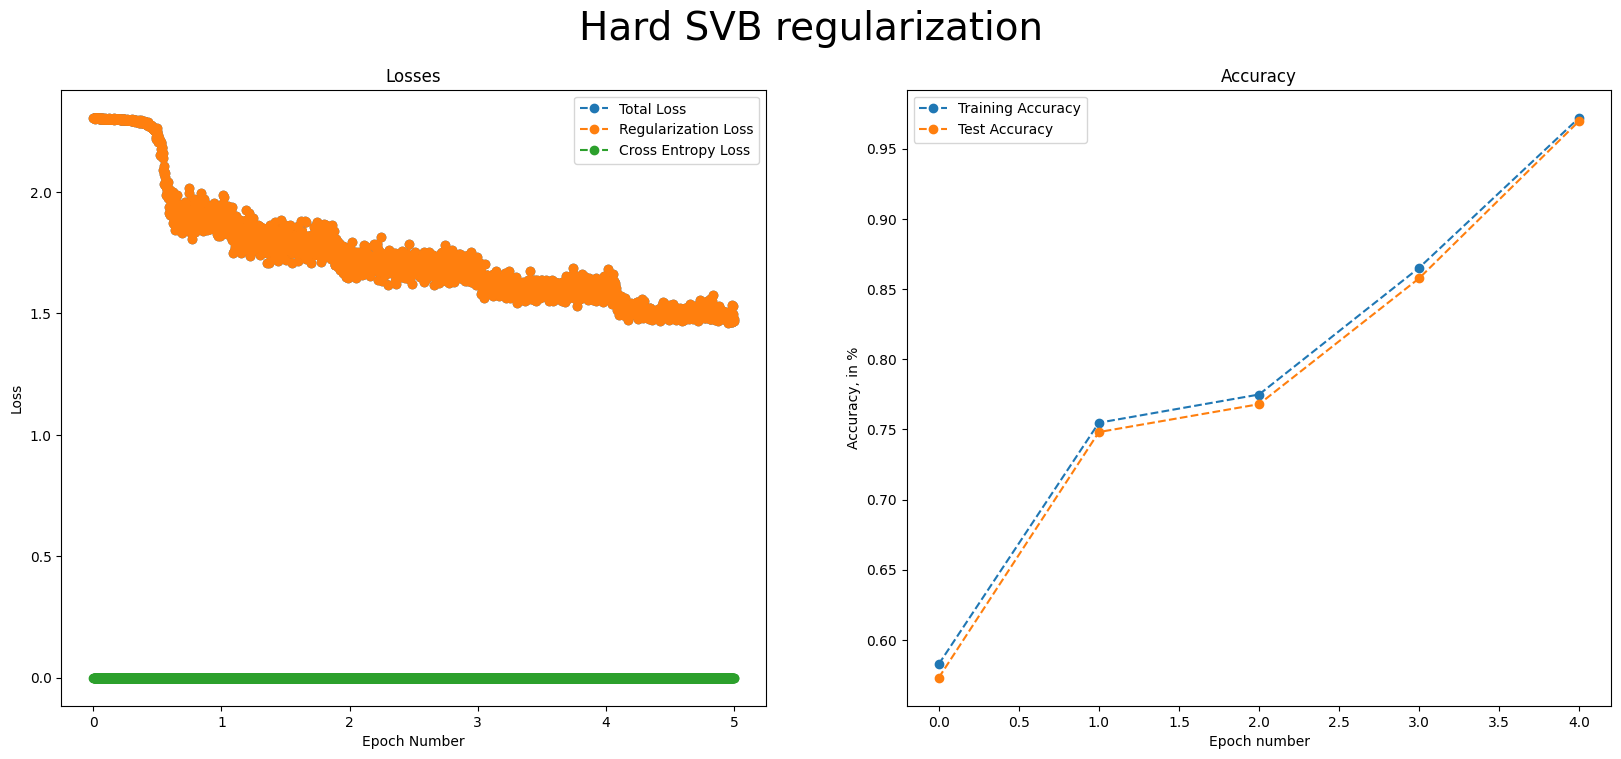

In [ ]:
plot_reg_results(
    epochs,
    losses,
    reg_losses,
    train_accuracies,
    test_accuracies,
    title="Hard SVB regularization",
)

#### Plot of Weight Distributions

In [ ]:
plot_weight_distributions(model, title = "Weight Distributions with Hard SVB Regularization")

#### Plots of Activation Maps

In [ ]:
plot_activation_maps(model, train_loader, num_images=1)

#### Plot of Predicted Probabilities

In [ ]:
plot_predicted_probabilities(model, train_loader, num_batches=10)

In [ ]:
plot_predicted_probabilities(model, test_loader, num_batches=10)

#### Plot of PCA of Activations

In [ ]:
plot_activations_pca(model, train_loader, device)

#### Plot of t-SNE of Activations

In [ ]:
plot_activations_tsne(model, train_loader, device)

#### Plots of Saliency Maps

In [ ]:
plot_saliency_maps(model, train_loader, num_images=9)

#### Plots of Occlusion Sensitivity

In [ ]:
plot_occlusion_sensitivity(model, train_loader, num_images=3, occluder_size=8, stride=4)

In [ ]:
plot_occlusion_sensitivity(model, train_loader, num_images=3, occluder_size=4, stride=2)

## Jacobi Regularization

### Training

In [ ]:
model = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
n_epochs = 3
losses, reg_losses, epochs, weights, train_accuracies, test_accuracies = train(
    train_loader, test_loader, model, n_epochs, jacobi_reg=True, jacobi_reg_lmbd=1
)

  0%|          | 0/3 [00:00<?, ?it/s]

calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
Epoch: 0


 33%|███▎      | 1/3 [01:57<03:55, 117.74s/it]

Accuracy of the network on the test images: 74 %
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
Epoch: 1


 67%|██████▋   | 2/3 [04:00<02:00, 120.43s/it]

Accuracy of the network on the test images: 76 %
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
Epoch: 2


100%|██████████| 3/3 [05:54<00:00, 118.12s/it]

Accuracy of the network on the test images: 77 %


### Visualization

#### Plot of Losses and Accuracies

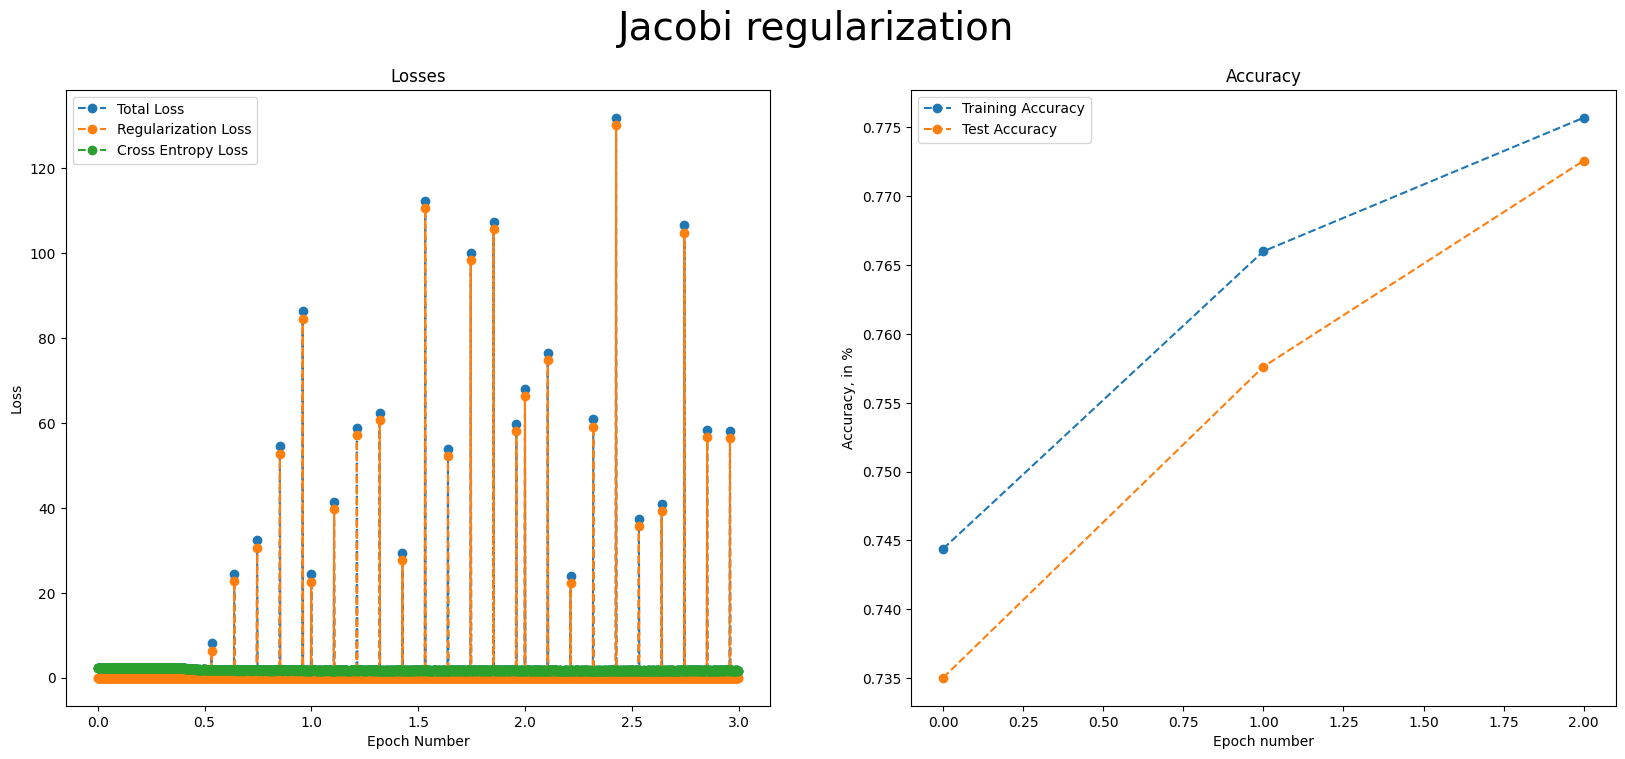

In [ ]:
plot_reg_results(
    epochs,
    losses,
    reg_losses,
    train_accuracies,
    test_accuracies,
    title="Jacobi regularization",
)

#### Plot of Weight Distributions

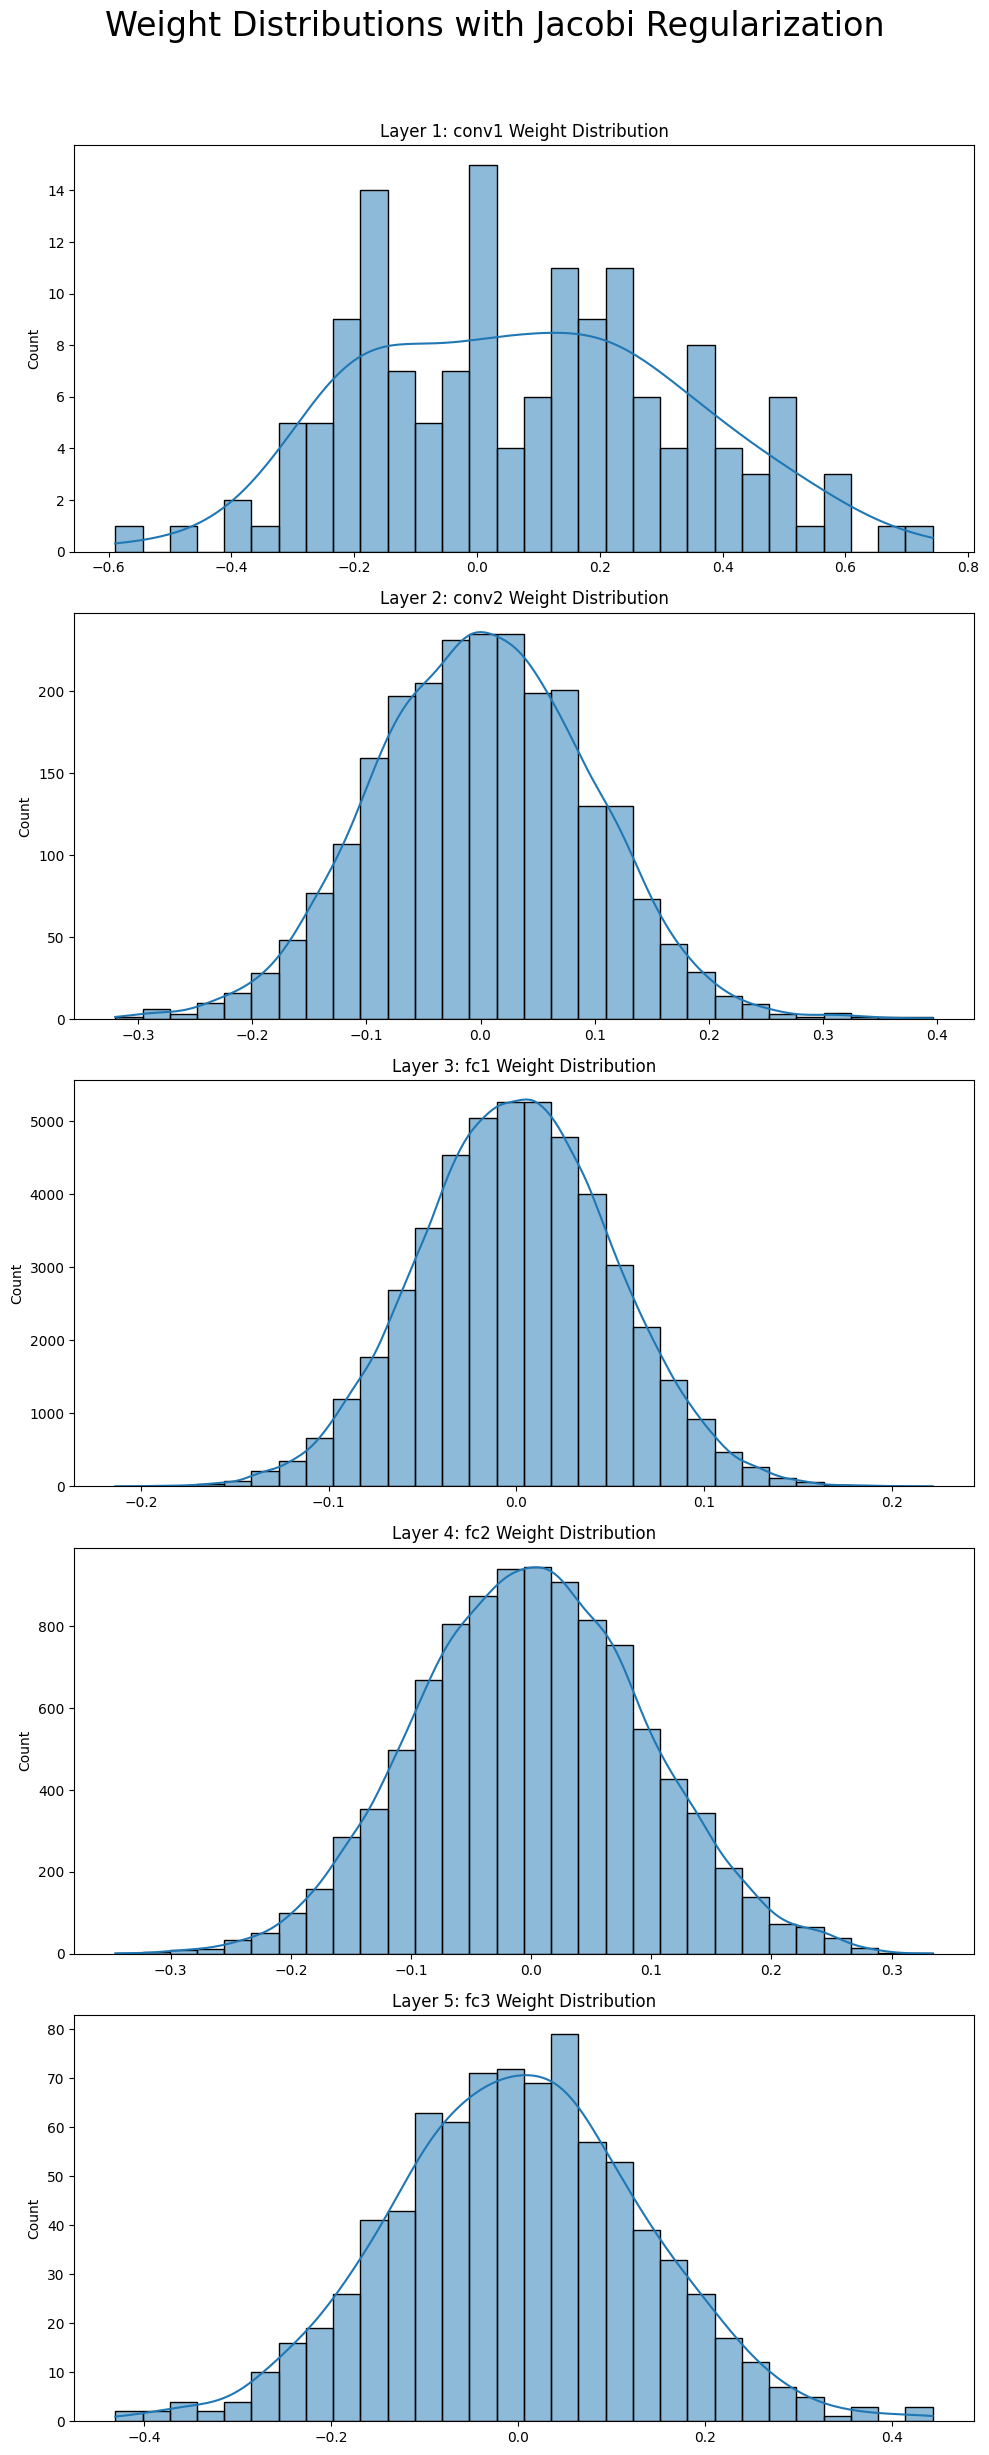

In [ ]:
plot_weight_distributions(
    model, title="Weight Distributions with Jacobi Regularization"
)

#### Plots of Activation Maps

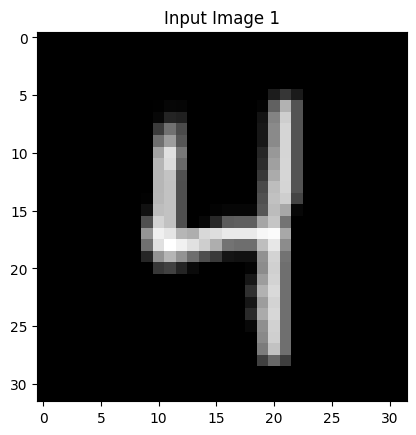

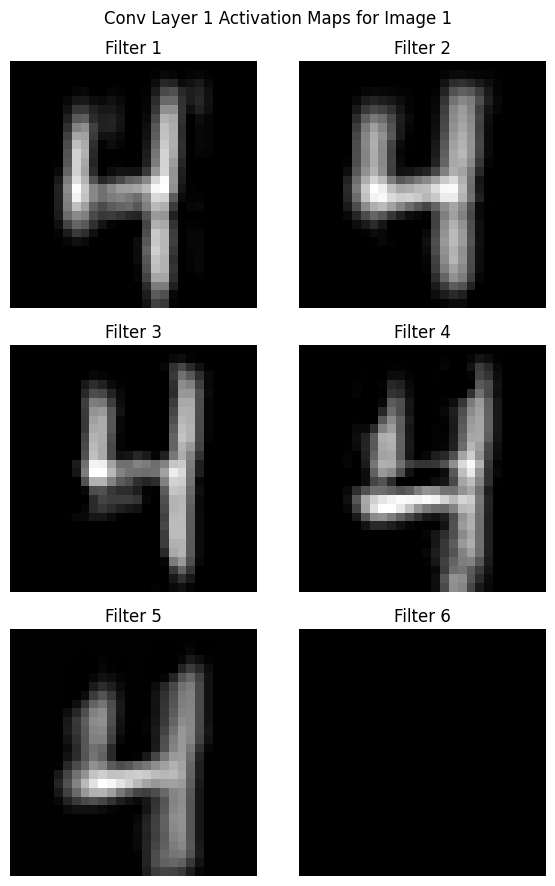

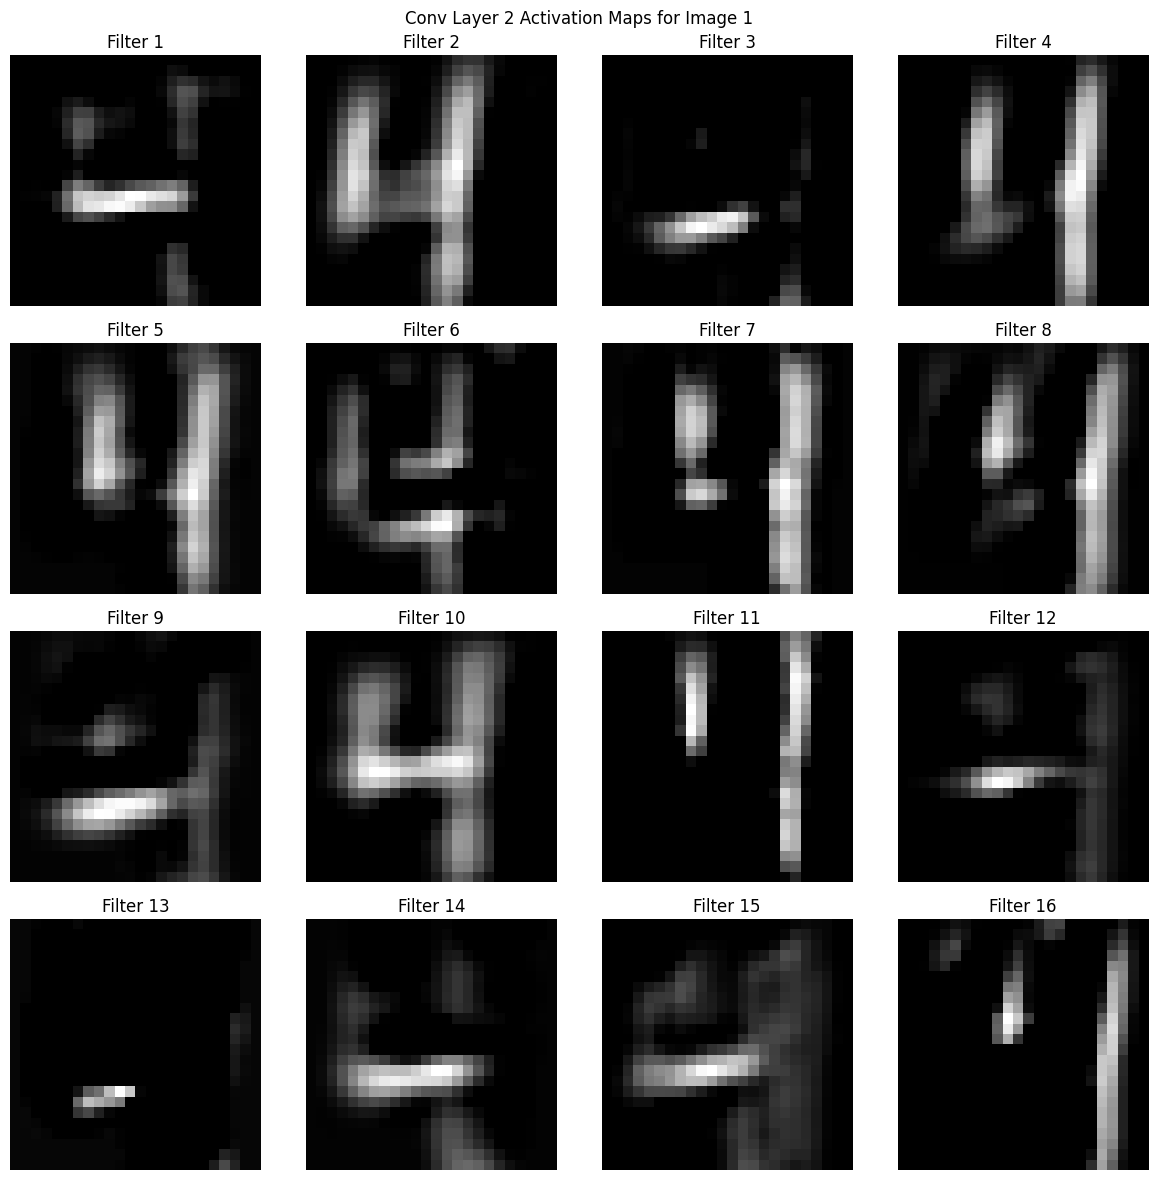

In [ ]:
plot_activation_maps(model, train_loader, num_images=1)

#### Plot of Predicted Probabilities

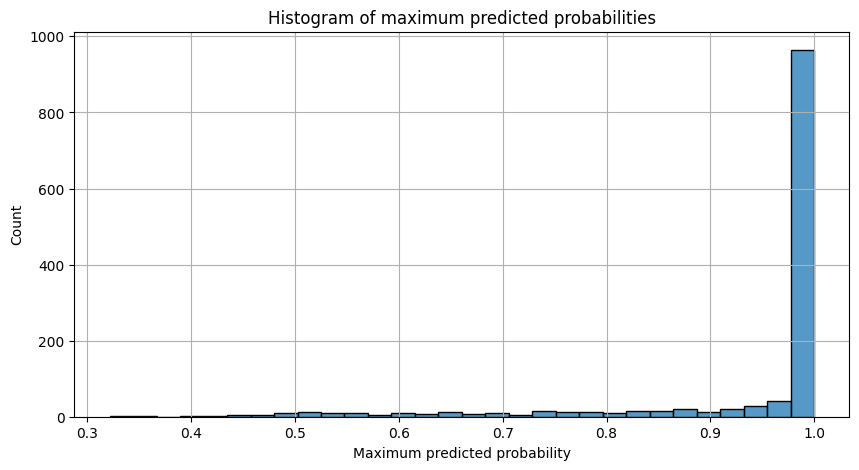

In [ ]:
plot_predicted_probabilities(model, train_loader, num_batches=10)

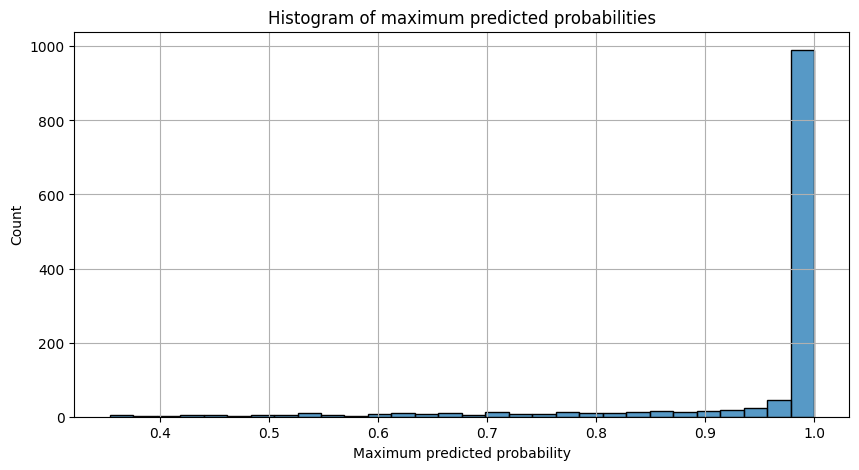

In [ ]:
plot_predicted_probabilities(model, test_loader, num_batches=10)

#### Plot of PCA of Activations

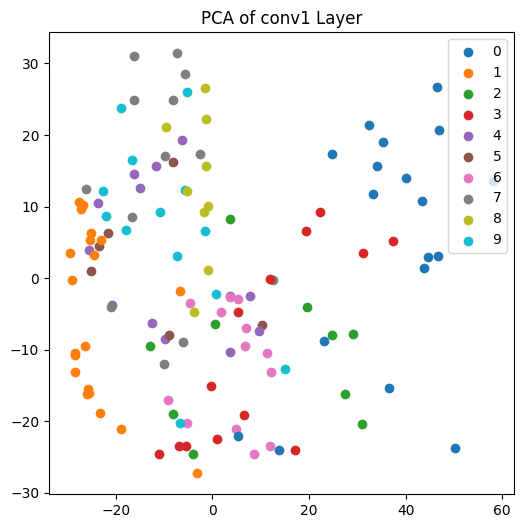

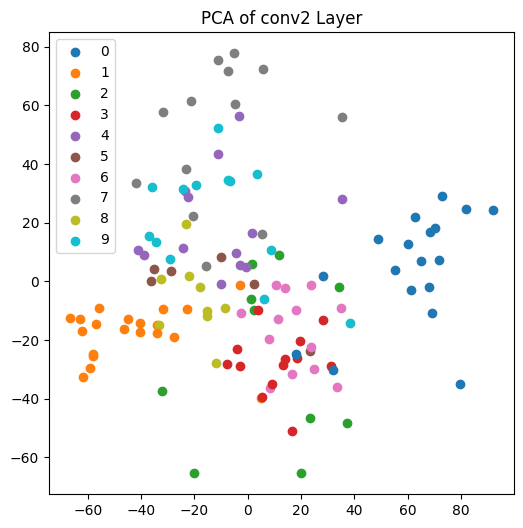

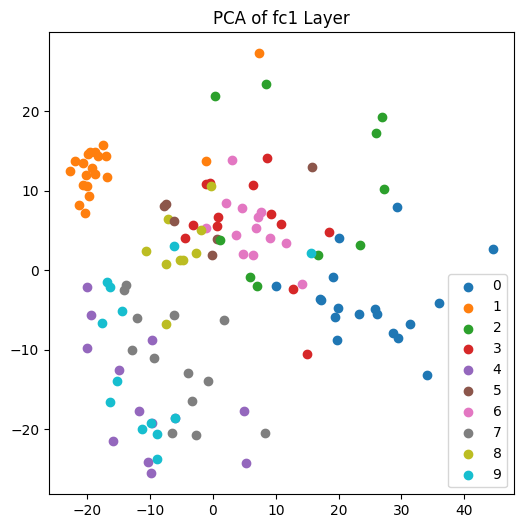

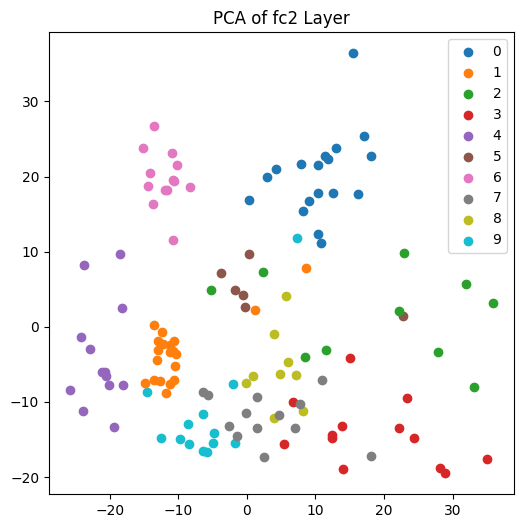

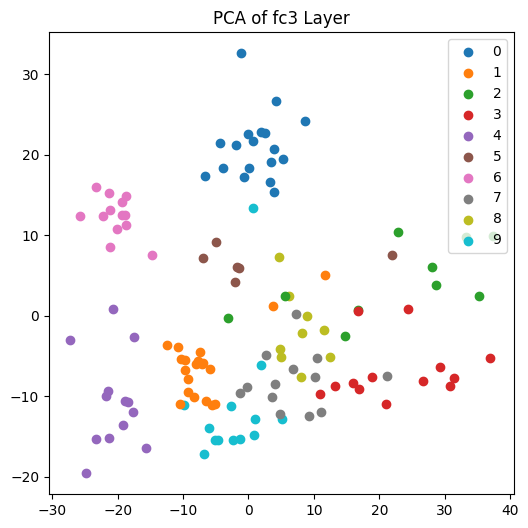

In [ ]:
plot_activations_pca(model, train_loader, device)

#### Plot of t-SNE of Activations

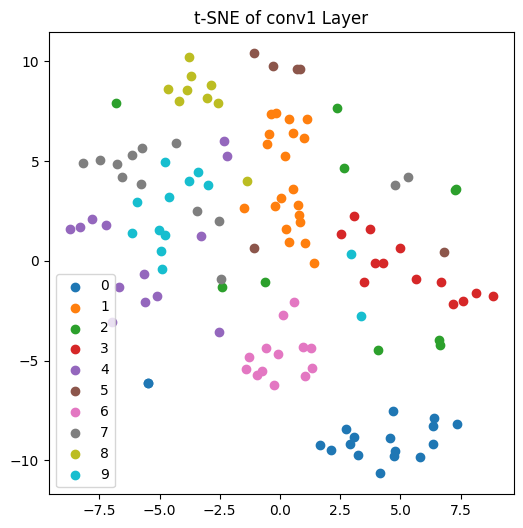

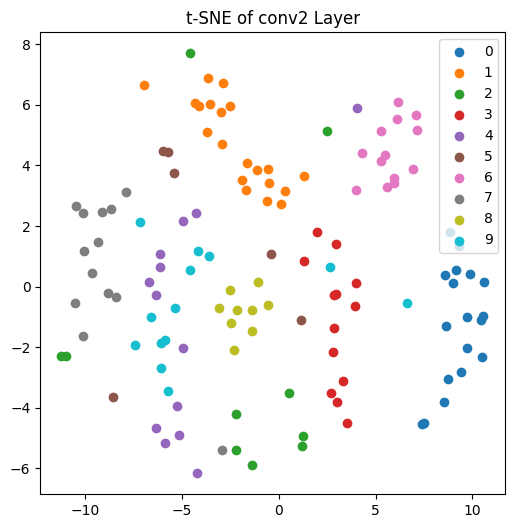

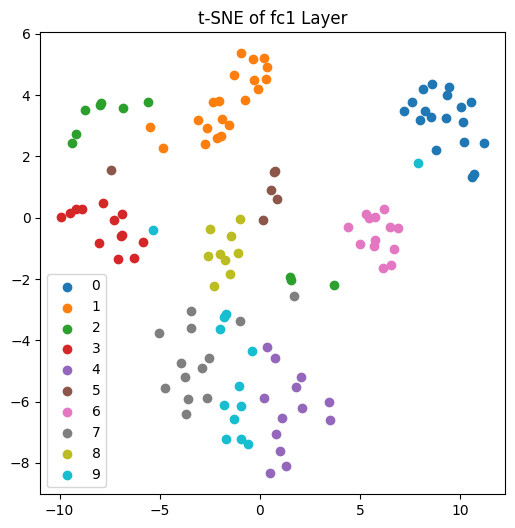

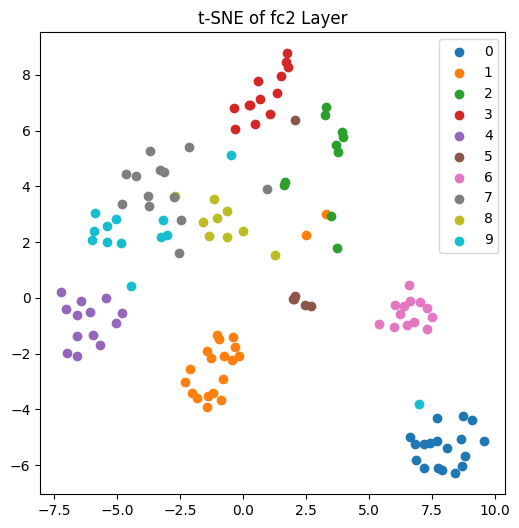

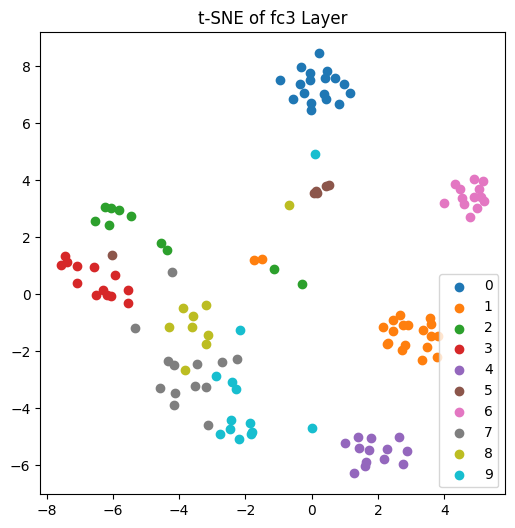

In [ ]:
plot_activations_tsne(model, train_loader, device)

#### Plots of Saliency Maps

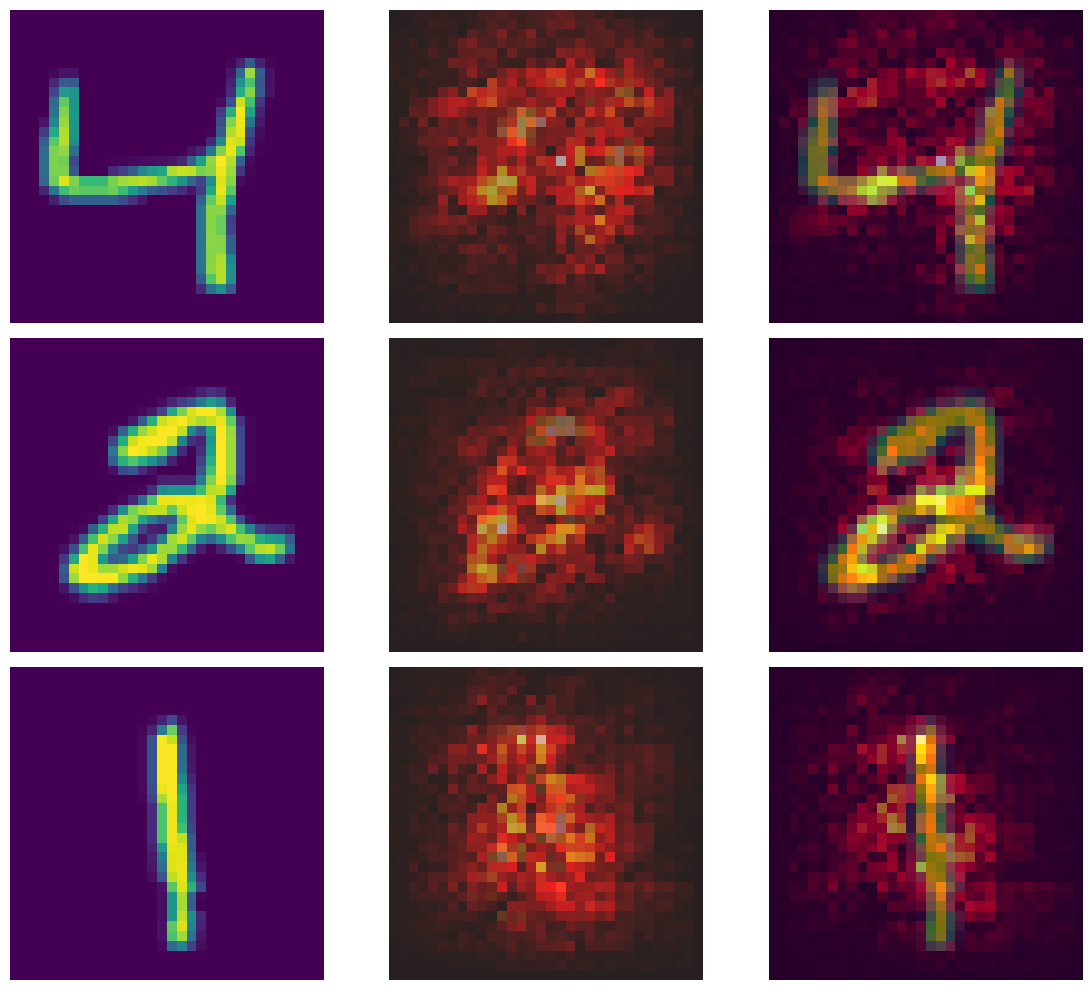

In [ ]:
plot_saliency_maps(model, train_loader, num_images=9)

#### Plots of Occlusion Sensitivity

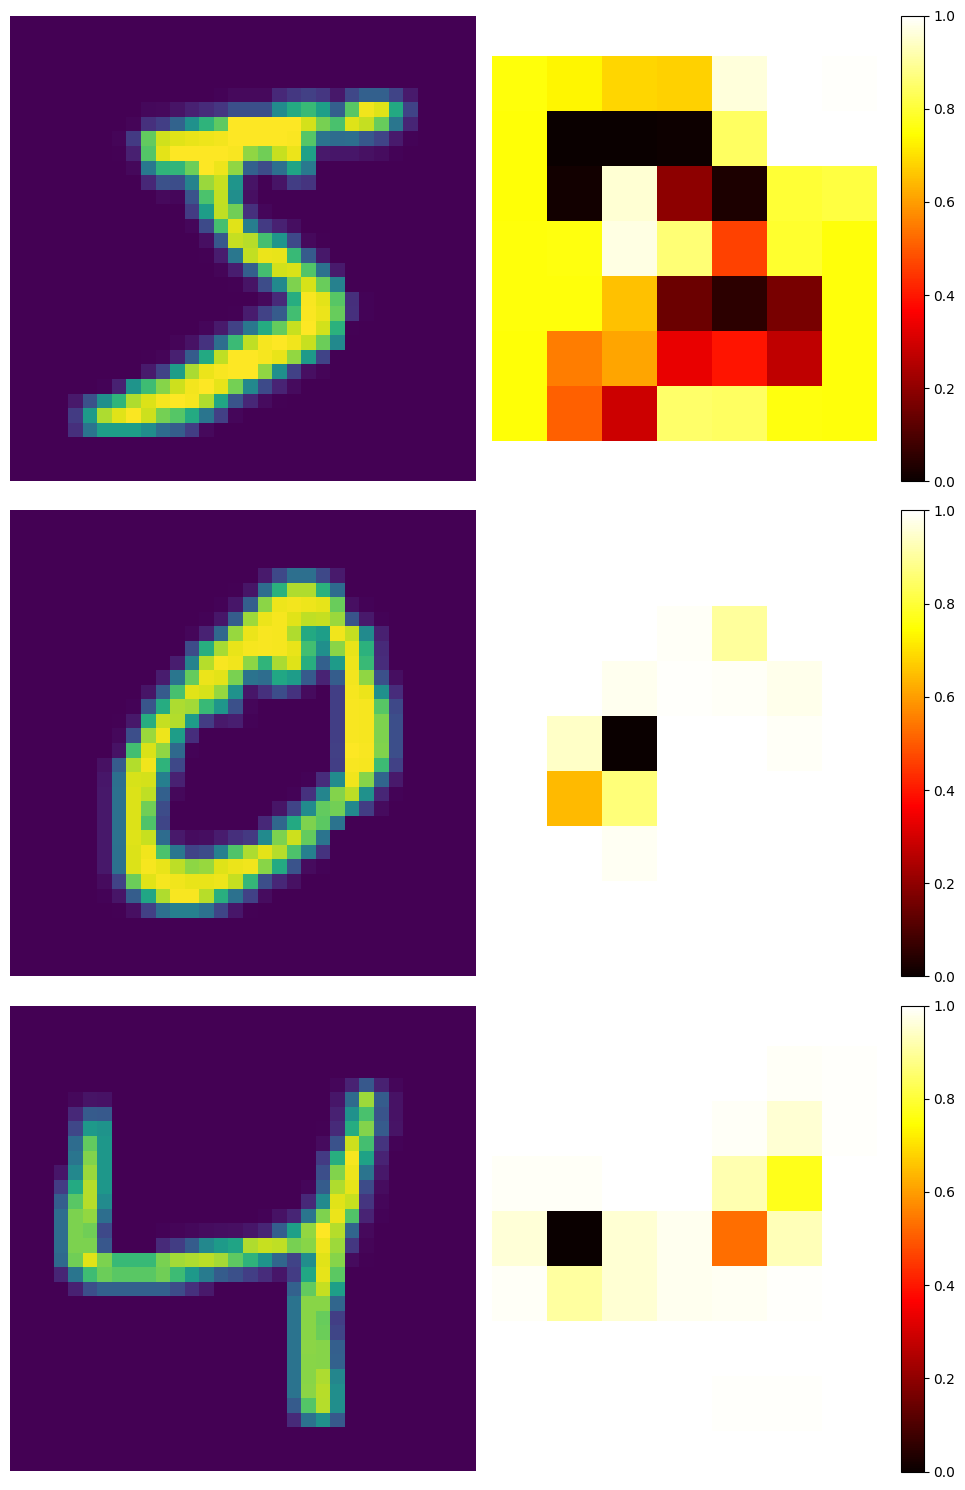

In [ ]:
plot_occlusion_sensitivity(model, train_loader, num_images=3, occluder_size=8, stride=4)

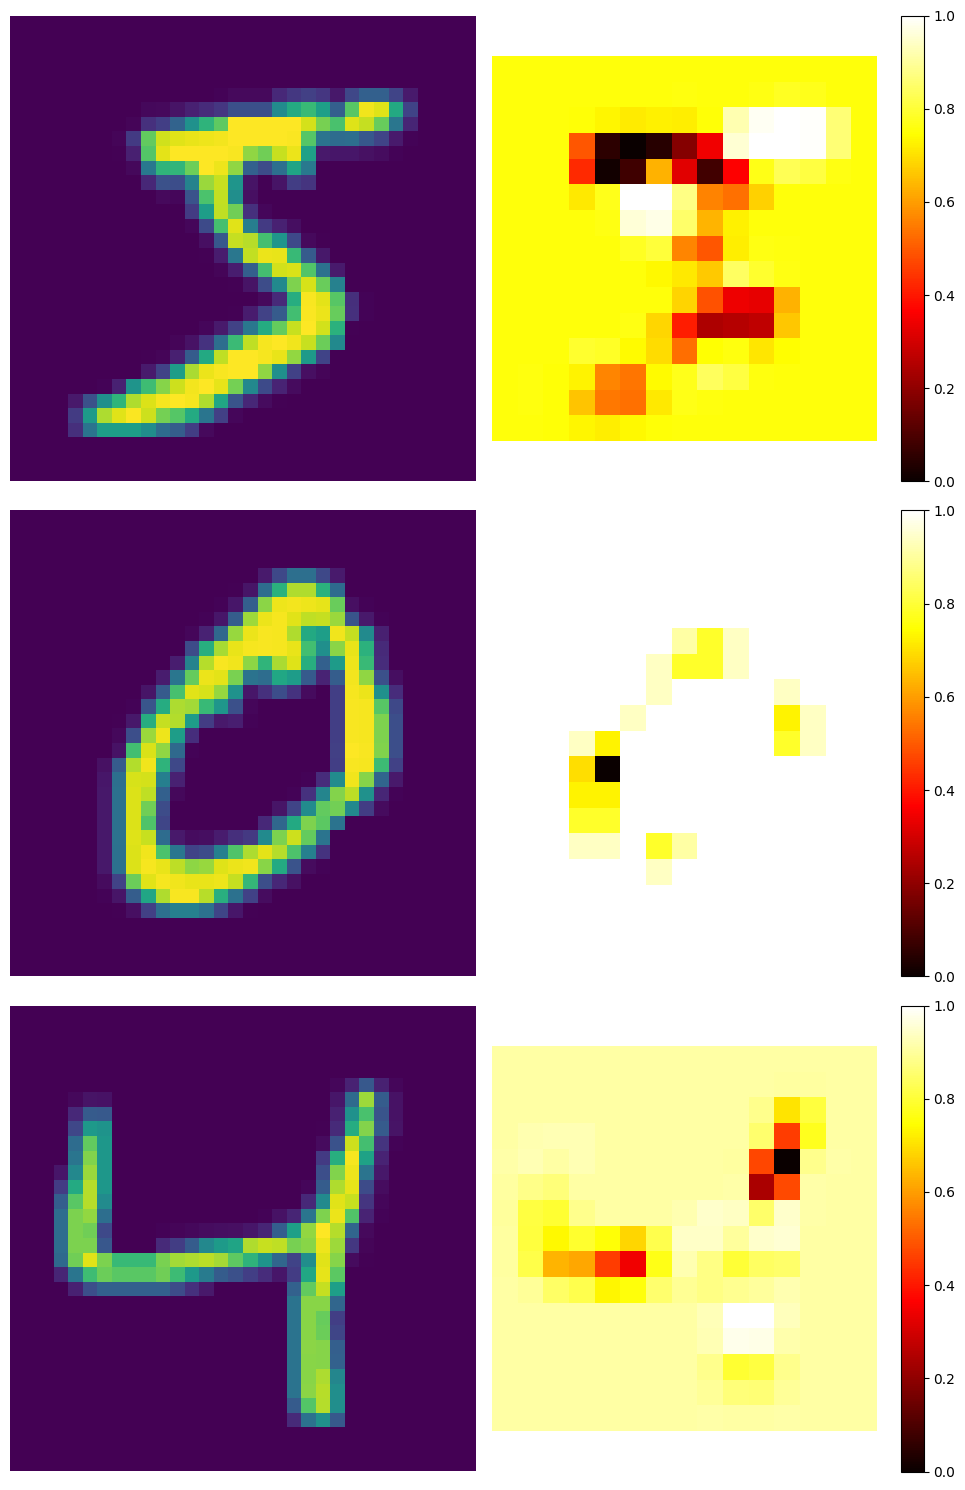

In [ ]:
plot_occlusion_sensitivity(model, train_loader, num_images=3, occluder_size=4, stride=2)

## Jacobi Determinant Regularization

### Training

In [ ]:
model = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
n_epochs = 3
losses, reg_losses, epochs, weights, train_accuracies, test_accuracies = train(
    train_loader,
    test_loader,
    model,
    n_epochs,
    jacobi_det_reg=True,
    jacobi_det_reg_lmbd=0.001,
)

  0%|          | 0/3 [00:00<?, ?it/s]

calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
Epoch: 0


 33%|███▎      | 1/3 [01:22<02:44, 82.27s/it]

Accuracy of the network on the test images: 82 %
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
Epoch: 1


 67%|██████▋   | 2/3 [02:44<01:22, 82.36s/it]

Accuracy of the network on the test images: 85 %
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
calculated jacobi
Epoch: 2


100%|██████████| 3/3 [04:25<00:00, 88.58s/it]

Accuracy of the network on the test images: 86 %


### Visualization

#### Plot of Losses and Accuracies

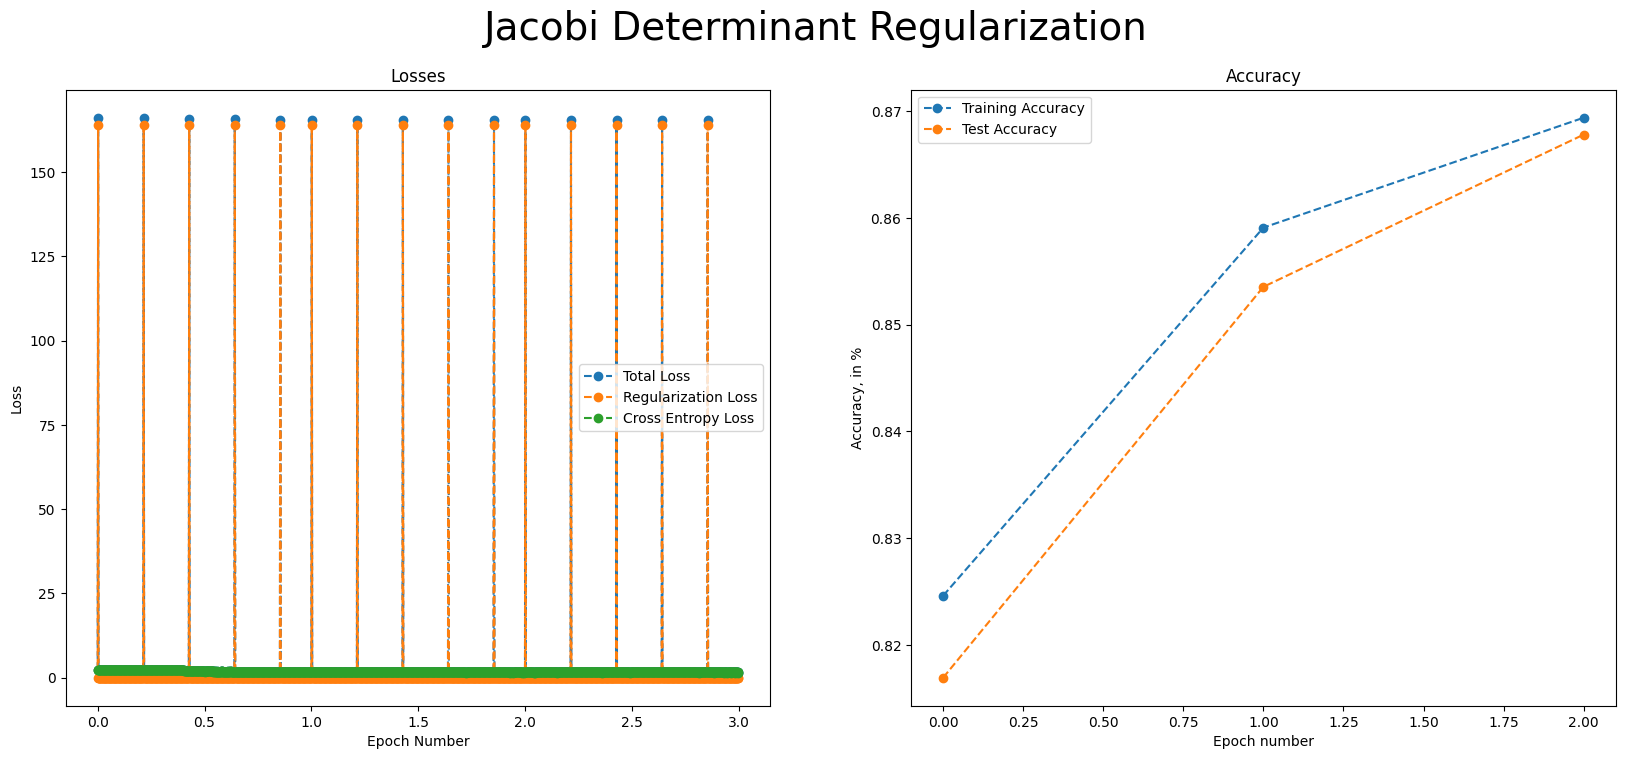

In [ ]:
plot_reg_results(
    epochs,
    losses,
    reg_losses,
    train_accuracies,
    test_accuracies,
    title="Jacobi Determinant Regularization",
)

#### Plot of Weight Distributions

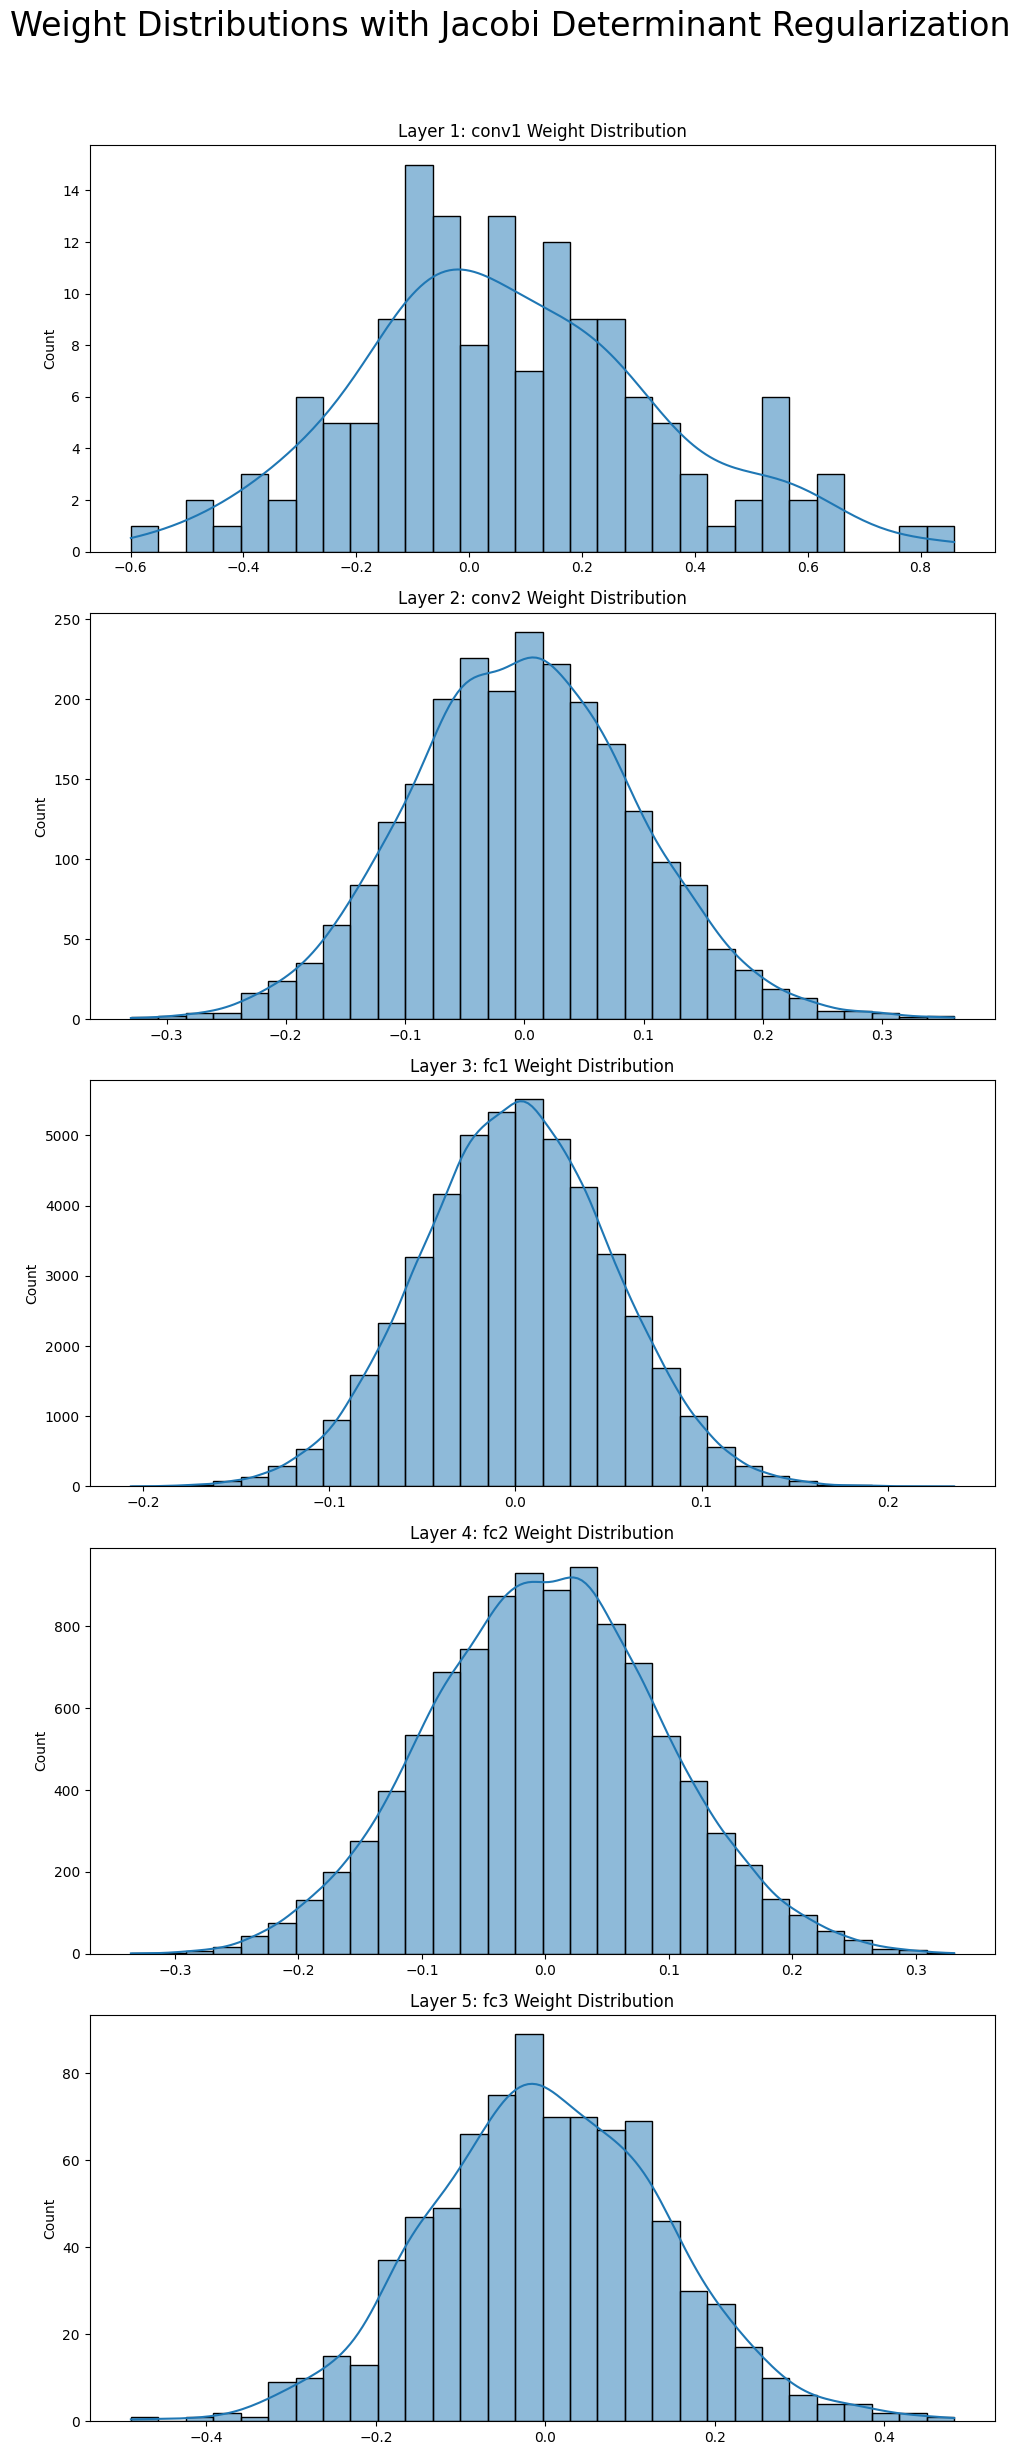

In [ ]:
plot_weight_distributions(
    model, title="Weight Distributions with Jacobi Determinant Regularization"
)

#### Plots of Activation Maps

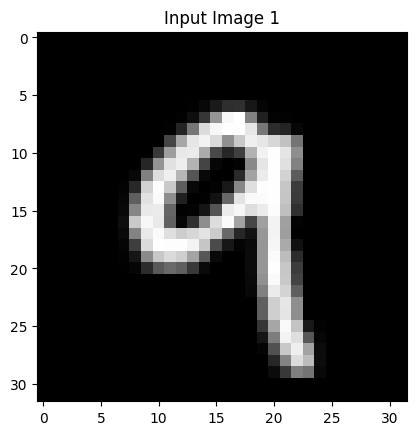

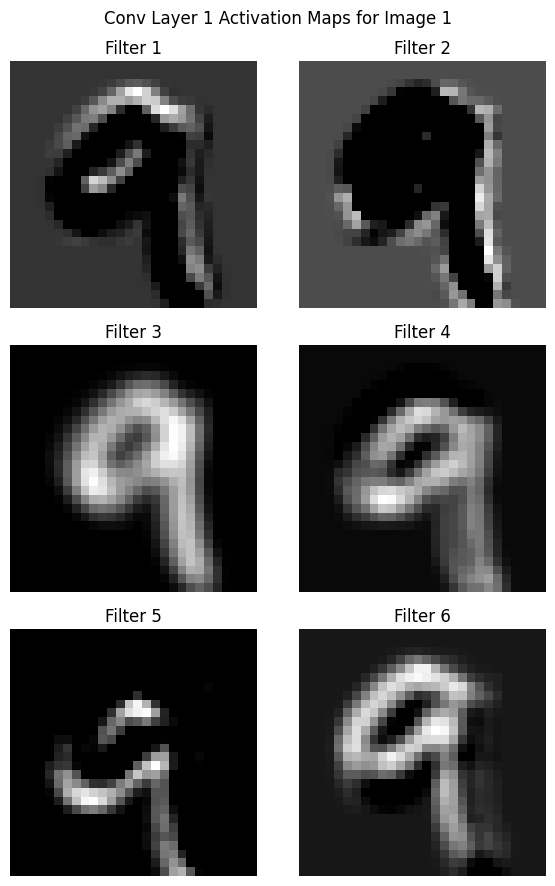

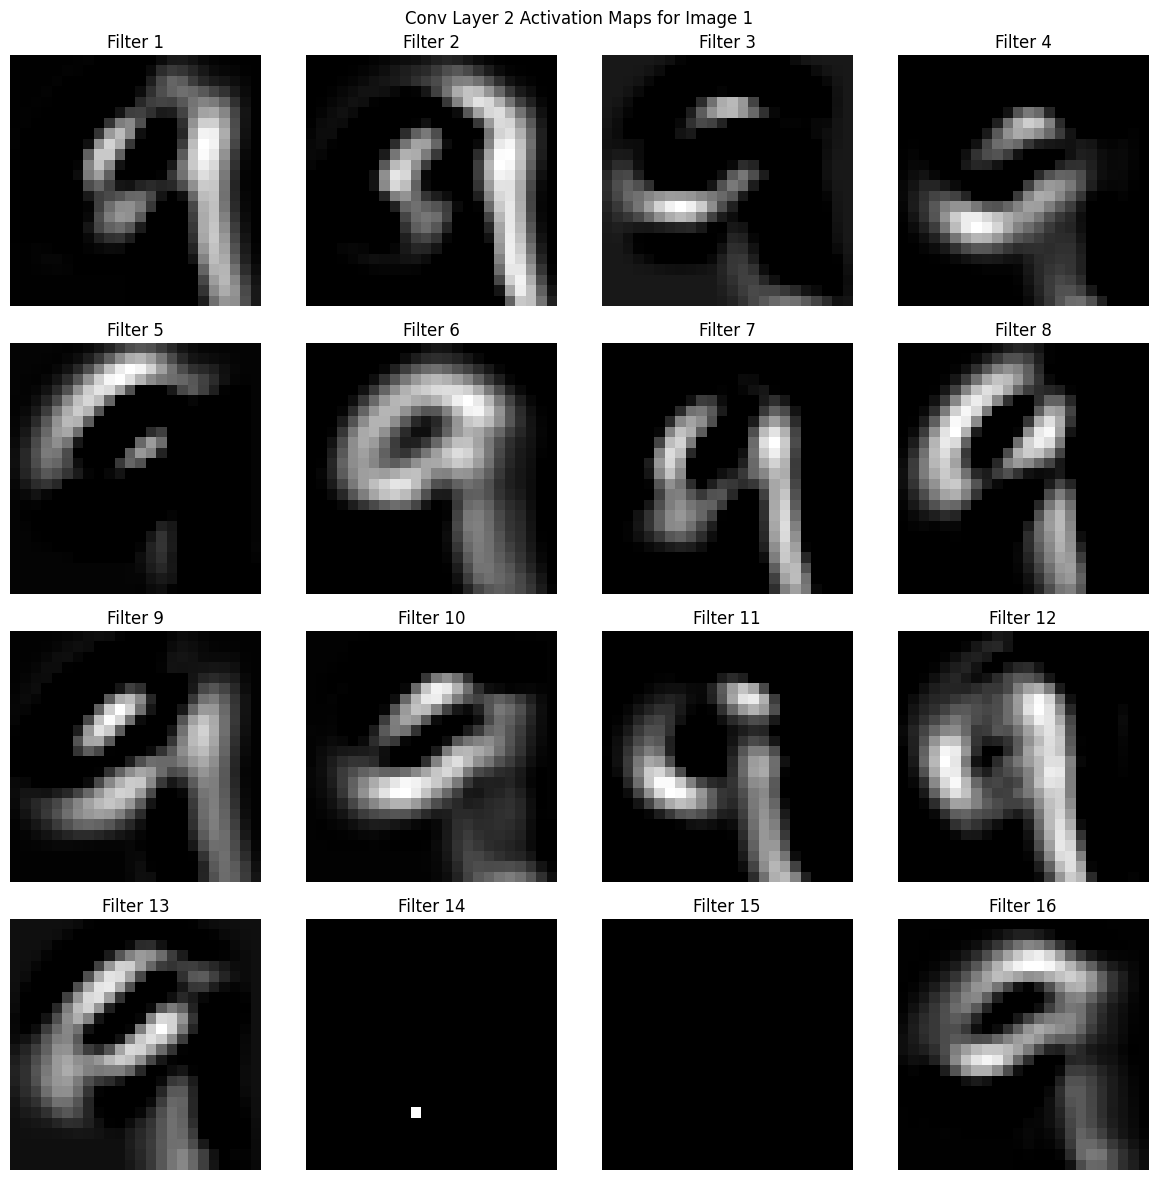

In [ ]:
plot_activation_maps(model, train_loader, num_images=1)

#### Plot of Predicted Probabilities

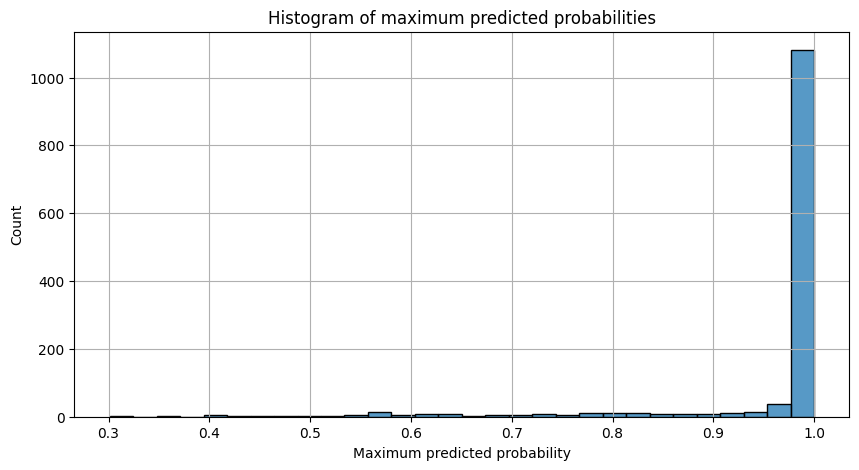

In [ ]:
plot_predicted_probabilities(model, train_loader, num_batches=10)

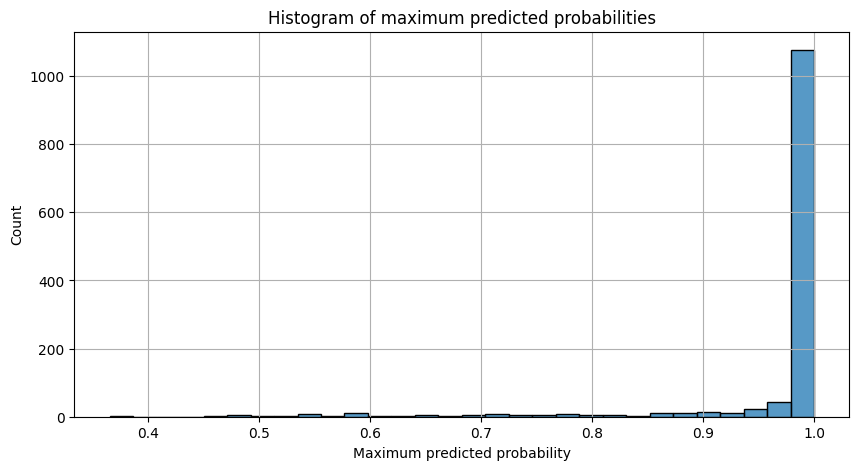

In [ ]:
plot_predicted_probabilities(model, test_loader, num_batches=10)

#### Plot of PCA of Activations

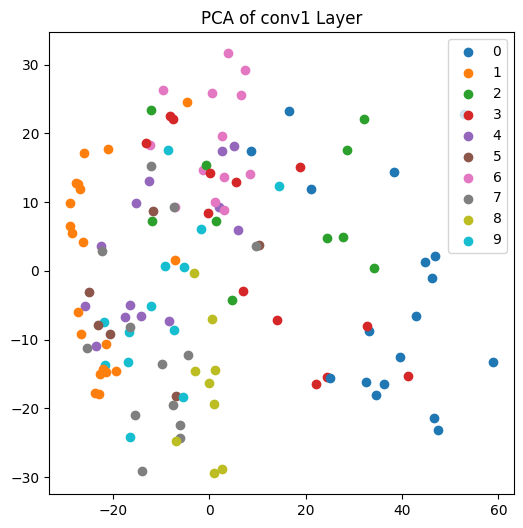

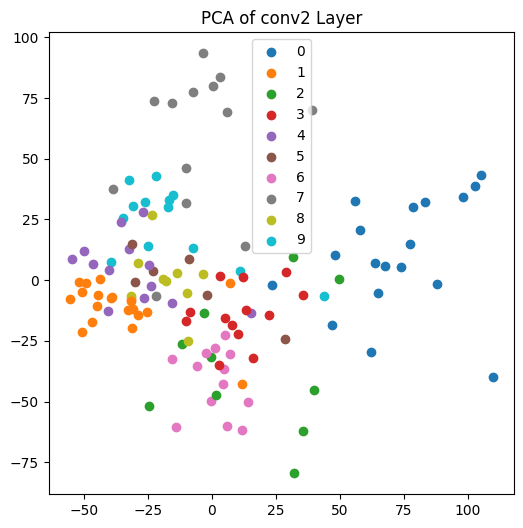

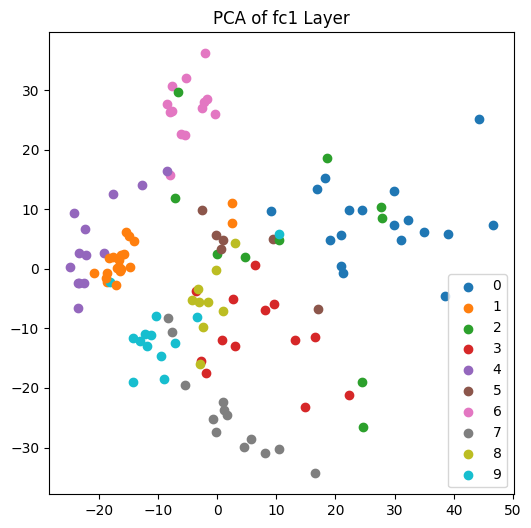

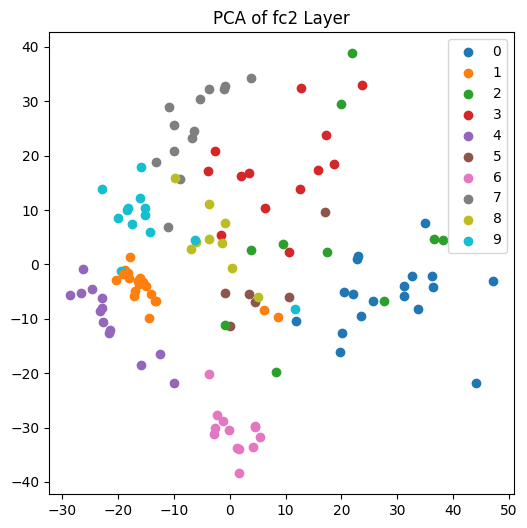

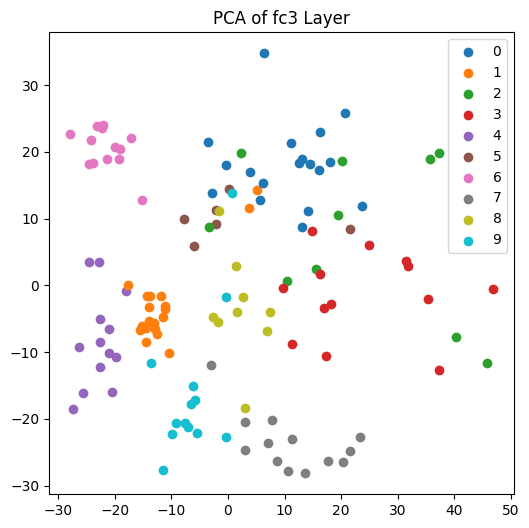

In [ ]:
plot_activations_pca(model, train_loader, device)

#### Plot of t-SNE of Activations

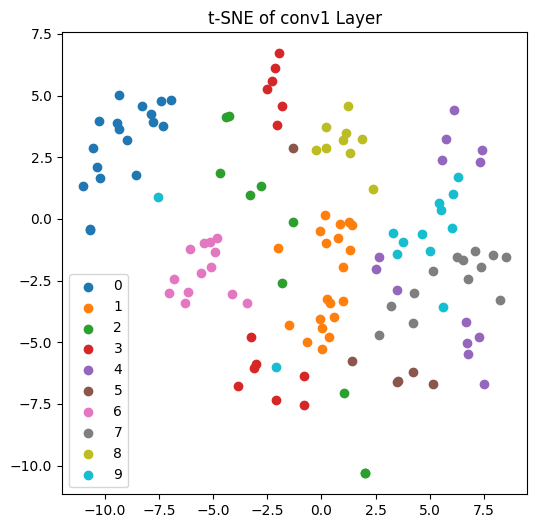

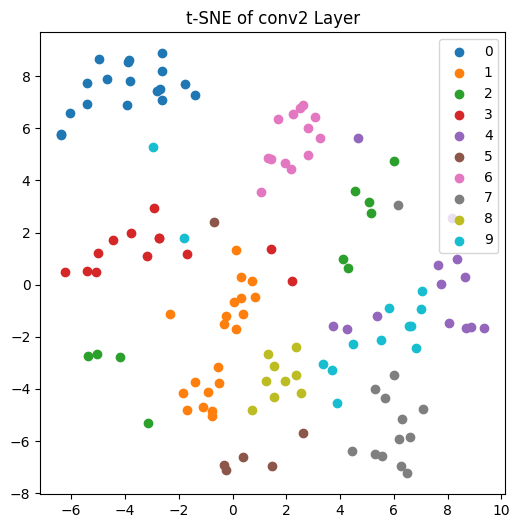

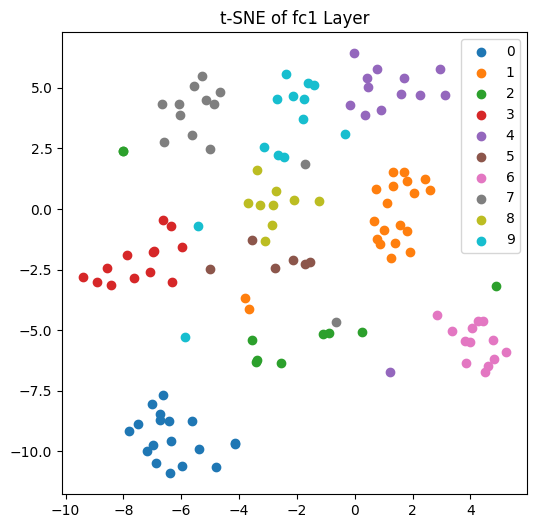

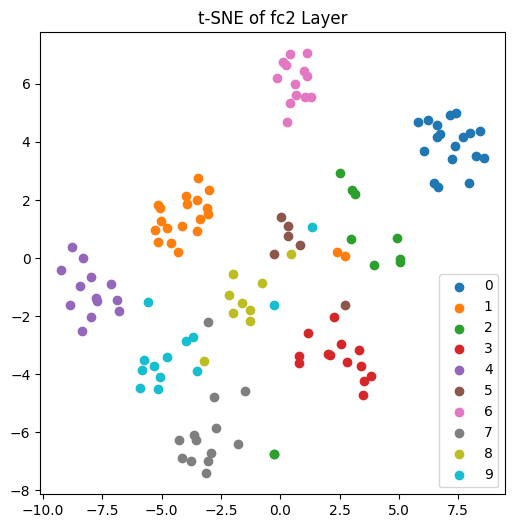

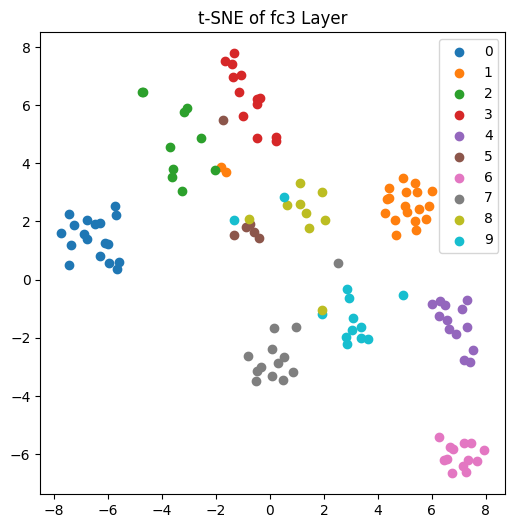

In [ ]:
plot_activations_tsne(model, train_loader, device)

#### Plots of Saliency Maps

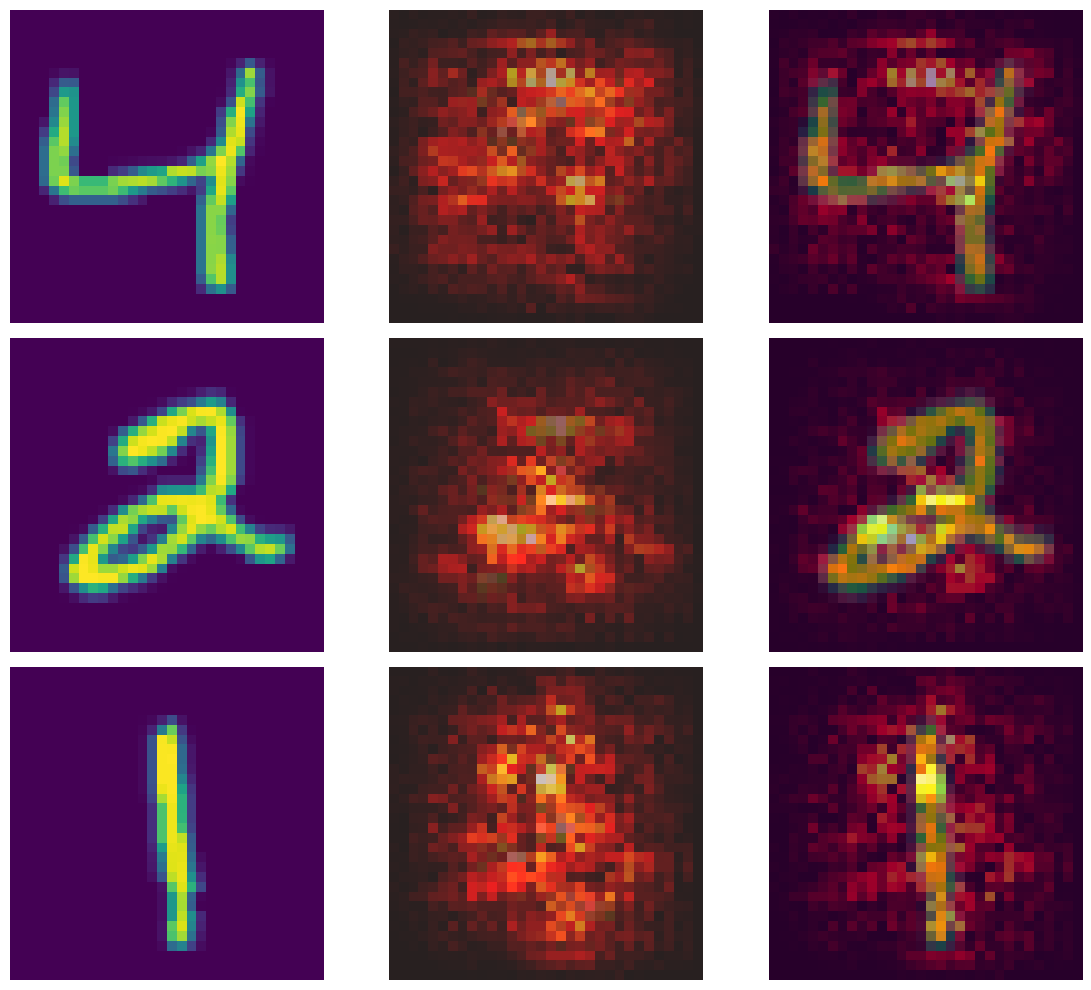

In [ ]:
plot_saliency_maps(model, train_loader, num_images=9)

#### Plots of Occlusion Sensitivity

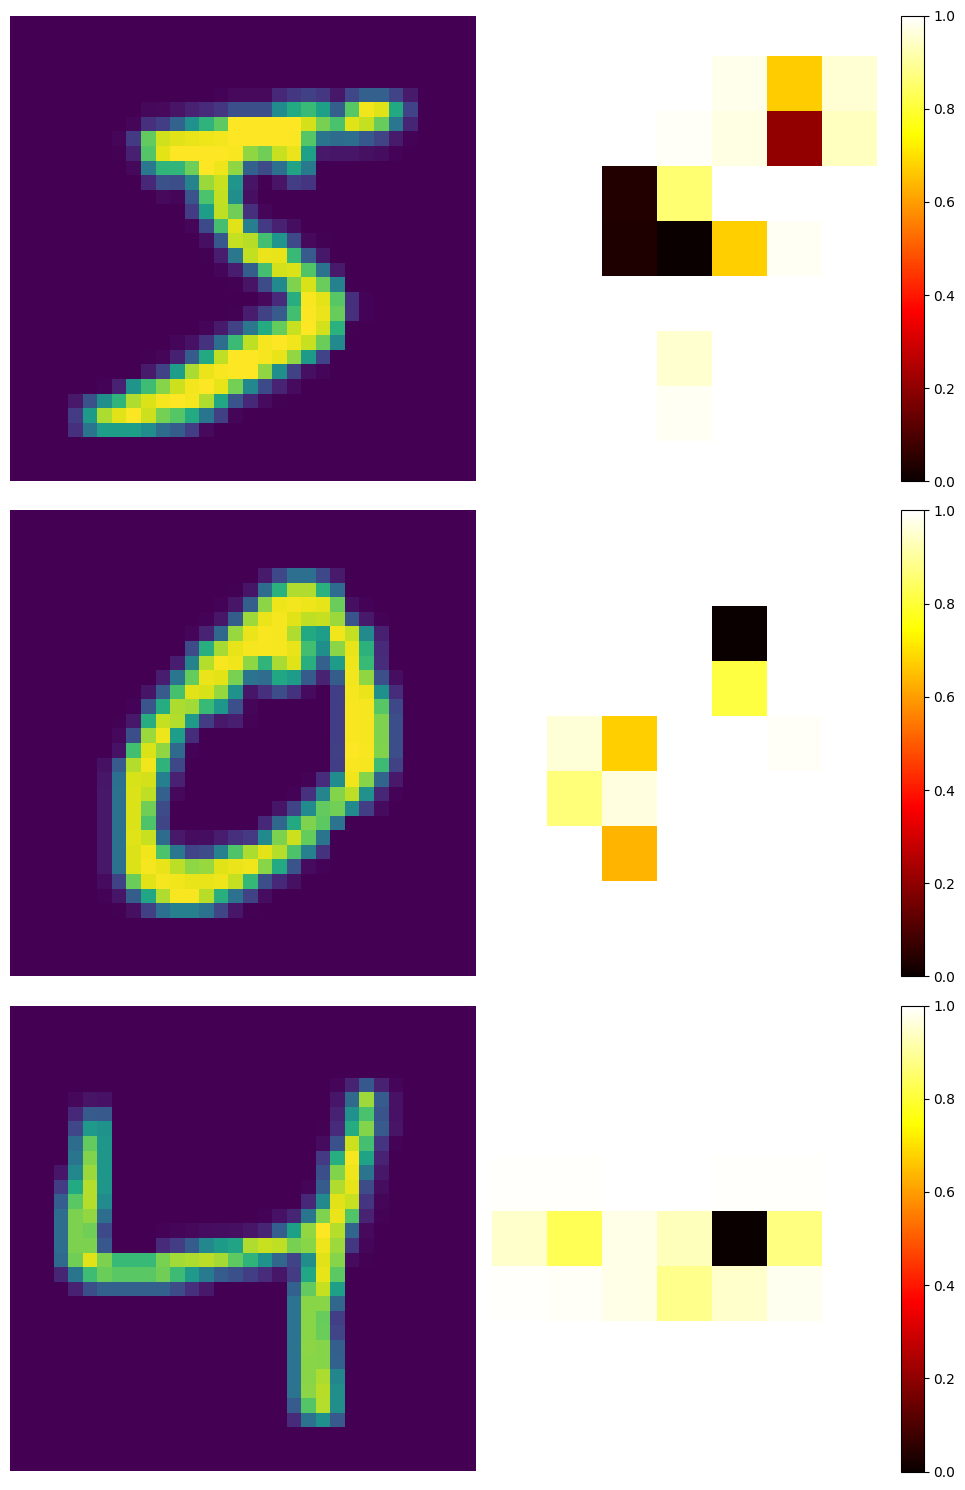

In [ ]:
plot_occlusion_sensitivity(model, train_loader, num_images=3, occluder_size=8, stride=4)

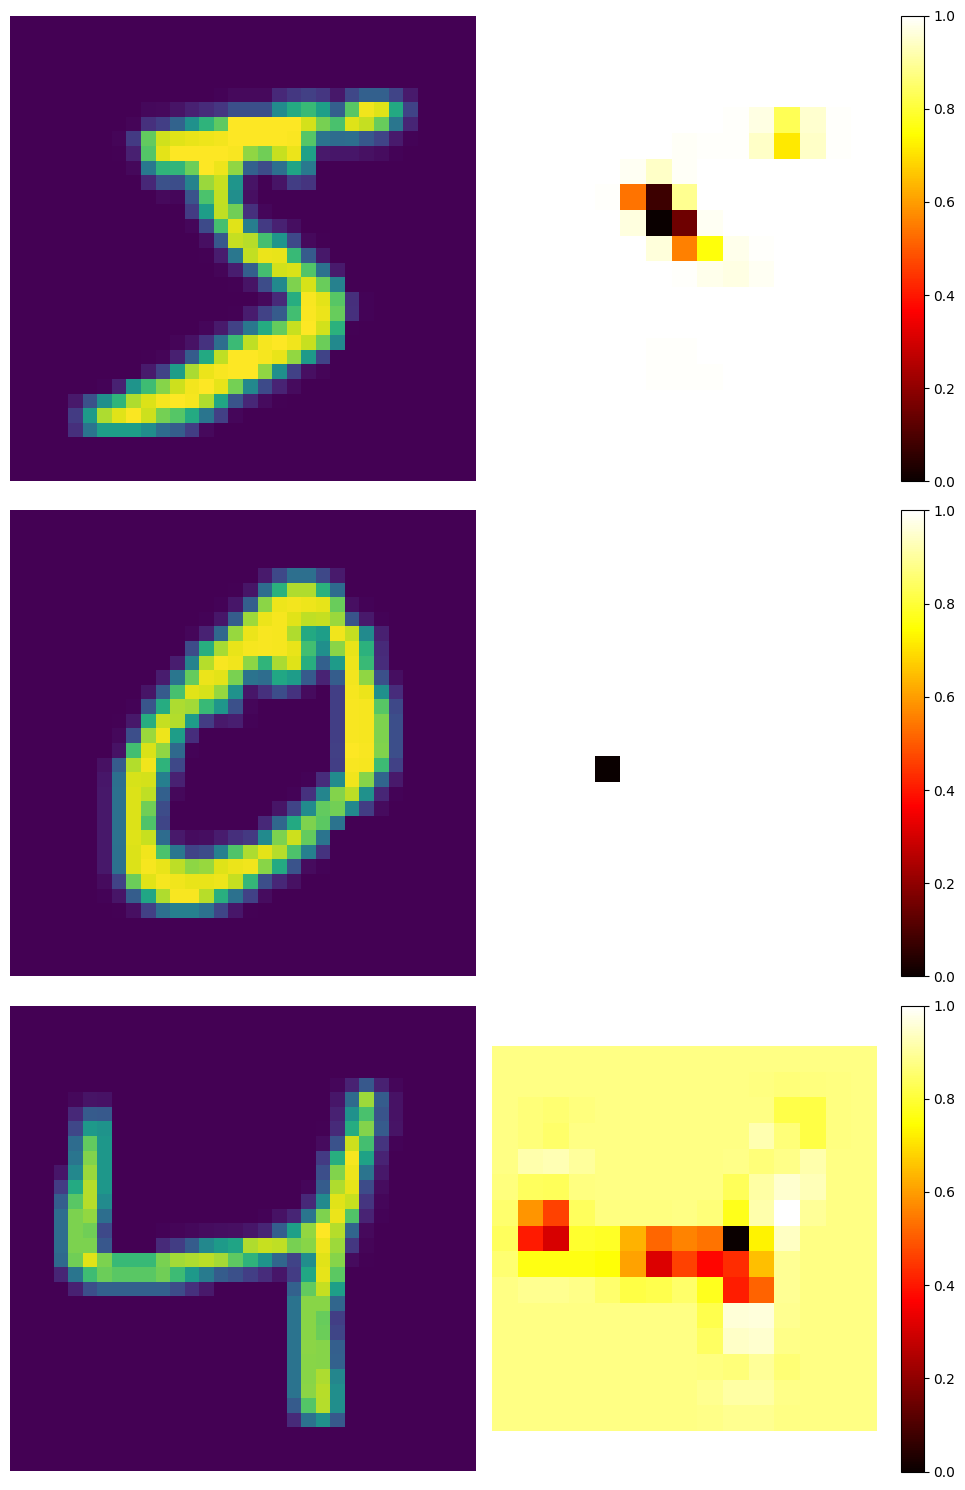

In [ ]:
plot_occlusion_sensitivity(model, train_loader, num_images=3, occluder_size=4, stride=2)

## Dropout Regularization

### Training

In [ ]:
model = LeNet(lr=lr, momentum=momentum, in_channels=in_channels, dropout_rate=0.2).to(
    device
)
n_epochs = 5
losses, reg_losses, epochs, weights, train_accuracies, test_accuracies = train(
    train_loader, test_loader, model, n_epochs
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0


 20%|██        | 1/5 [00:30<02:00, 30.06s/it]

Accuracy of the network on the test images: 76 %
Epoch: 1


 40%|████      | 2/5 [00:55<01:22, 27.46s/it]

Accuracy of the network on the test images: 83 %
Epoch: 2


 60%|██████    | 3/5 [01:21<00:53, 26.61s/it]

Accuracy of the network on the test images: 93 %
Epoch: 3


 80%|████████  | 4/5 [01:47<00:26, 26.28s/it]

Accuracy of the network on the test images: 95 %
Epoch: 4


100%|██████████| 5/5 [02:13<00:00, 26.68s/it]

Accuracy of the network on the test images: 96 %


### Visualization

#### Plot of Losses and Accuracies

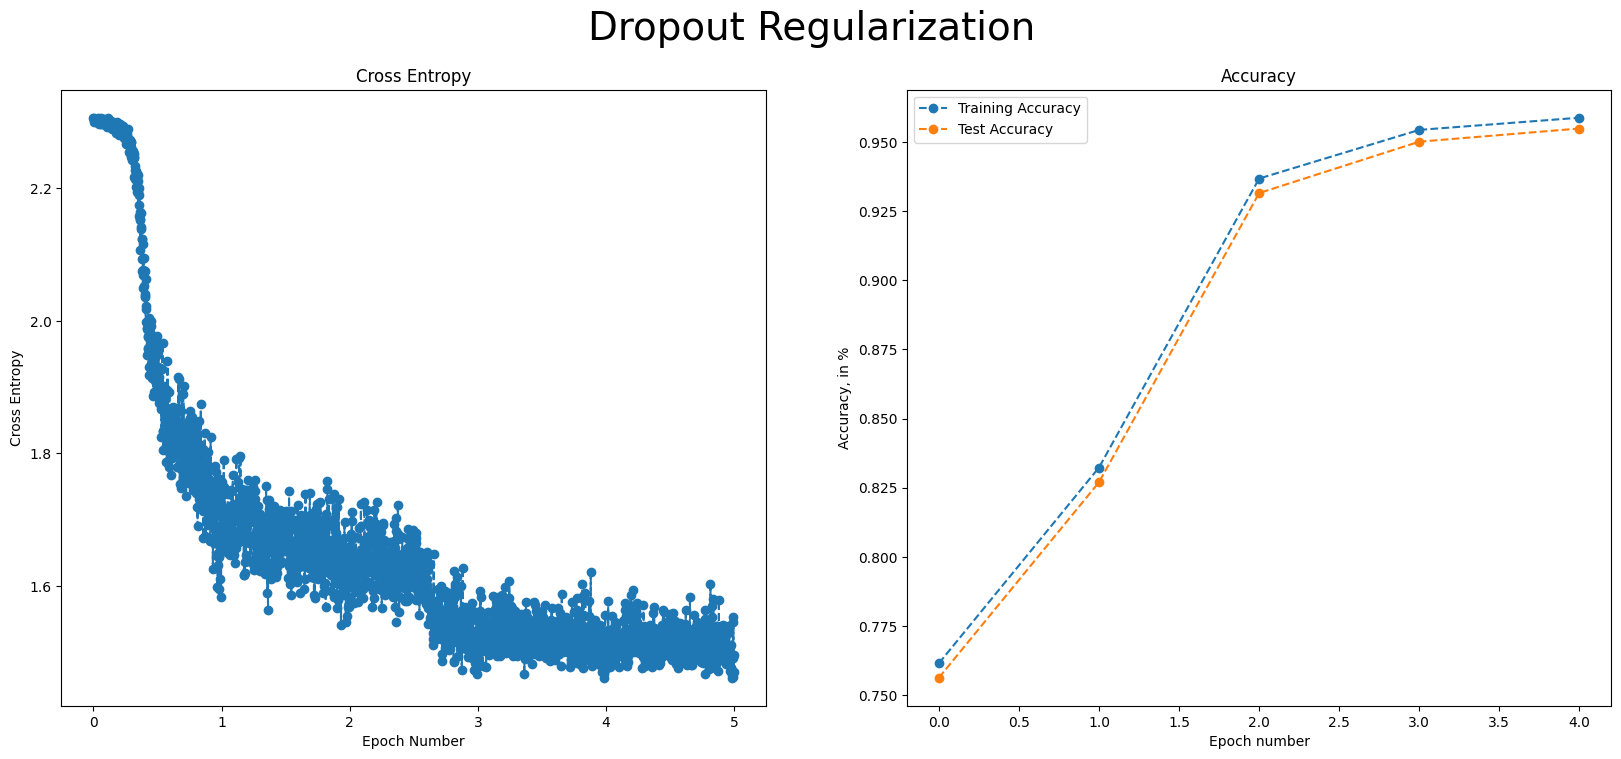

In [ ]:
plot_results(
    epochs, losses, train_accuracies, test_accuracies, title="Dropout Regularization"
)

#### Plot of Weight Distributions

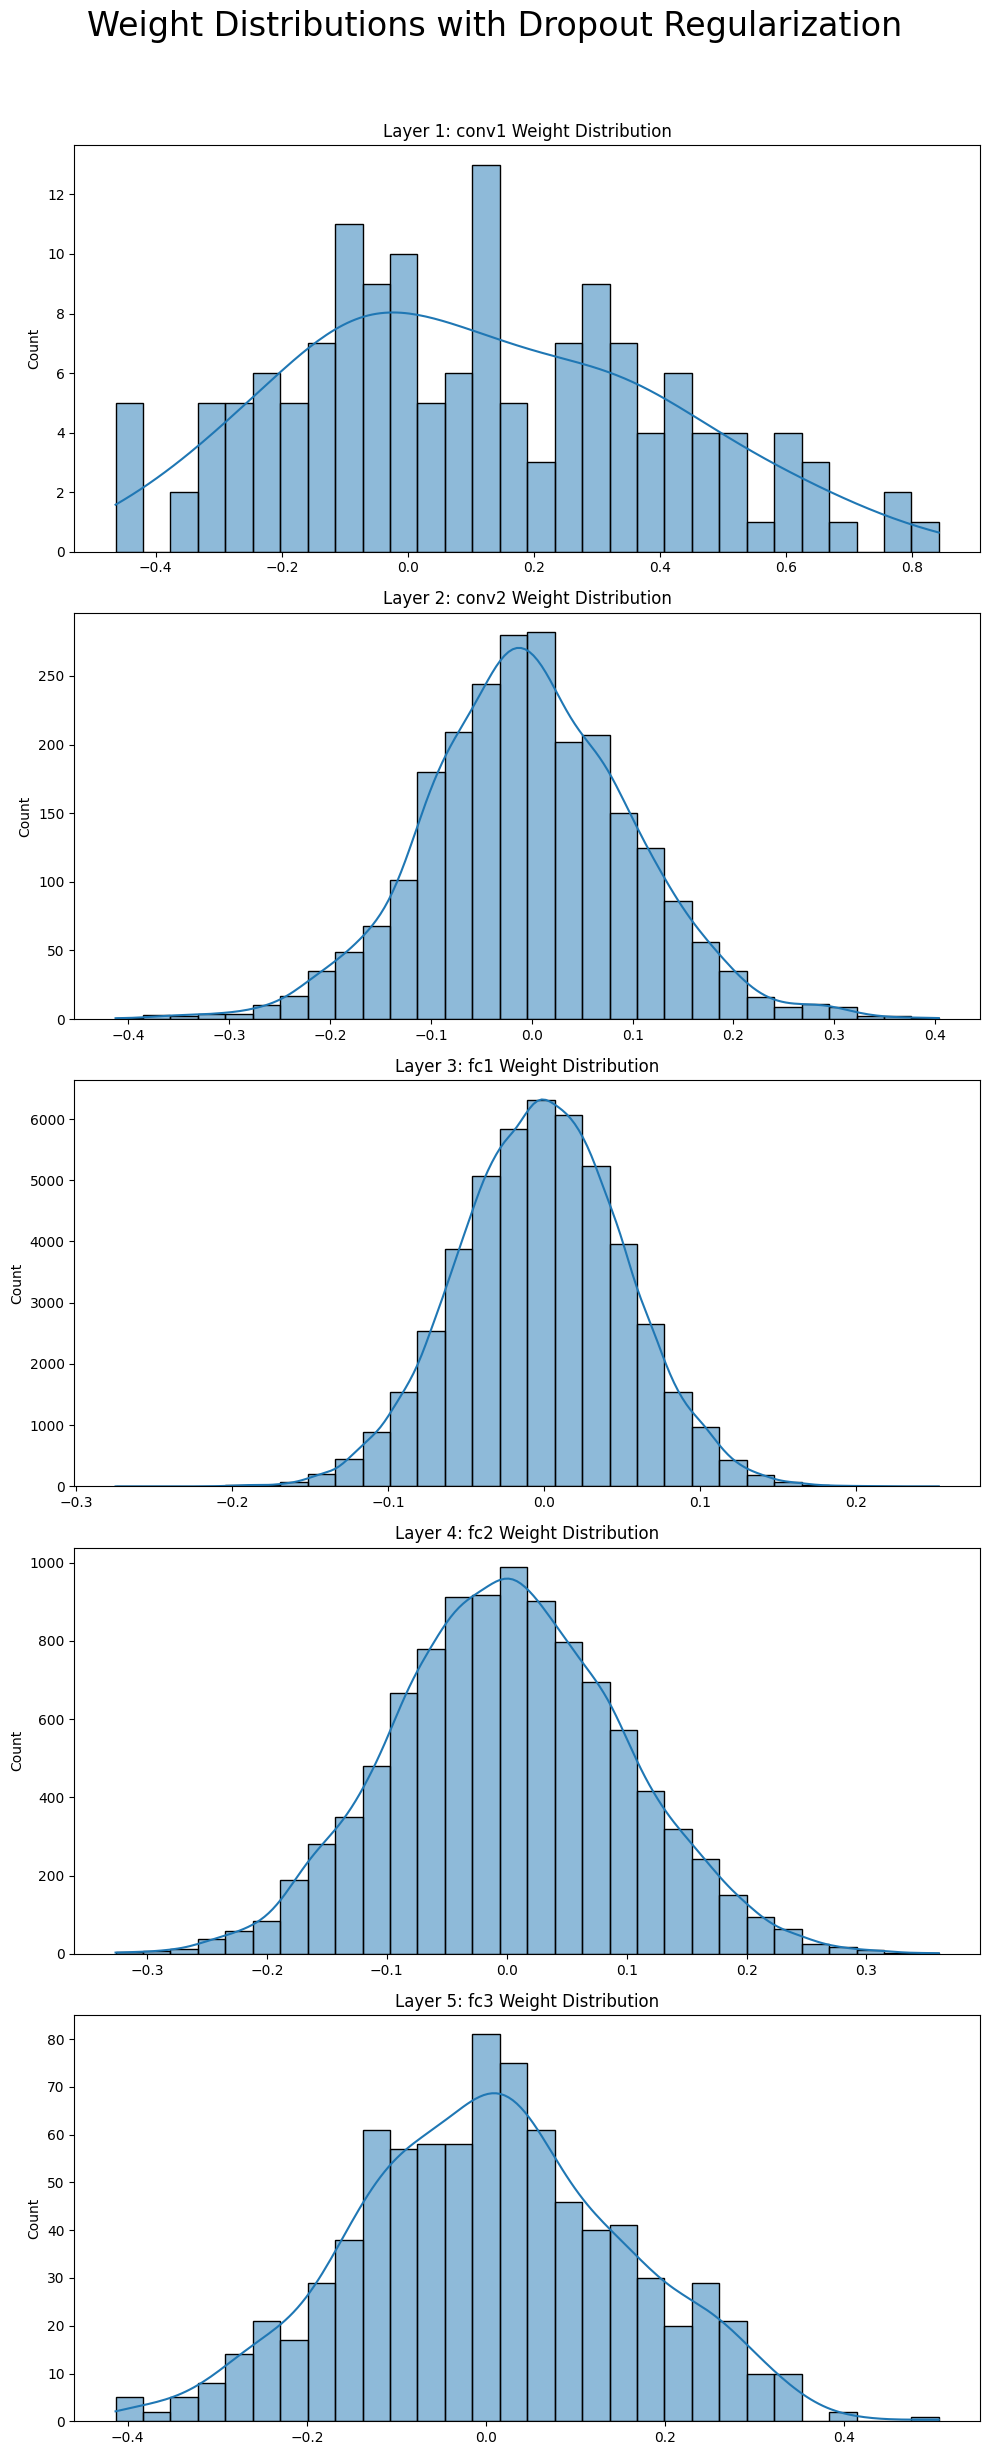

In [ ]:
plot_weight_distributions(
    model, title="Weight Distributions with Dropout Regularization"
)

#### Plots of Activation Maps

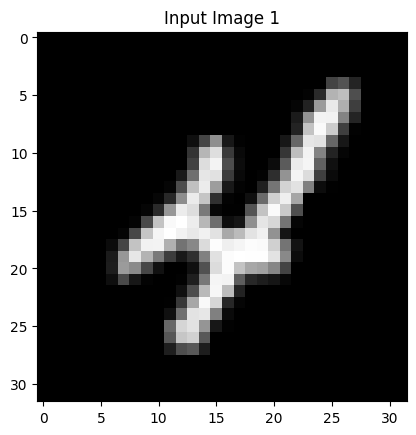

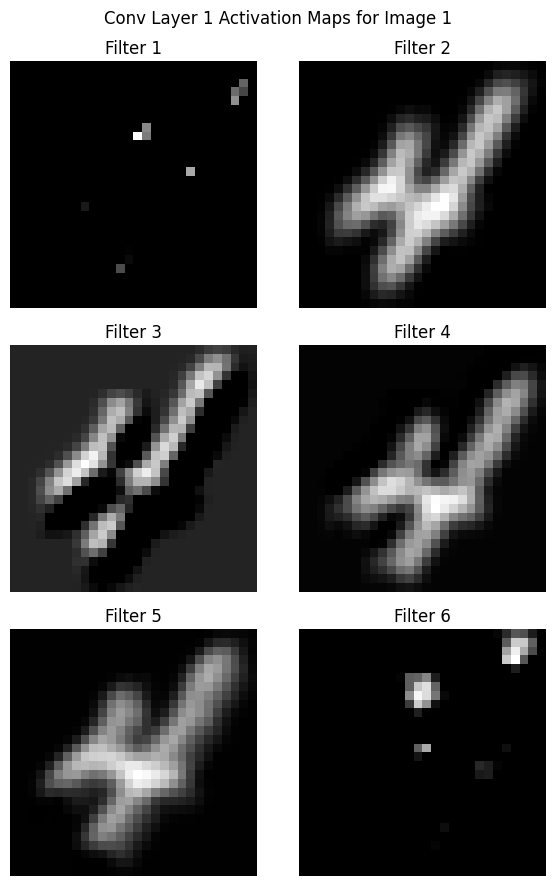

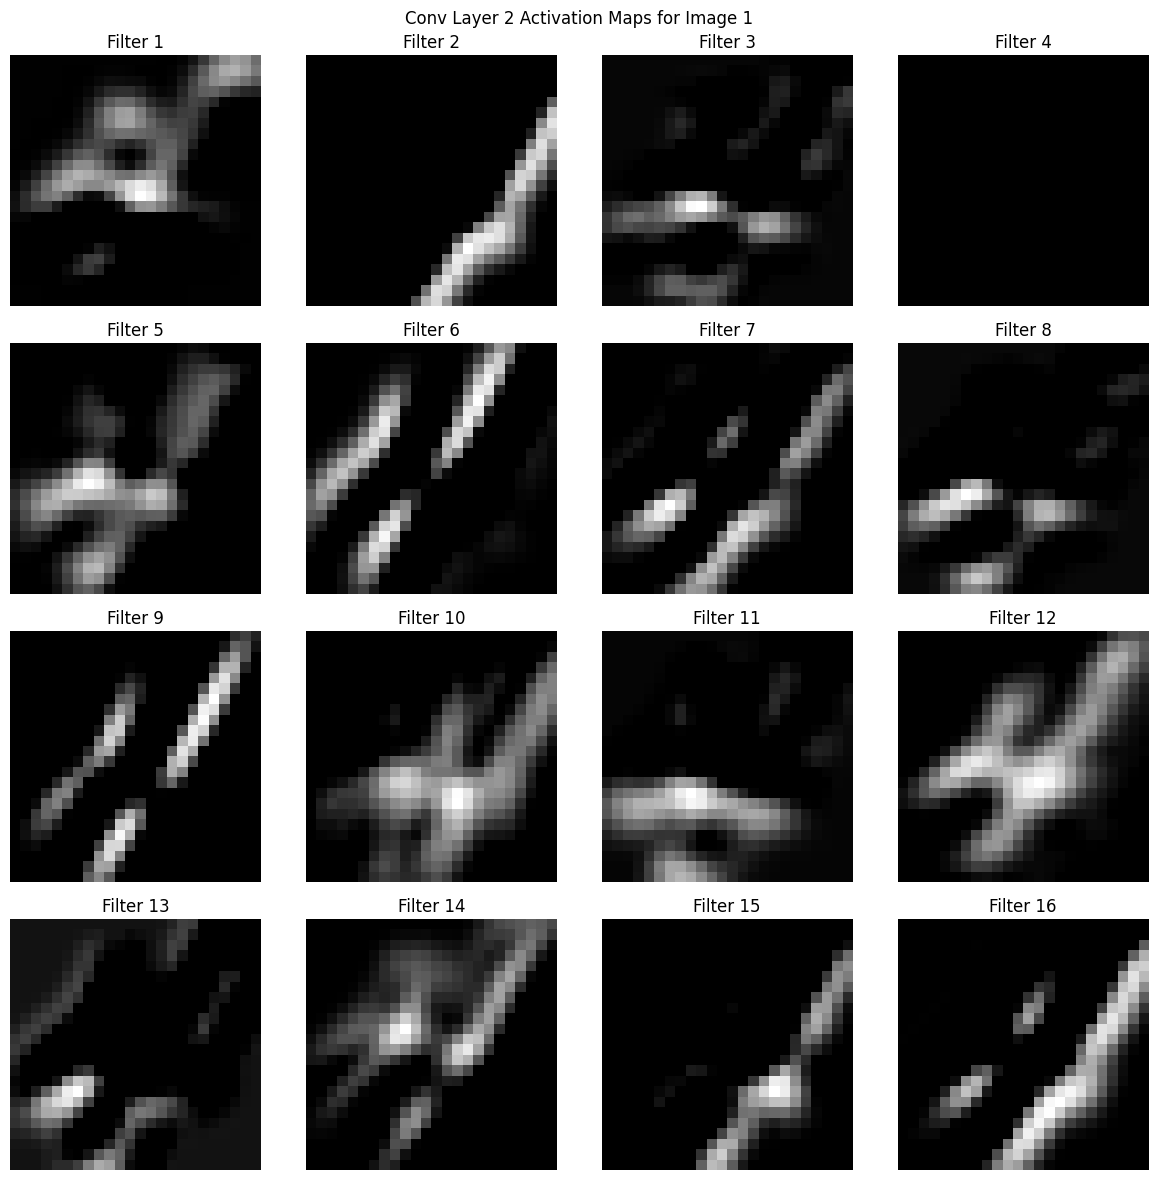

In [ ]:
plot_activation_maps(model, train_loader, num_images=1)

#### Plot of Predicted Probabilities

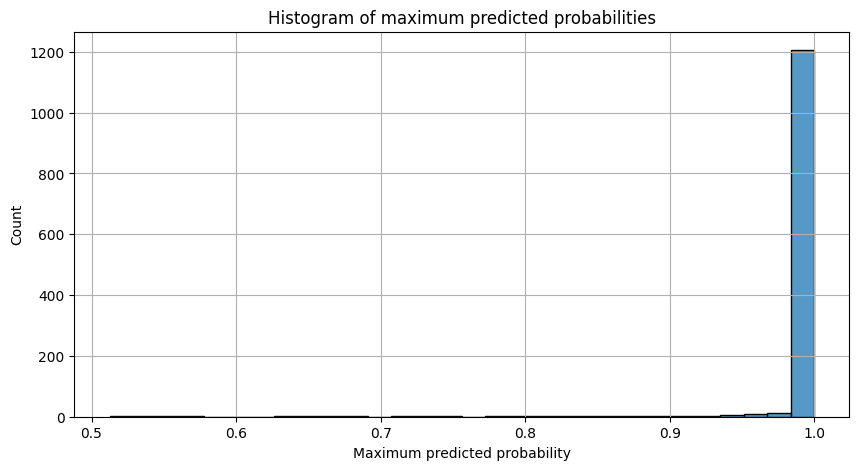

In [ ]:
plot_predicted_probabilities(model, train_loader, num_batches=10)

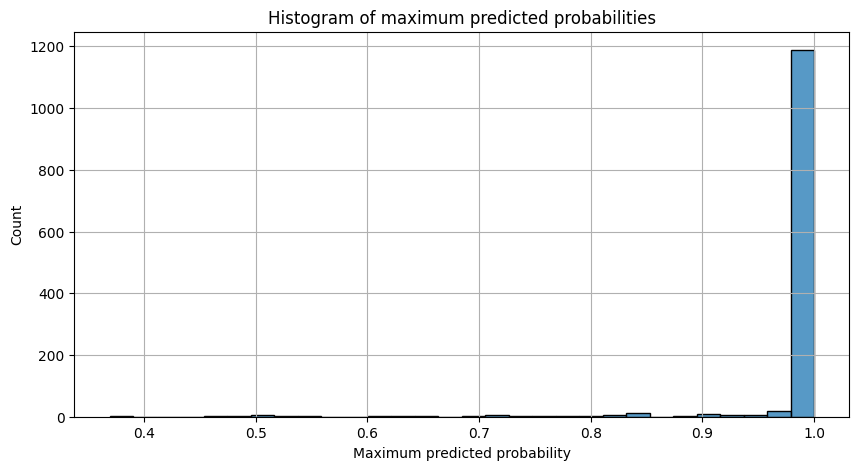

In [ ]:
plot_predicted_probabilities(model, test_loader, num_batches=10)

#### Plot of PCA of Activations

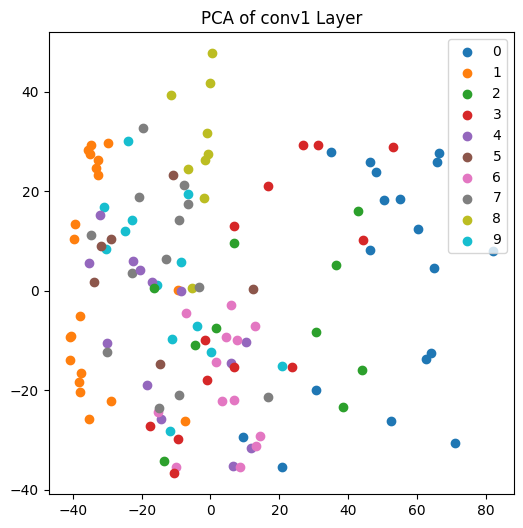

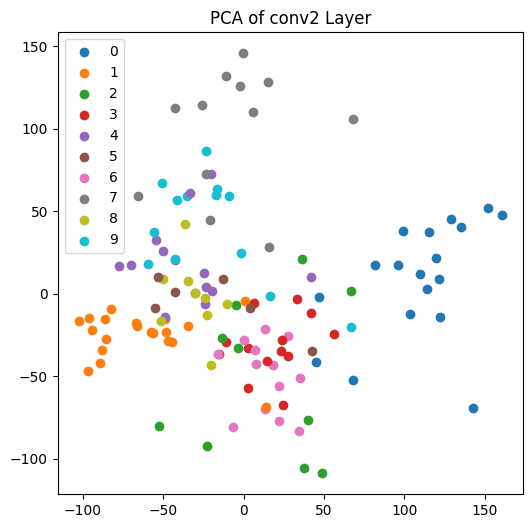

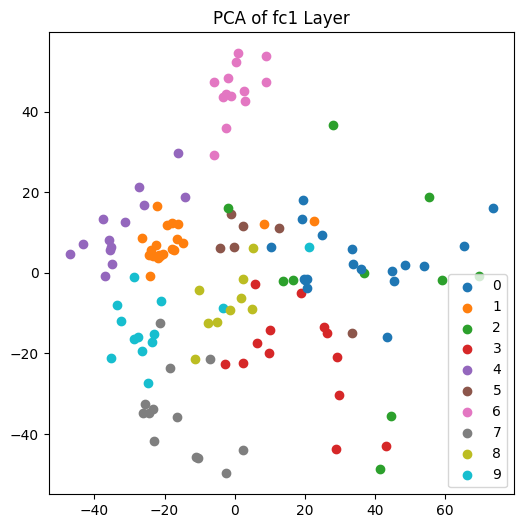

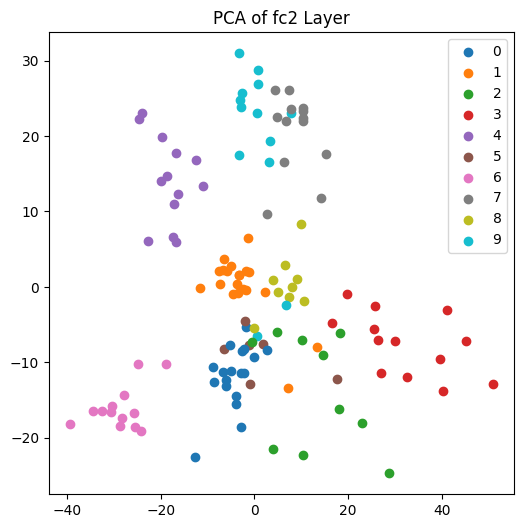

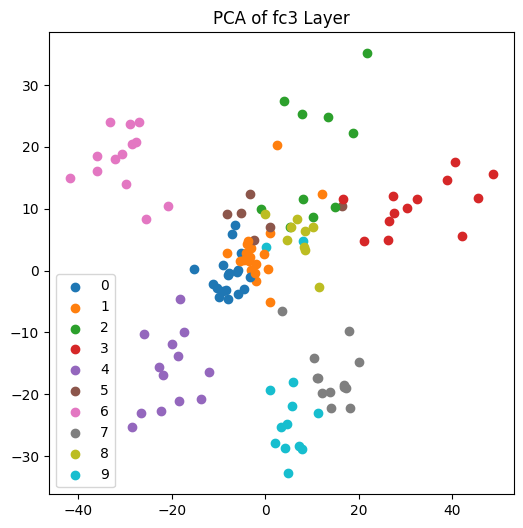

In [ ]:
plot_activations_pca(model, train_loader, device)

#### Plot of t-SNE of Activations

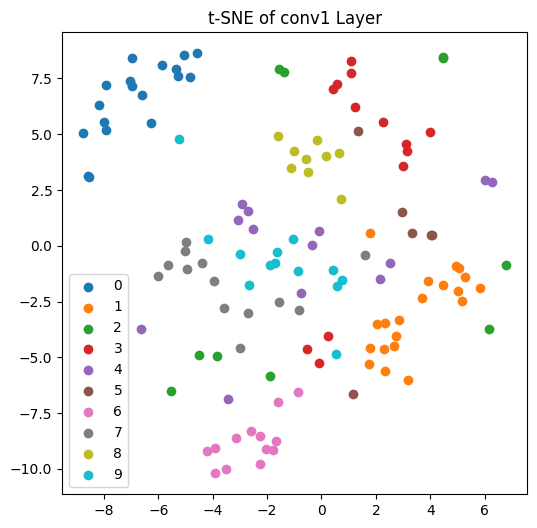

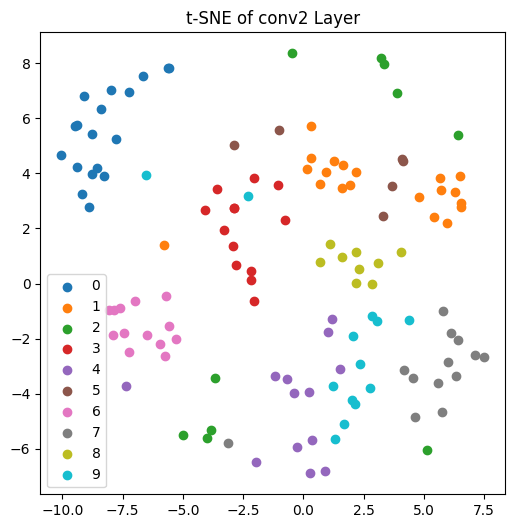

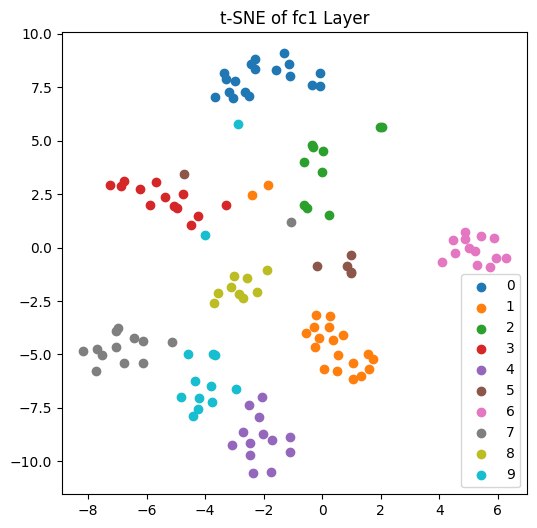

In [ ]:
plot_activations_tsne(model, train_loader, device)

#### Plots of Saliency Maps

In [ ]:
plot_saliency_maps(model, train_loader, num_images=9)

#### Plots of Occlusion Sensitivity

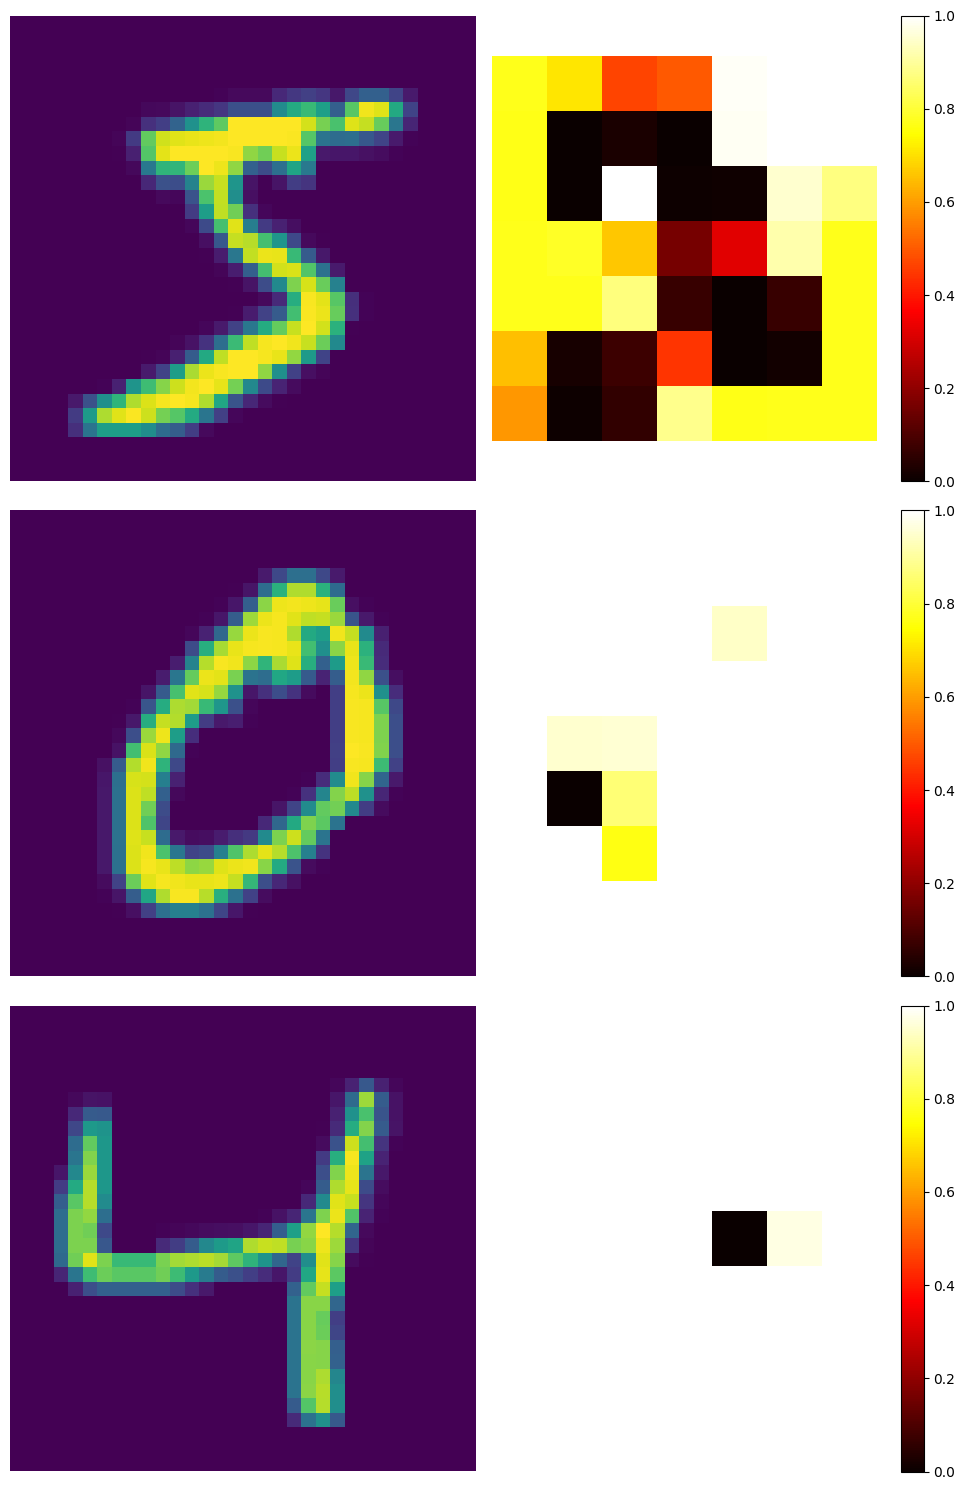

In [ ]:
plot_occlusion_sensitivity(model, train_loader, num_images=3, occluder_size=8, stride=4)

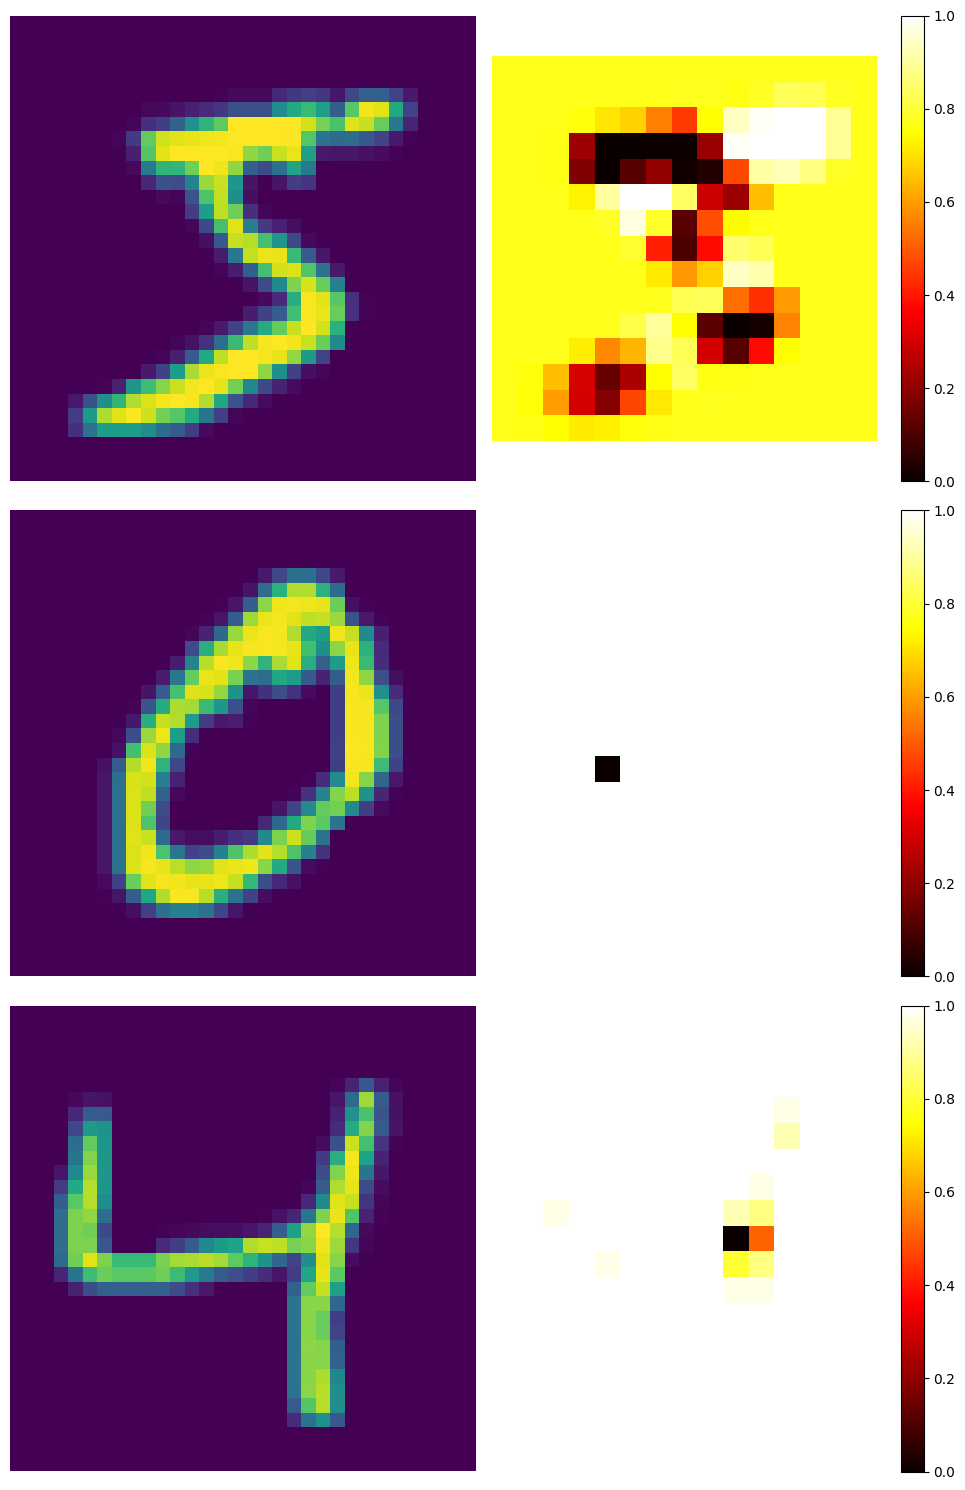

In [ ]:
plot_occlusion_sensitivity(model, train_loader, num_images=3, occluder_size=4, stride=2)

## Confidence Penalty Regularization

### Training

In [ ]:
model = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
n_epochs = 3
losses, reg_losses, epochs, weights, train_accuracies, test_accuracies = train(
    train_loader,
    test_loader,
    model,
    n_epochs,
    conf_penalty=True,
    conf_penalty_lmbd=0.03,
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0


 33%|███▎      | 1/3 [00:27<00:54, 27.18s/it]

Accuracy of the network on the test images: 49 %
Epoch: 1


 67%|██████▋   | 2/3 [00:54<00:27, 27.50s/it]

Accuracy of the network on the test images: 63 %
Epoch: 2


100%|██████████| 3/3 [01:24<00:00, 28.24s/it]

Accuracy of the network on the test images: 68 %


### Visualization

#### Plot of Losses and Accuracies

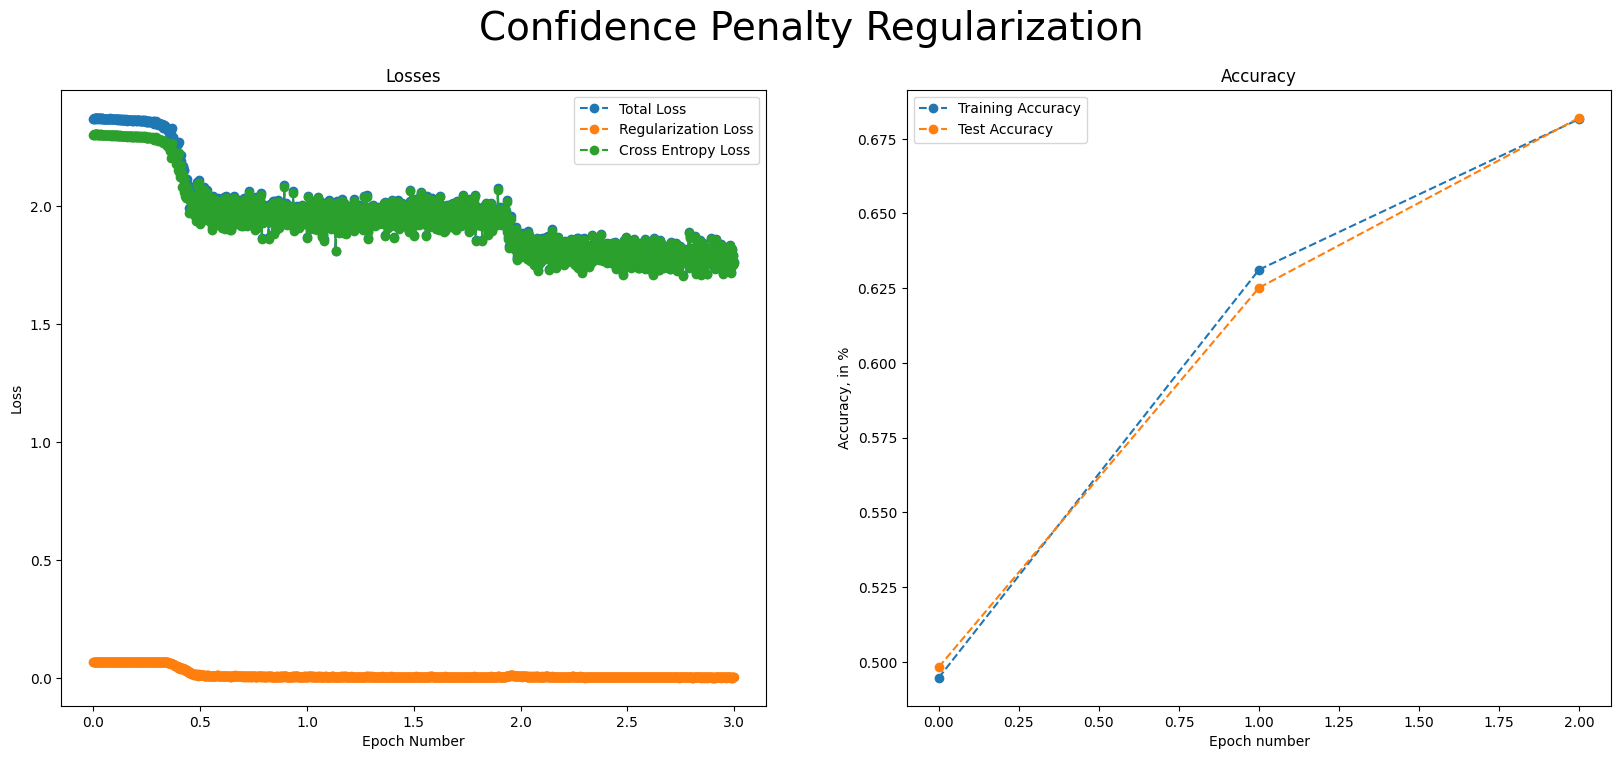

In [ ]:
plot_reg_results(
    epochs,
    losses,
    reg_losses,
    train_accuracies,
    test_accuracies,
    title="Confidence Penalty Regularization",
)

#### Plot of Weight Distributions

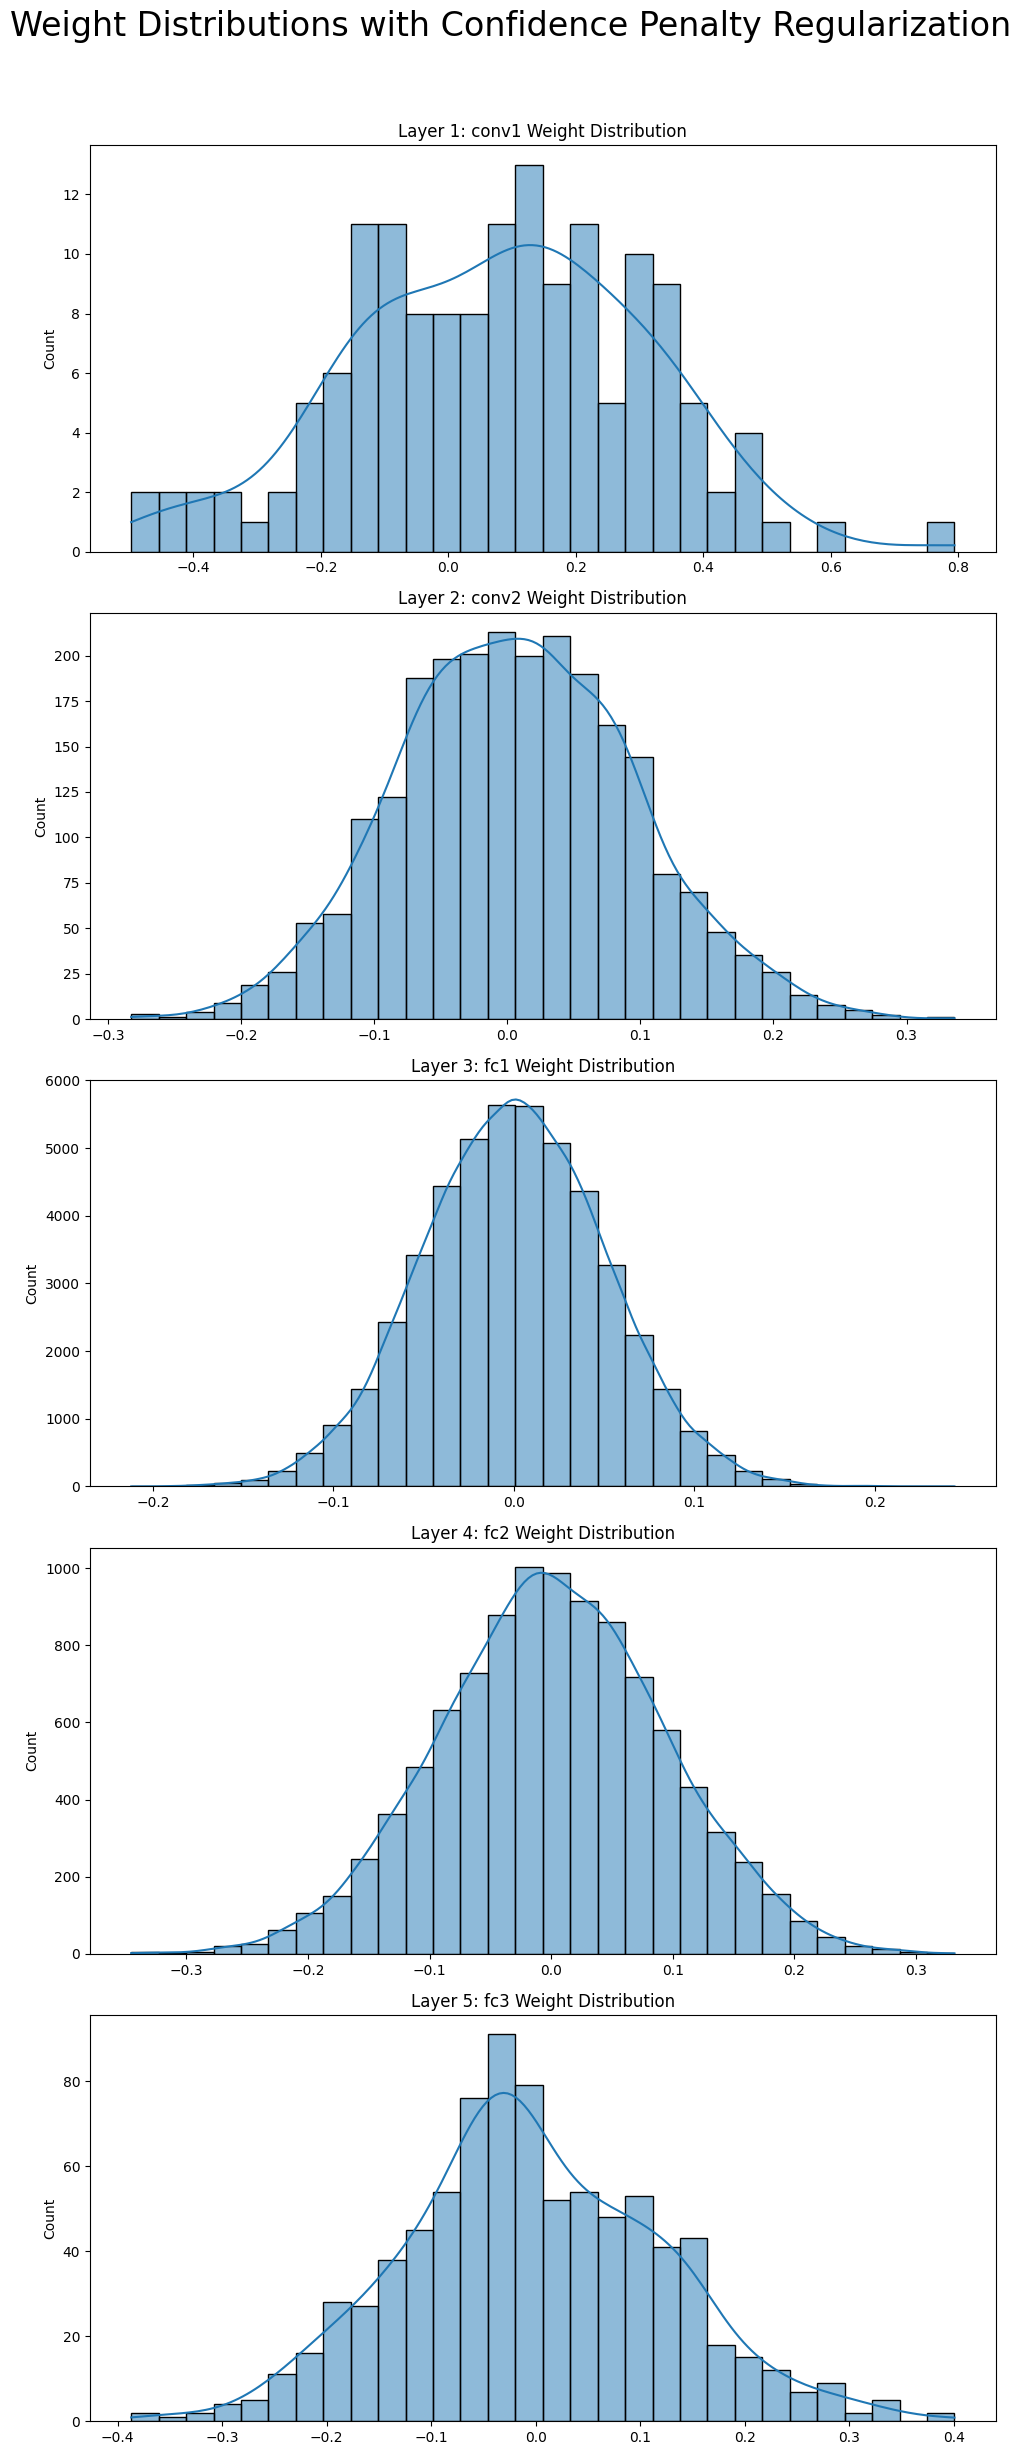

In [ ]:
plot_weight_distributions(
    model, title="Weight Distributions with Confidence Penalty Regularization"
)

#### Plots of Activation Maps

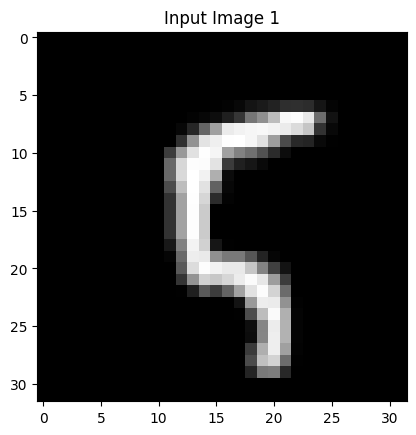

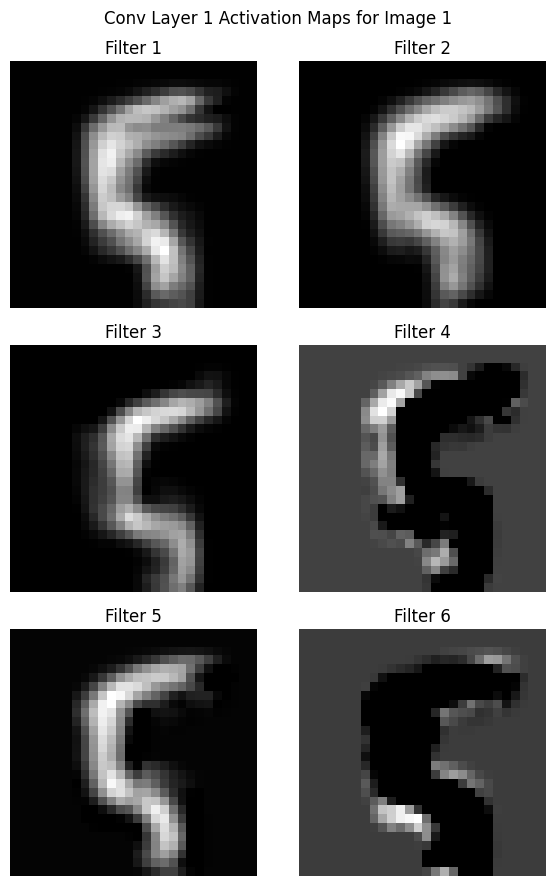

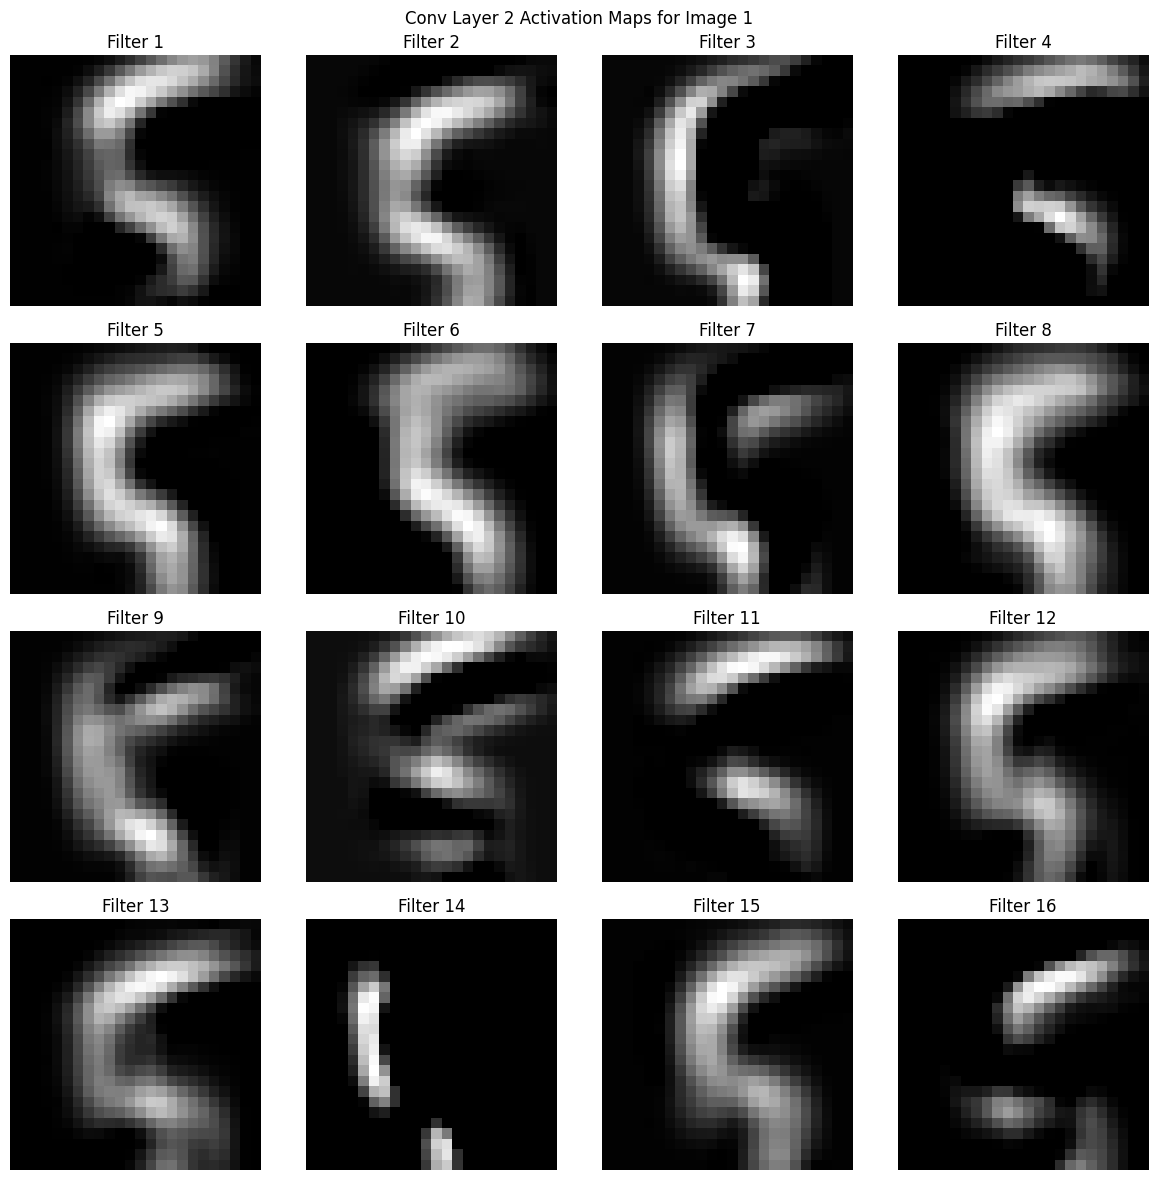

In [ ]:
plot_activation_maps(model, train_loader, num_images=1)

#### Plot of Predicted Probabilities

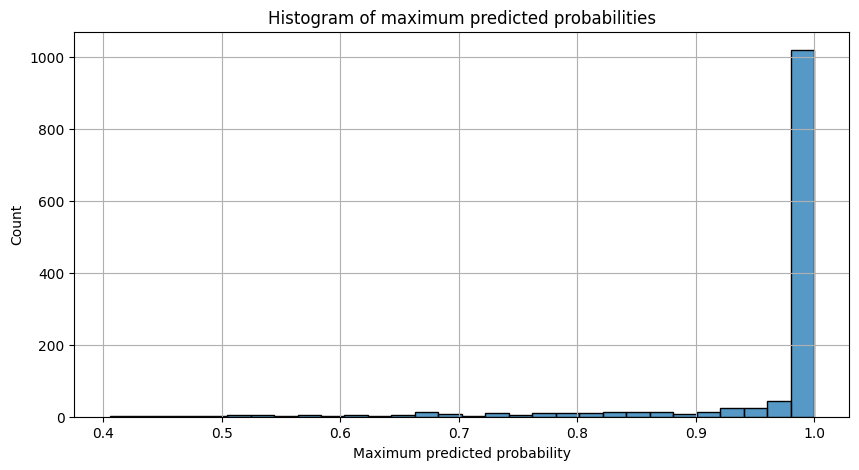

In [ ]:
plot_predicted_probabilities(model, train_loader, num_batches=10)

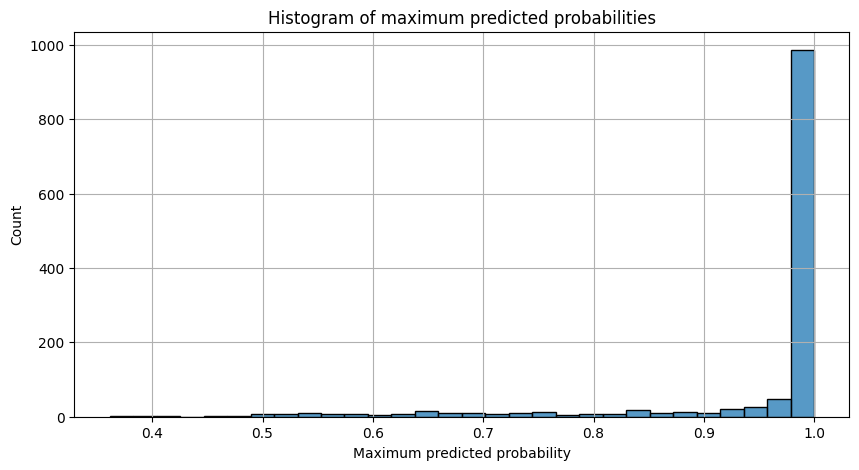

In [ ]:
plot_predicted_probabilities(model, test_loader, num_batches=10)

#### Plot of PCA of Activations

In [ ]:
plot_activations_pca(model, train_loader, device)

#### Plot of t-SNE of Activations

In [ ]:
plot_activations_tsne(model, train_loader, device)

#### Plots of Saliency Maps

In [ ]:
plot_saliency_maps(model, train_loader, num_images=9)

#### Plots of Occlusion Sensitivity

In [ ]:
plot_occlusion_sensitivity(model, train_loader, num_images=3, occluder_size=8, stride=4)

In [ ]:
plot_occlusion_sensitivity(model, train_loader, num_images=3, occluder_size=4, stride=2)

## Label Smoothing Regularization

### Training

In [ ]:
model = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
n_epochs = 3
losses, reg_losses, epochs, weights, train_accuracies, test_accuracies = train(
    train_loader,
    test_loader,
    model,
    n_epochs,
    label_smoothing=True,
    label_smoothing_lmbd=0.000001,
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0


 33%|███▎      | 1/3 [00:26<00:52, 26.38s/it]

Accuracy of the network on the test images: 11 %
Epoch: 1


 67%|██████▋   | 2/3 [00:52<00:26, 26.45s/it]

Accuracy of the network on the test images: 10 %
Epoch: 2


100%|██████████| 3/3 [01:19<00:00, 26.44s/it]

Accuracy of the network on the test images: 10 %


### Visualization

#### Plot of Losses and Accuracies

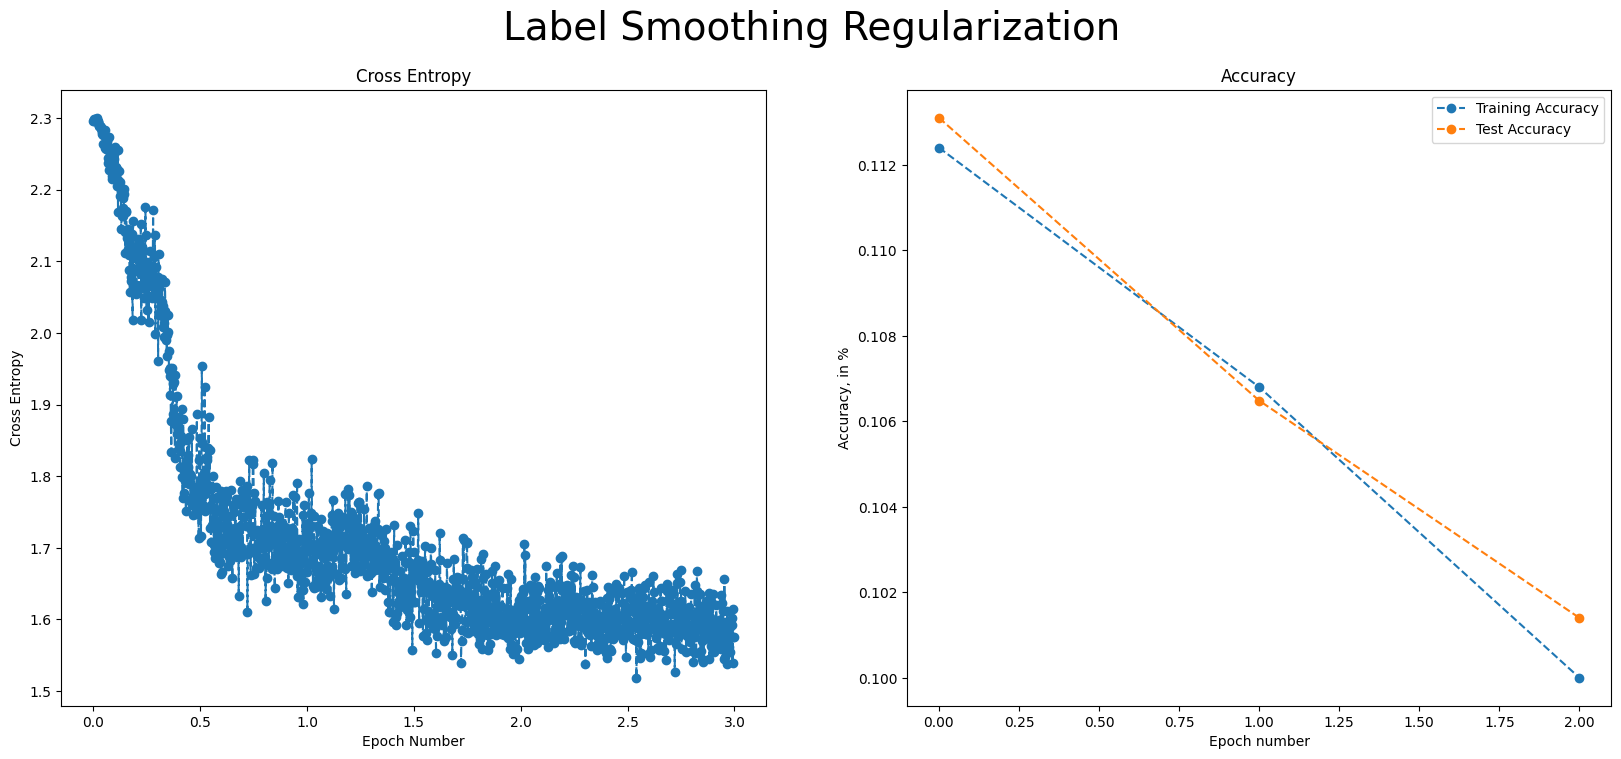

In [ ]:
plot_results(
    epochs,
    losses,
    train_accuracies,
    test_accuracies,
    title="Label Smoothing Regularization",
)

#### Plot of Weight Distributions

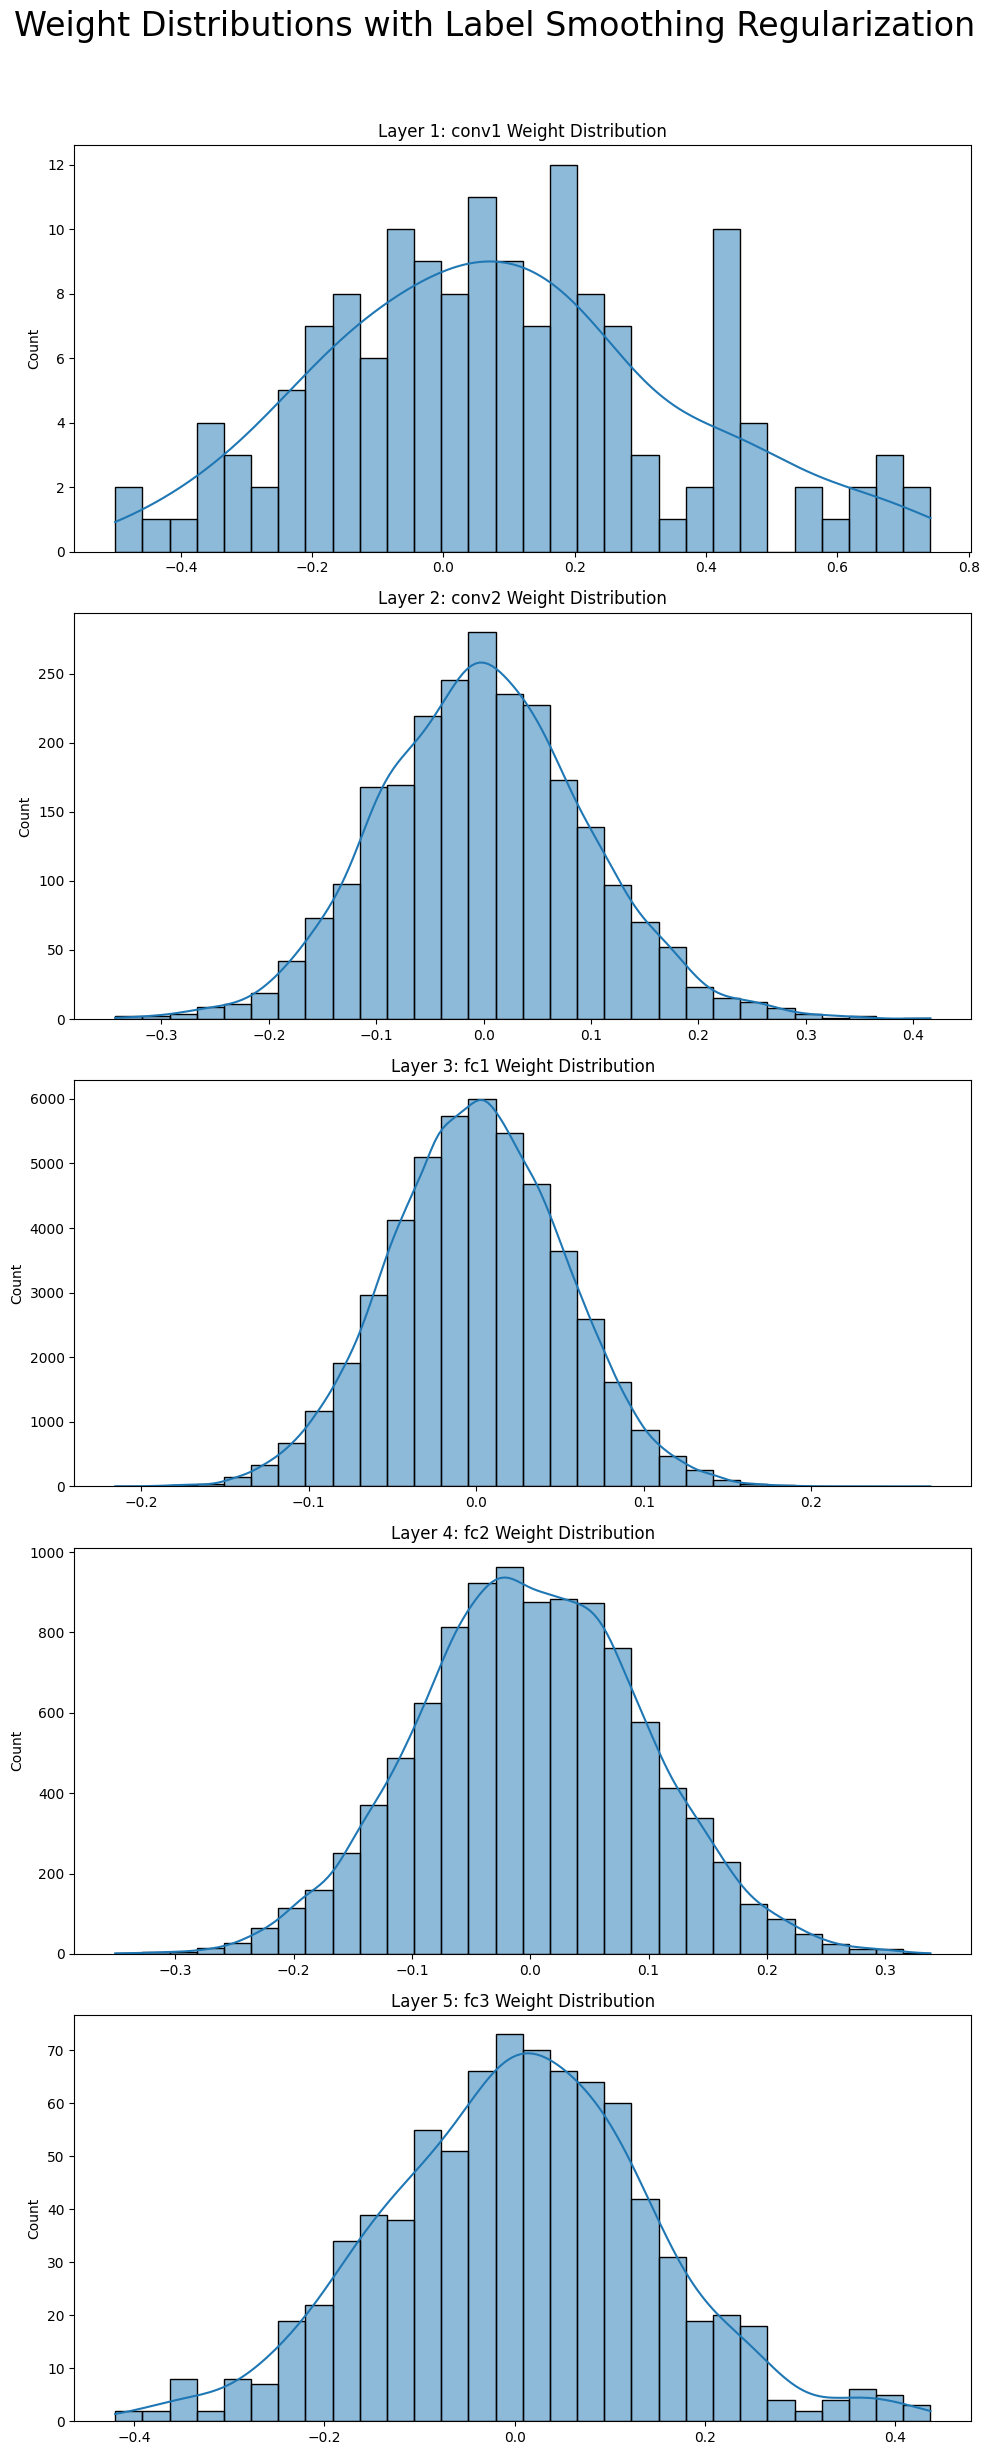

In [ ]:
plot_weight_distributions(
    model, title="Weight Distributions with Label Smoothing Regularization"
)

#### Plots of Activation Maps

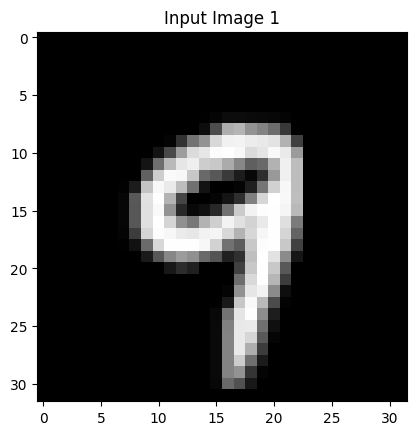

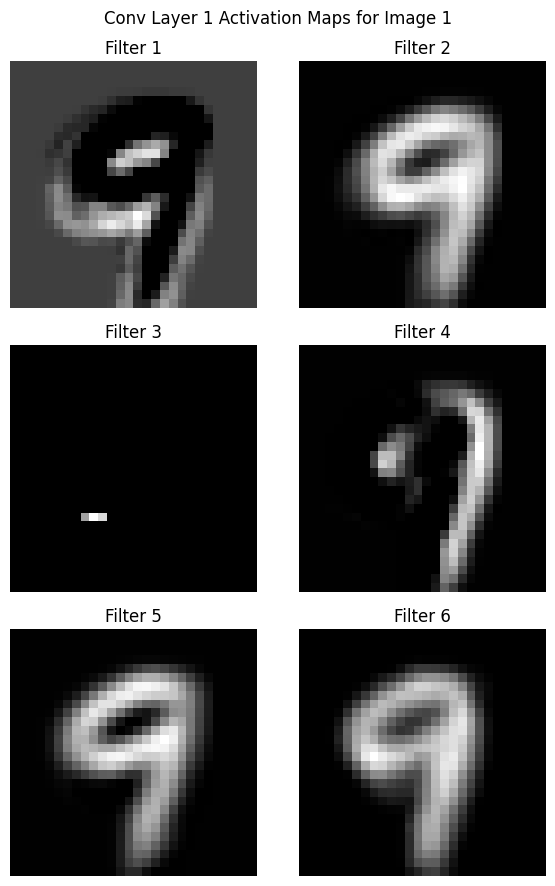

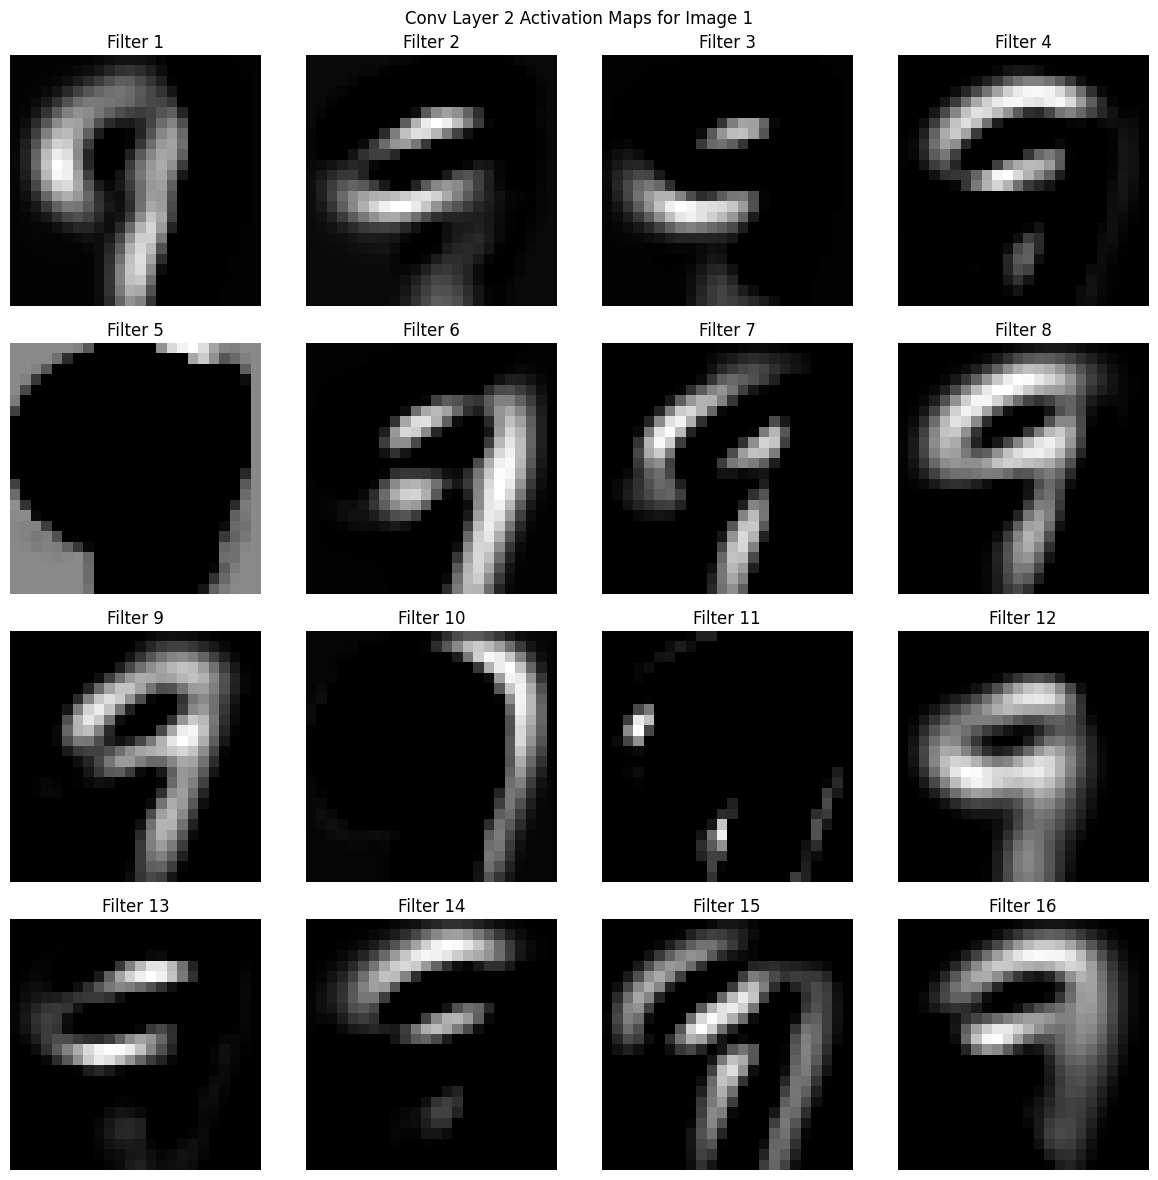

In [ ]:
plot_activation_maps(model, train_loader, num_images=1)

#### Plot of Predicted Probabilities

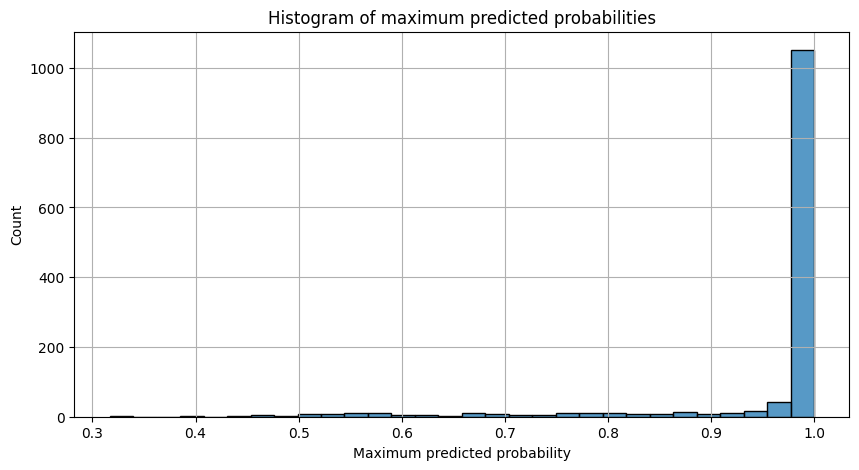

In [ ]:
plot_predicted_probabilities(model, train_loader, num_batches=10)

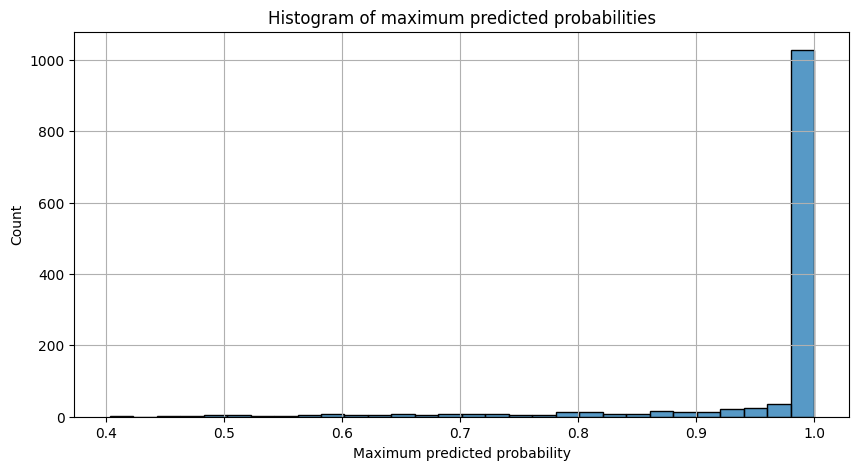

In [ ]:
plot_predicted_probabilities(model, test_loader, num_batches=10)

#### Plot of PCA of Activations

In [ ]:
plot_activations_pca(model, train_loader, device)

#### Plot of t-SNE of Activations

In [ ]:
plot_activations_tsne(model, train_loader, device)

#### Plots of Saliency Maps

In [ ]:
plot_saliency_maps(model, train_loader, num_images=9)

#### Plots of Occlusion Sensitivity

In [ ]:
plot_occlusion_sensitivity(model, train_loader, num_images=3, occluder_size=8, stride=4)

In [ ]:
plot_occlusion_sensitivity(model, train_loader, num_images=3, occluder_size=4, stride=2)

## Noise Injection (to inputs)

### Training

In [ ]:
model = LeNet(
    lr=lr,
    momentum=momentum,
    in_channels=in_channels,
    noise_inject_input=True,
    noise_stddev=0.05,
).to(device)
n_epochs = 5
losses, reg_losses, epochs, weights, train_accuracies, test_accuracies = train(
    train_loader, test_loader, model, n_epochs
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0


 20%|██        | 1/5 [00:27<01:49, 27.28s/it]

Accuracy of the network on the test images: 84 %
Epoch: 1


 40%|████      | 2/5 [00:54<01:22, 27.35s/it]

Accuracy of the network on the test images: 93 %
Epoch: 2


 60%|██████    | 3/5 [01:22<00:55, 27.68s/it]

Accuracy of the network on the test images: 96 %
Epoch: 3


 80%|████████  | 4/5 [01:50<00:27, 27.86s/it]

Accuracy of the network on the test images: 96 %
Epoch: 4


100%|██████████| 5/5 [02:18<00:00, 27.68s/it]

Accuracy of the network on the test images: 96 %


### Visualization

#### Plot of Losses and Accuracies

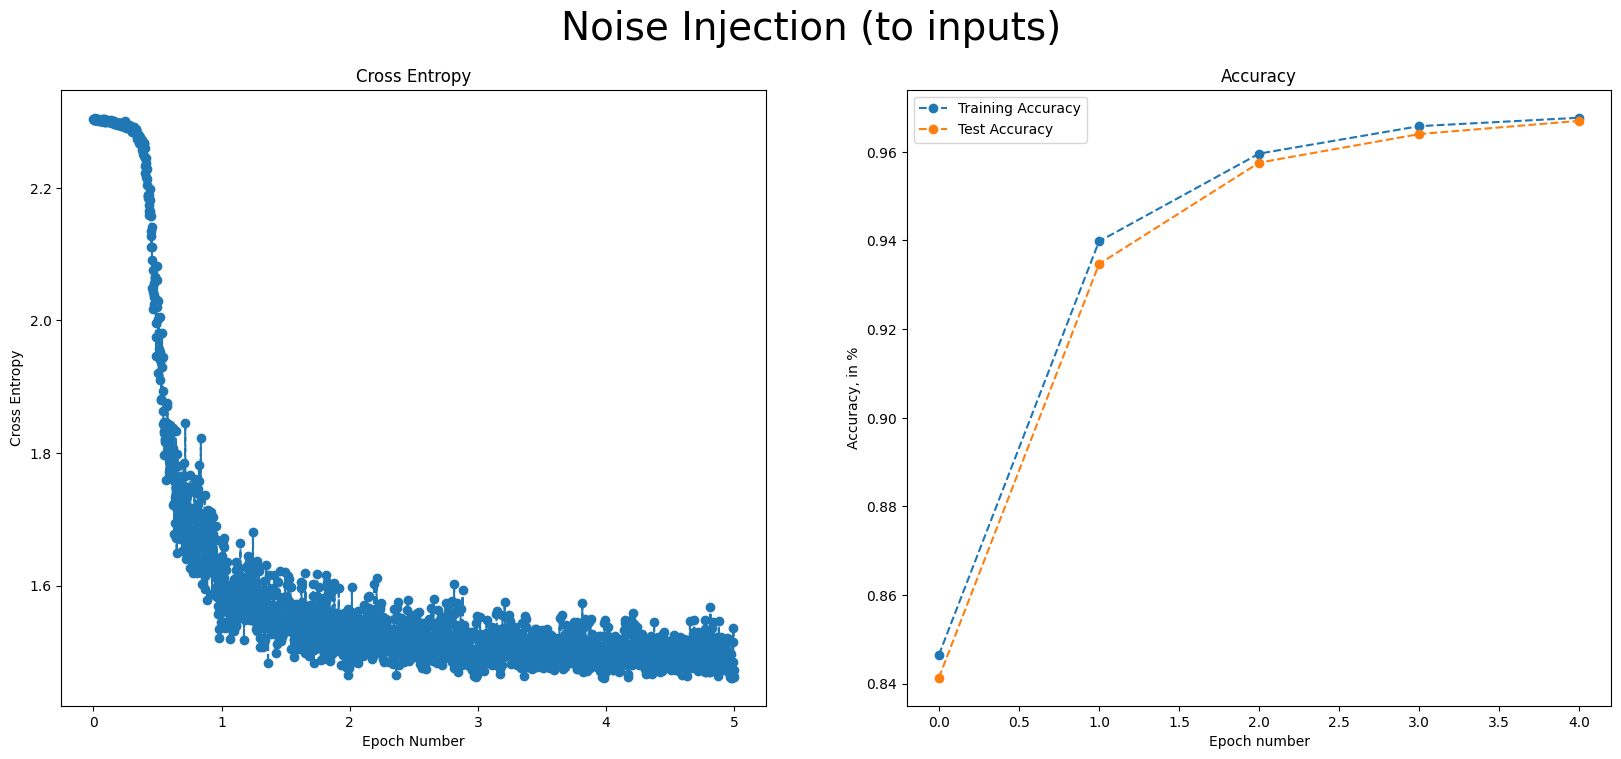

In [ ]:
plot_results(
    epochs,
    losses,
    train_accuracies,
    test_accuracies,
    title="Noise Injection (to inputs)",
)

#### Plot of Weight Distributions

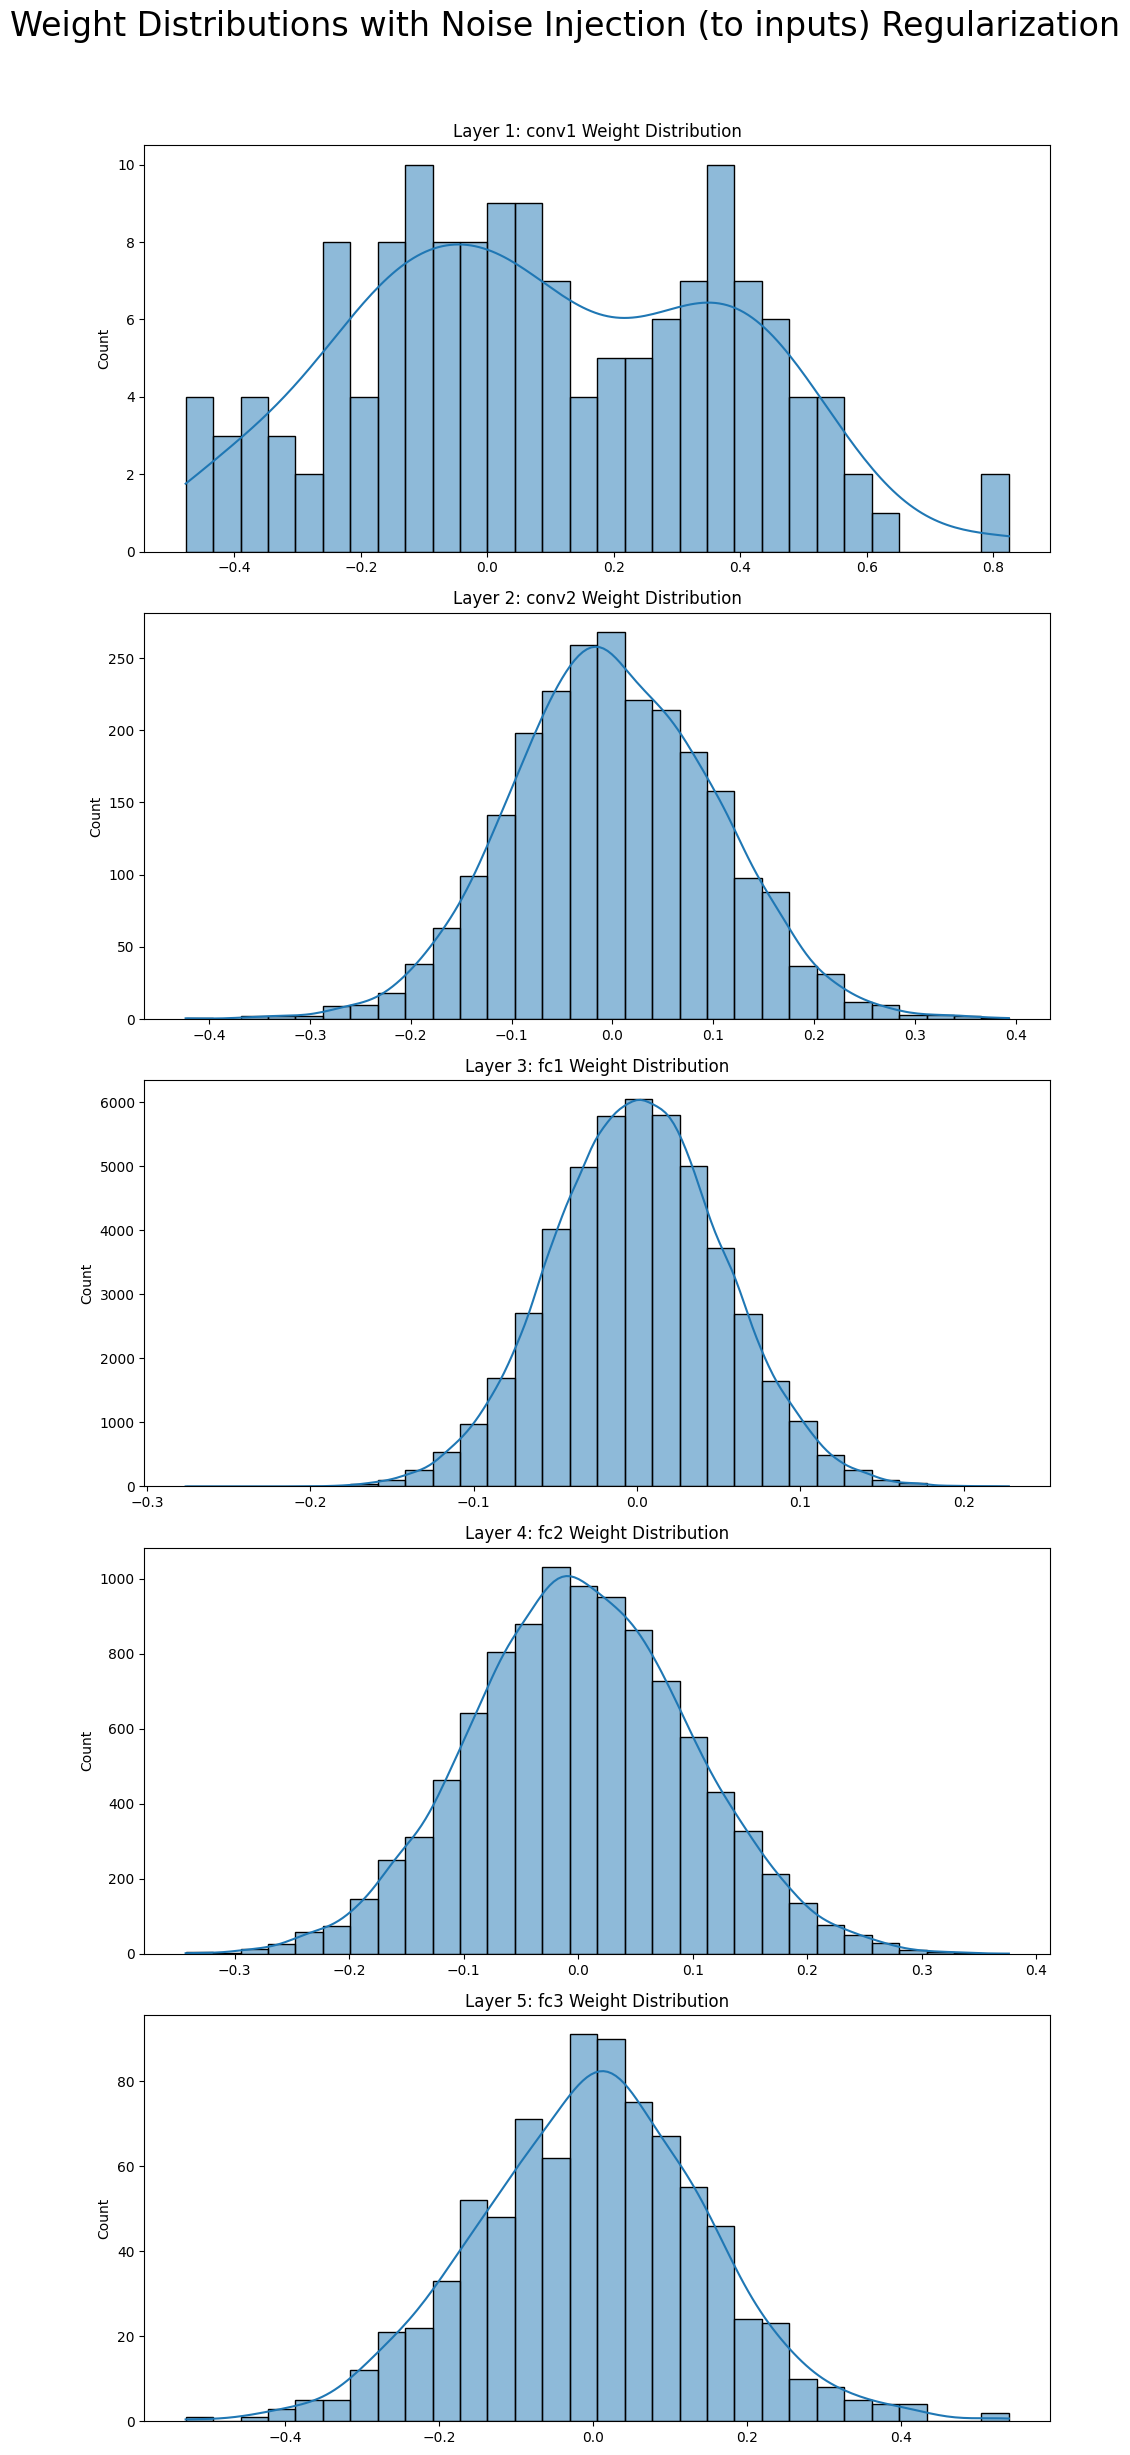

In [ ]:
plot_weight_distributions(
    model, title="Weight Distributions with Noise Injection (to inputs) Regularization"
)

#### Plots of Activation Maps

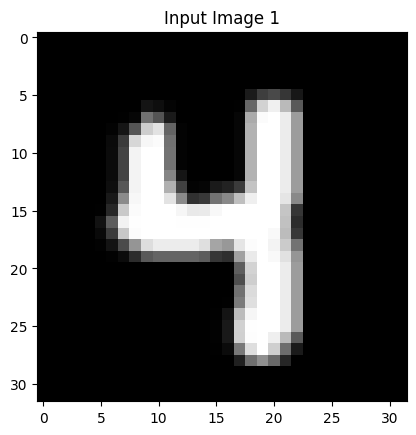

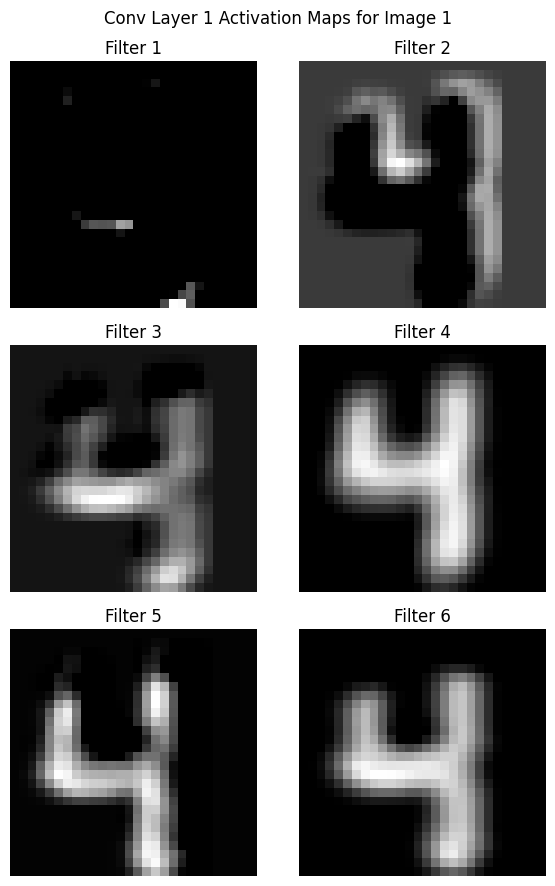

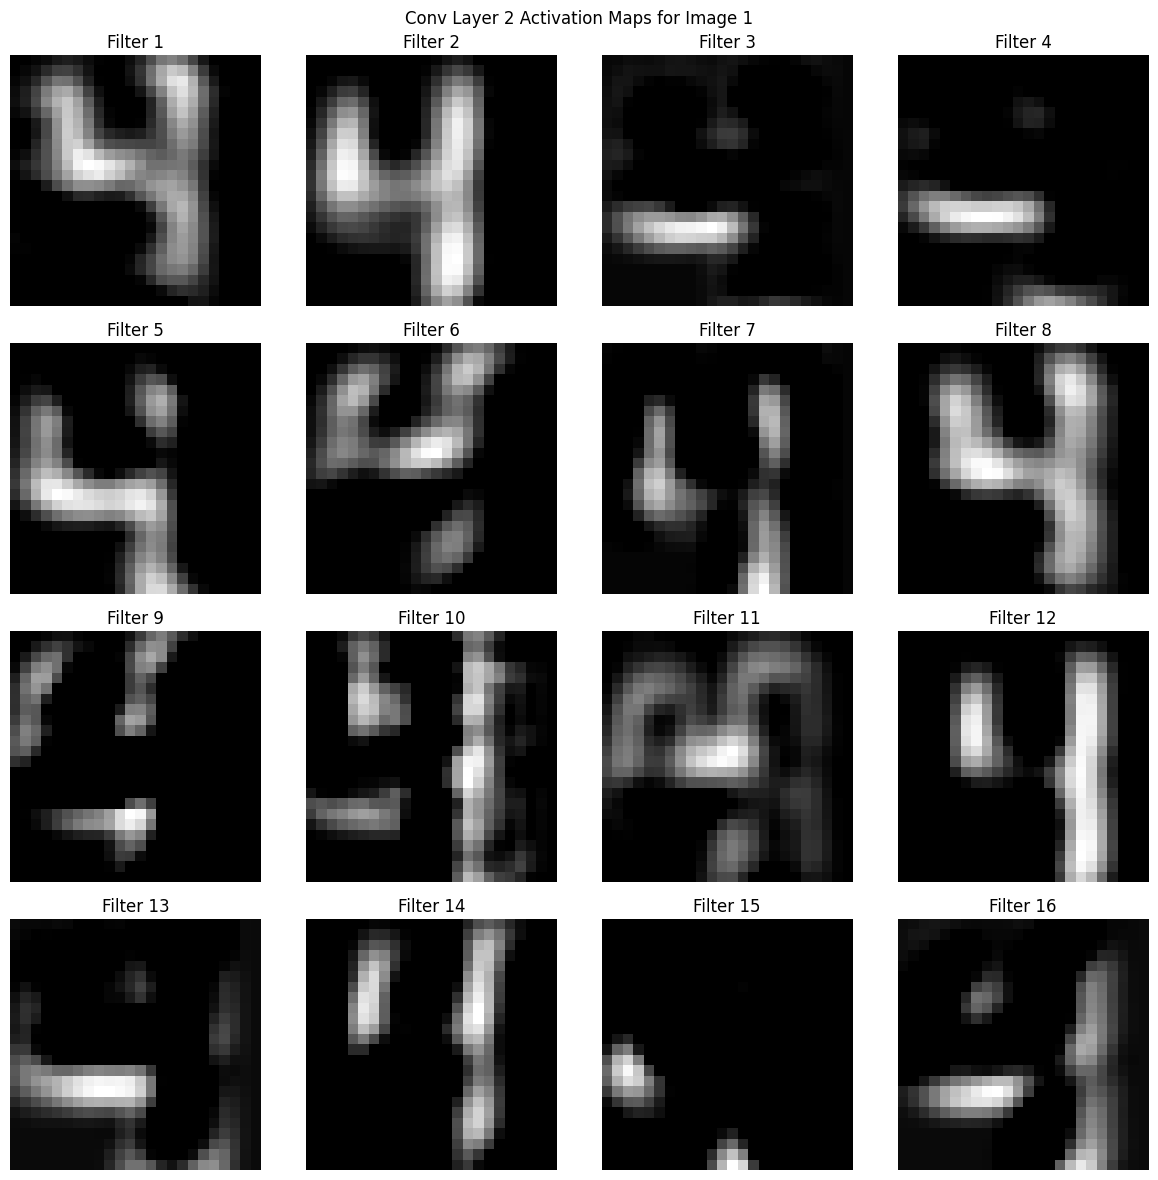

In [ ]:
plot_activation_maps(model, train_loader, num_images=1)

#### Plot of Predicted Probabilities

In [ ]:
plot_predicted_probabilities(model, train_loader, num_batches=10)

In [ ]:
plot_predicted_probabilities(model, test_loader, num_batches=10)

#### Plot of PCA of Activations

In [ ]:
plot_activations_pca(model, train_loader, device)

#### Plot of t-SNE of Activations

In [ ]:
plot_activations_tsne(model, train_loader, device)

#### Plots of Saliency Maps

In [ ]:
plot_saliency_maps(model, train_loader, num_images=9)

#### Plots of Occlusion Sensitivity

In [ ]:
plot_occlusion_sensitivity(model, train_loader, num_images=3, occluder_size=8, stride=4)

In [ ]:
plot_occlusion_sensitivity(model, train_loader, num_images=3, occluder_size=4, stride=2)

## Noise Injection (to weights of first convolutional layer)

### Training

In [ ]:
model = LeNet(
    lr=lr,
    momentum=momentum,
    in_channels=in_channels,
    noise_inject_weights=True,
    noise_stddev=0.03,
).to(device)
n_epochs = 5
losses, reg_losses, epochs, weights, train_accuracies, test_accuracies = train(
    train_loader, test_loader, model, n_epochs
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0


 20%|██        | 1/5 [00:29<01:58, 29.73s/it]

Accuracy of the network on the test images: 83 %
Epoch: 1


 40%|████      | 2/5 [01:00<01:30, 30.14s/it]

Accuracy of the network on the test images: 84 %
Epoch: 2


 60%|██████    | 3/5 [01:28<00:59, 29.52s/it]

Accuracy of the network on the test images: 95 %
Epoch: 3


 80%|████████  | 4/5 [01:57<00:29, 29.10s/it]

Accuracy of the network on the test images: 96 %
Epoch: 4


100%|██████████| 5/5 [02:24<00:00, 28.91s/it]

Accuracy of the network on the test images: 96 %


### Visualization

#### Plot of Losses and Accuracies

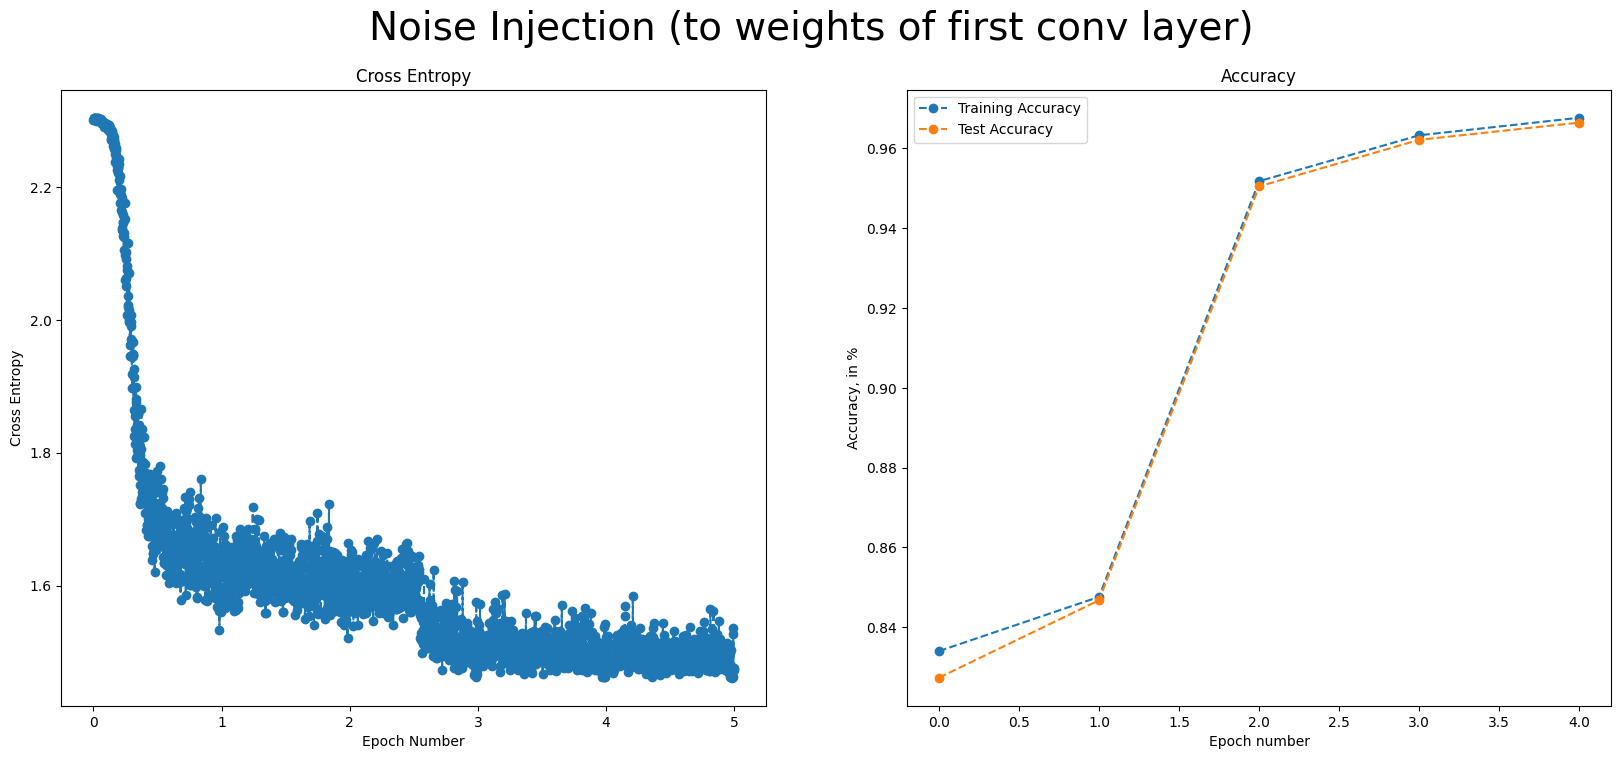

In [ ]:
plot_results(
    epochs,
    losses,
    train_accuracies,
    test_accuracies,
    title="Noise Injection (to weights of first conv layer)",
)

#### Plot of Weight Distributions

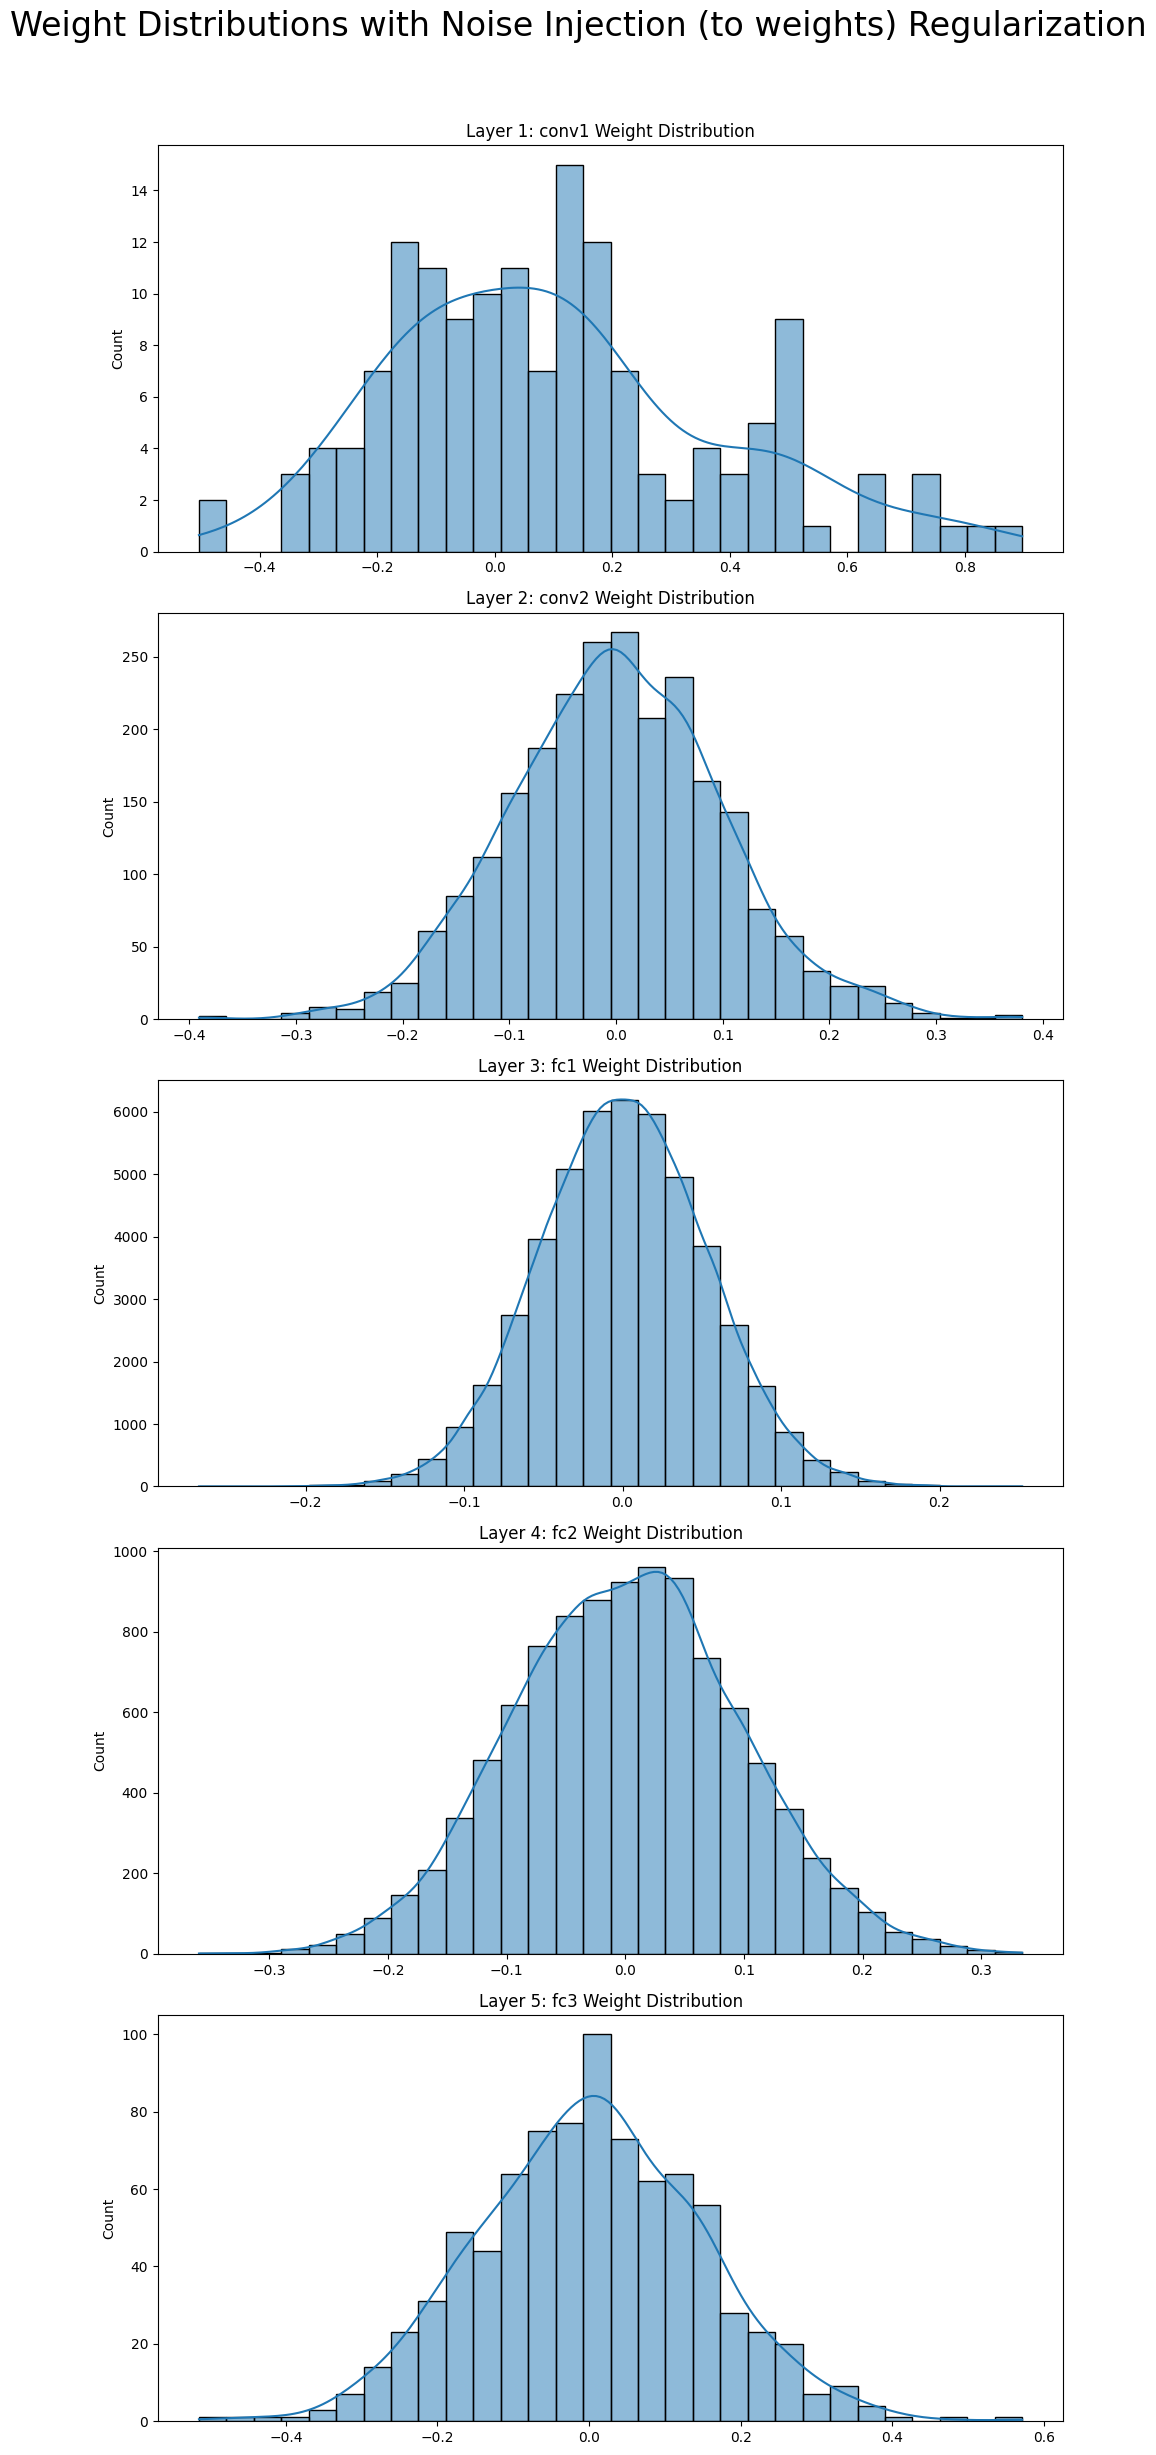

In [ ]:
plot_weight_distributions(
    model, title="Weight Distributions with Noise Injection (to weights) Regularization"
)

#### Plots of Activation Maps

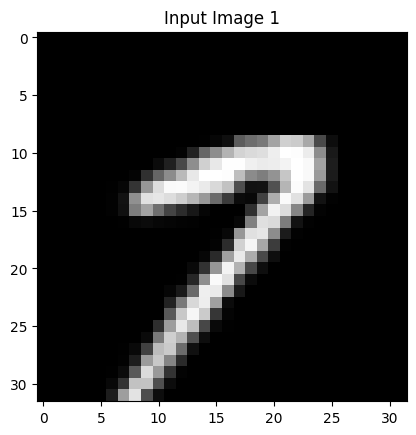

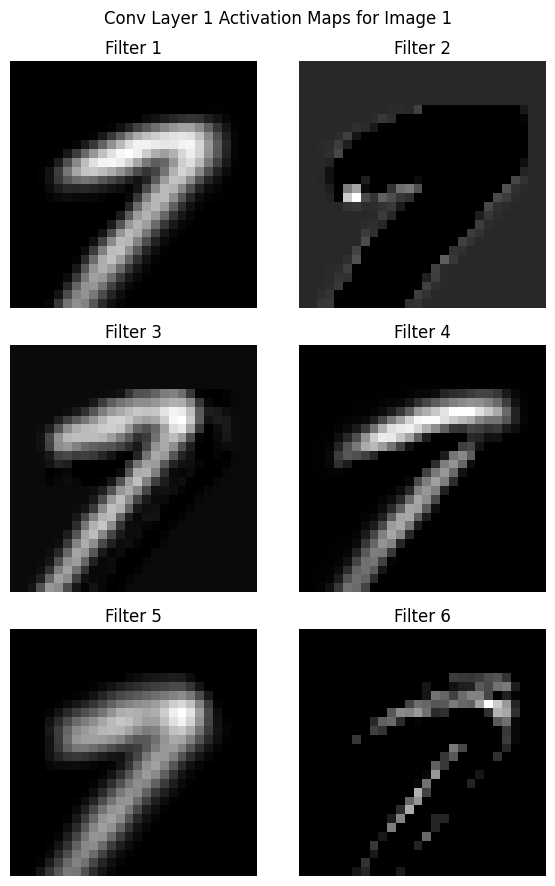

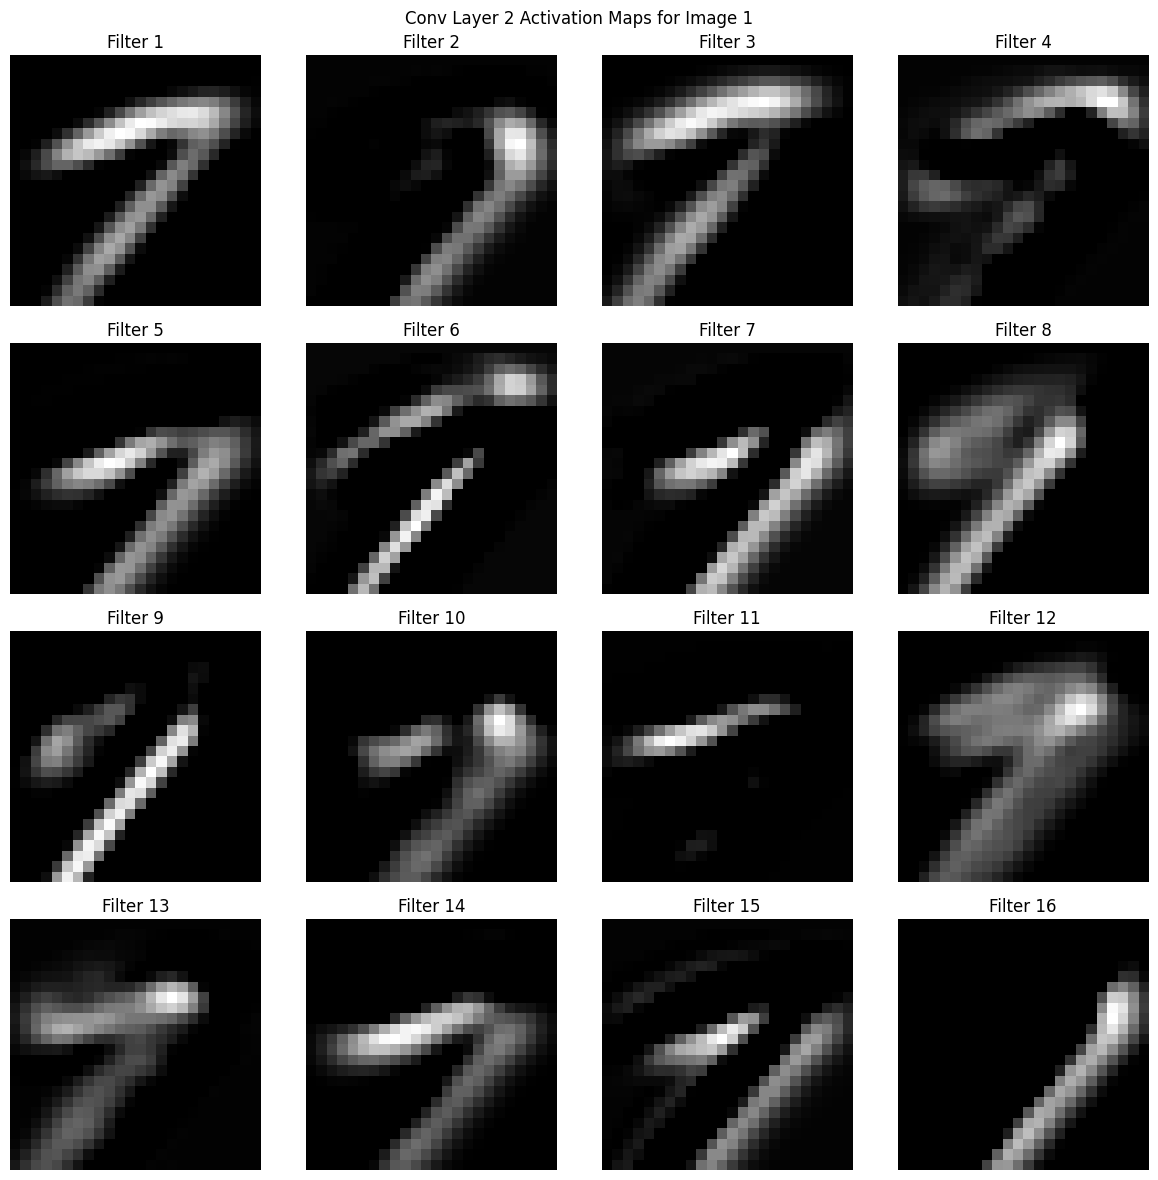

In [ ]:
plot_activation_maps(model, train_loader, num_images=1)

#### Plot of Predicted Probabilities

In [ ]:
plot_predicted_probabilities(model, train_loader, num_batches=10)

In [ ]:
plot_predicted_probabilities(model, test_loader, num_batches=10)

#### Plot of PCA of Activations

In [ ]:
plot_activations_pca(model, train_loader, device)

#### Plot of t-SNE of Activations

In [ ]:
plot_activations_tsne(model, train_loader, device)

#### Plots of Saliency Maps

In [ ]:
plot_saliency_maps(model, train_loader, num_images=9)

#### Plots of Occlusion Sensitivity

In [ ]:
plot_occlusion_sensitivity(model, train_loader, num_images=3, occluder_size=8, stride=4)

In [ ]:
plot_occlusion_sensitivity(model, train_loader, num_images=3, occluder_size=4, stride=2)

###